In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import sklearn.decomposition
import matplotlib.animation as animation
# import openmm.unit as u
import deeptime as dt
import networkx as nx


from cycler import cycler
plt.rcParams['font.size'] = 7
plt.rcParams['font.family'] = 'Calibri'
plt.rcParams['mathtext.default'] = 'regular'

plt.rcParams['axes.labelpad'] = 0.1
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['axes.linewidth'] = 0.7
colorList = ['#000000', '#FF0000', '#0000FF', '#FF64FF',
             '#2192E5', '#009900', '#FF8700', '#F2E100', 
             '#FFDE3B', '#5A1AF5']
plt.rcParams['axes.prop_cycle'] = cycler(color=colorList)
plt.rcParams['axes.spines.right'] = True
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.titlepad'] = 0.1
plt.rcParams['axes.titlesize'] = 7*1.2

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (3.25, 2.5)
plt.rcParams['figure.labelsize'] = 7
plt.rcParams['figure.titlesize'] = 7*1.2

plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.fontsize'] = 7
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.markerscale'] = 1
plt.rcParams['legend.numpoints'] = 1
plt.rcParams['legend.title_fontsize'] = 7*1.2

plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.dash_joinstyle'] = 'round'
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 1

plt.rcParams['savefig.dpi'] = 300
# plt.rcParams['savefig.transparent'] = True
plt.rcParams['savefig.bbox'] = 'tight'

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['xtick.major.size'] = 3
# plt.rcParams['xtick.major.top'] = True
plt.rcParams['xtick.major.width'] = 0.6
plt.rcParams['xtick.minor.size'] = 1.5
plt.rcParams['xtick.minor.visible'] = True
# plt.rcParams['xtick.minor.top'] = True
plt.rcParams['xtick.minor.width'] = 0.6
plt.rcParams['xtick.top'] = True

plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['ytick.major.size'] = 3
# plt.rcParams['ytick.major.right'] = True
plt.rcParams['ytick.major.width'] = 0.6
plt.rcParams['ytick.minor.size'] = 1.5
# plt.rcParams['ytick.minor.right'] = True
plt.rcParams['ytick.minor.width'] = 0.6
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True


In [7]:
import matplotlib.font_manager
matplotlib.font_manager.findSystemFonts(fontpaths=None,
                                       fontext='ttf')

['C:\\Windows\\Fonts\\pala.ttf',
 'C:\\Windows\\Fonts\\comic.ttf',
 'C:\\Windows\\Fonts\\corbeli.ttf',
 'C:\\Users\\ramon\\AppData\\Local\\Microsoft\\Windows\\Fonts\\materialdesignicons5-webfont.ttf',
 'C:\\Windows\\Fonts\\Candarab.ttf',
 'C:\\Windows\\Fonts\\calibrii.ttf',
 'C:\\Windows\\Fonts\\consolai.ttf',
 'C:\\Windows\\Fonts\\timesi.ttf',
 'C:\\Windows\\Fonts\\seguisbi.ttf',
 'C:\\Windows\\Fonts\\framd.ttf',
 'C:\\Windows\\Fonts\\seguisli.ttf',
 'C:\\Windows\\Fonts\\webdings.ttf',
 'C:\\Windows\\Fonts\\phagspa.ttf',
 'C:\\Windows\\Fonts\\timesbd.ttf',
 'C:\\Windows\\Fonts\\framdit.ttf',
 'C:\\Windows\\Fonts\\YuGothM.ttc',
 'C:\\Windows\\Fonts\\tahoma.ttf',
 'C:\\Windows\\Fonts\\cambriab.ttf',
 'C:\\Windows\\Fonts\\trebucbi.ttf',
 'C:\\Windows\\Fonts\\ntailub.ttf',
 'C:\\Windows\\Fonts\\impact.ttf',
 'C:\\Windows\\Fonts\\georgiaz.ttf',
 'C:\\Windows\\Fonts\\NirmalaB.ttf',
 'C:\\Windows\\Fonts\\cambriai.ttf',
 'C:\\Windows\\Fonts\\mmrtextb.ttf',
 'C:\\Windows\\Fonts\\calibrili.ttf'

# Utils

In [2]:
def monteCarloSim(uniqueStates, rateMatrix, steps):
    """ Returns a numpy array of shape (steps, 2)
        Where the first column is the time spent in the state 
        listed in the second column, i.e., (time, State)
    """
    curr_state = np.random.choice(uniqueStates)
    traj = []
    for i in range(steps):
        R = np.random.uniform()
        time = np.log(R) / rateMatrix[curr_state, curr_state]
        traj.append([time, curr_state])
        for j in range(uniqueStates):
            if j != curr_state:
                P_j = cum_prob(curr_state, j, rateMatrix)
                if R <= P_j:
                    curr_state = j
                    break
    return np.array(traj)

def cum_prob(i, j, rateMatrix):
    P_j = 0
    for k in range(j+1):
        if k != i:
            P_j += rateMatrix[i, k] / (-rateMatrix[i, i])
    return P_j

In [3]:
def SVD(rateMatrix):
    """ Utility function for SVD of Q matrix
        returns the Eigenvalues and Eigenvectors of the Rate Matrix Q
    """
    # it is transpose because the function returns 
    # the right eigenvec's but we want left eigenvectors
    eig_val, eig_vec = np.linalg.eig(rateMatrix.T)
    return (eig_val, eig_vec)

def Prob_t(uniqueStates, val, vec, time):
    """ returns the time evolution of the probabilites
        Note that this can be used for simulating the time evolution of the probabilities and
        as the starting point for the construction of a Transition Matrix at the
        desired lagtime
    """
    # this works because of how numpy casts when performing the operation
    D = np.eye(uniqueStates) * np.exp(val * time)
    return np.linalg.inv(vec.T) @ D @ vec.T

def MSMtraj(steps, transitionMatrix):
    """ returns the MSM and a discrete time discrete state 
        trajectory from the Transition Matrix
        at the spicified lagtime of shape (steps,)
    """
    MSM_true = dt.markov.msm.MarkovStateModel(transitionMatrix)
    traj_discretized = MSM_true.simulate(steps)
    return (MSM_true, traj_discretized)

In [4]:
def stateDurations(uniqueStates, traj):
    """ returns a dictionary whose keys are the unique States
        and values are a list of durations in that state from the 
        discrete time discrete state trajectory
    """
    durations = {i:[] for i in range(uniqueStates)}
    count = 1
    for frame, cond in enumerate(traj[:-1] == traj[1:]):
        if cond:
            count += 1
        else:
            durations[traj[frame]].append(count)
            count = 1
    return durations

def ProbMatrix(uniqueStates, traj):
    """ Returns a numpy array of shape (uniqueStates, uniqueStates)
        where elements i,j are the probabilities of jump from i to j
    """
    countMat = countMatrix(uniqueStates, traj)
    countSum = np.sum(countMat, axis=1)
    invCountSum_X2, invCountSum_X1 = np.meshgrid(1 / countSum, 1 / countSum)
    return countMat * invCountSum_X1

def countMatrix(uniqueStates, traj):
    """ returns count matrix where element i,j is the counts
        of i to j jumps
    """
    countsMat = np.zeros((uniqueStates, uniqueStates))
    for statei, statej in zip(traj[:-1], traj[1:]):
        if statei != statej:
            countsMat[statei, statej] += 1
    return countsMat

# Two state model

$A \leftrightharpoons B$ \
k$_{A \rightarrow B} = 1/step$ \
k$_{B \rightarrow A} = 2/step$

In [5]:
k_A_B = 1
k_B_A = 2
P_eq_A = k_B_A / (k_A_B + k_B_A)
P_eq_B = k_A_B / (k_A_B + k_B_A)
print(P_eq_A, P_eq_B)

0.6666666666666666 0.3333333333333333


In [6]:
def P_i(t, peq, p0, k1, k2):
    tau = (k1 + k2)**(-1)
    return peq + (p0 - peq) * np.exp(-t / tau)

In [7]:
P_0_A, P_0_B = (0.4, 0.6)
times = np.linspace(0, 10, num=1000)
P_A = P_i(times, P_eq_A, P_0_A, k_A_B, k_B_A)
P_B = P_i(times, P_eq_B, P_0_B, k_A_B, k_B_A)

In [8]:
t_A = 1 / k_A_B
t_B = 1 / k_B_A
print(t_A, t_B)

1.0 0.5


In [9]:
J_AB = 1 / (t_A + t_B)
print(J_AB)
print(k_A_B * P_eq_A)

0.6666666666666666
0.6666666666666666


In [10]:
relaxation_time = 1 / (k_A_B + k_B_A)
print(relaxation_time)

0.3333333333333333


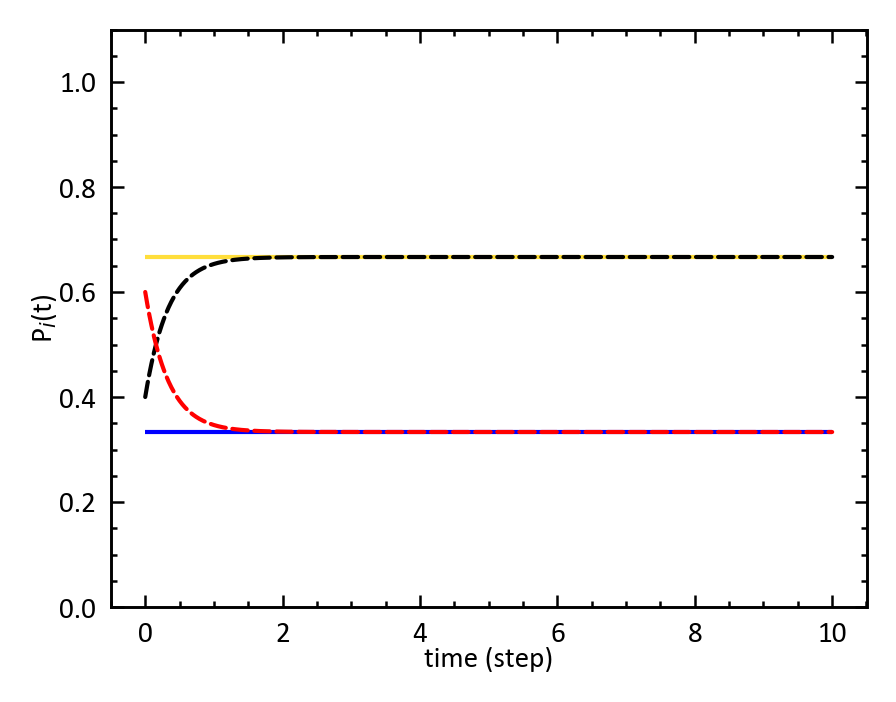

In [11]:
plt.hlines([P_eq_A, P_eq_B], 0, 10, colors=['#FFDE3B', 'blue'])

plt.plot(times, P_A, '--')
plt.plot(times, P_B, '--')

# plt.vlines(J_AB, 0, 1, colors='#5A1AF5', ls='--')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0,1.1])

plt.show()

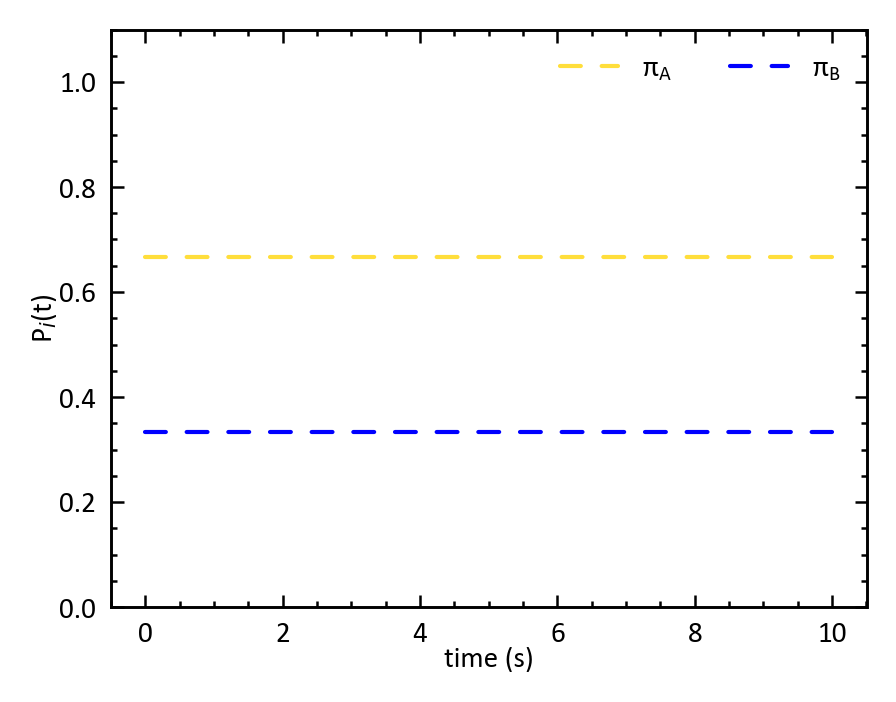

In [12]:
fig = plt.figure()

A = plt.plot(times[0], P_A[0])
B = plt.plot(times[0], P_B[0])

plt.hlines(P_eq_A, 0, 10, colors='#FFDE3B', linestyles=(0, (5,5)), label=r'$\pi_A$', 
           capstyle='round', joinstyle='miter')
plt.hlines(P_eq_B, 0, 10, colors='#0000FF', linestyles=(0, (5,5)), label=r'$\pi_B$',
           capstyle='round', joinstyle='round')

plt.xlabel('time (s)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

# plt.hlines(piC, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

def update(frame):
    A[0].set_data(times[:frame*5], P_A[:frame*5])
    B[0].set_data(times[:frame*5], P_B[:frame*5])
    return (A, B)

ani = animation.FuncAnimation(fig=fig, func=update, 
                              frames=times.shape[0]//5, interval=20)
plt.show()

In [18]:
#Pillow writers::

ani.save(filename="2statemodel.gif", writer="pillow")
# ani.save(filename="/tmp/pillow_example.apng", writer="pillow")

In [12]:
curr_state = np.random.choice(2)
steps = 1000
traj = [[curr_state, 0]]
for i in range(steps):
    R = np.random.uniform()
    div = k_A_B if curr_state == 0 else k_B_A
    time = - np.log(R) / div
    traj.append([curr_state, time])
    curr_state = 0 if curr_state == 1 else 1

In [13]:
traj = np.asarray(traj)

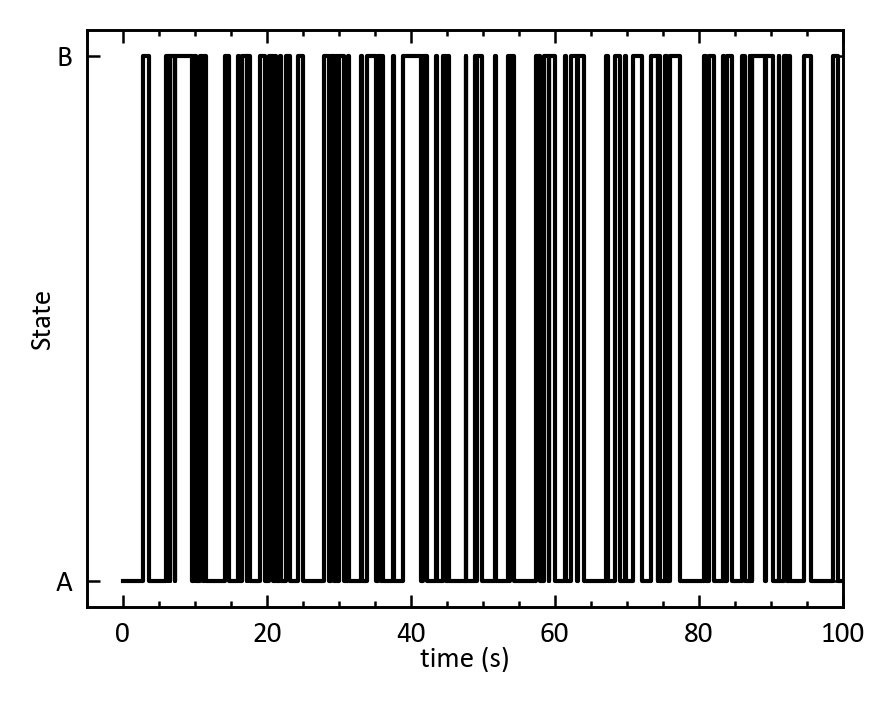

In [14]:
fig = plt.figure()

# A = (traj[:,0] == 0) + (traj[:,0] == 1)
# C = (traj[:,0] == 2) + (traj[:,0] == 1)
# plt.plot(np.cumsum(traj[:,1])[A], traj[:,0][A], 
#          drawstyle='steps')
plt.plot(np.cumsum(traj[:,1]), traj[:,0], 
         drawstyle='steps')
# plt.plot(np.cumsum(traj[:,1])[C], traj[:,0][C], 
#          drawstyle='steps')

plt.tick_params(axis='y', which='minor', left=False, 
                right=False)
plt.yticks([0,1], ['A', 'B'])
plt.xlabel('time (s)')
plt.ylabel('State')
plt.xlim([-5, 100])
# plt.legend(ncols=2)

plt.show()

In [23]:
fig.savefig("2stateKinetictraj.png", dpi=300)

In [15]:
T_A = traj[:,1][traj[:,0] == 0].sum()
T_B = traj[:,1][traj[:,0] == 1].sum()
print(T_A, T_B, T_A + T_B)

473.70156612563255 261.13312493572556 734.8346910613582


In [16]:
traj

array([[0.        , 0.        ],
       [0.        , 2.86655668],
       [1.        , 0.81170275],
       ...,
       [1.        , 1.09076731],
       [0.        , 0.95441879],
       [1.        , 0.34105954]])

In [17]:
N_AB = 0
N_BA = 0
for i, j in zip(traj[:,0][:-1], traj[:,0][1:]):
    if i == 0 and j == 1:
        N_AB += 1
    elif i == 1 and j == 0:
        N_BA += 1
print(N_AB, N_BA)

500 499


In [18]:
# on average the simulation is near the actual
print(t_A, T_A / N_AB, t_B, T_B / N_AB)

1.0 0.9474031322512652 0.5 0.5222662498714511


In [19]:
print(k_A_B, N_AB / T_A, k_B_A, N_AB / T_B)

1 1.0555168818407341 2 1.9147321892734532


In [20]:
print(P_eq_A, T_A / (T_A + T_B), P_eq_B, T_B / (T_A + T_B))

0.6666666666666666 0.6446369120671779 0.3333333333333333 0.35536308793282206


In [21]:
print(J_AB, N_AB / (T_A + T_B))

0.6666666666666666 0.680425143344587


In [22]:
print(relaxation_time, ((T_A / N_AB) * (T_B / N_AB)) / ((T_A / N_AB) + (T_B / N_AB)) )

0.3333333333333333 0.3366721025940374


# Three state model

$A \leftrightharpoons B \leftrightharpoons C$ \
k$_{A \rightarrow B} = 1/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{C \rightarrow B} = 1/step$

In [5]:
k_AB = 1
k_BC = 2
k_BA = 0.5
k_CB = 1

In [6]:
# rate matrix
Q = np.array([[-k_AB,       k_AB,     0], 
              [ k_BA, -k_BA-k_BC,  k_BC], 
              [    0,       k_CB, -k_CB]])

## Alaegbric

In [7]:
# from algebra
piA = (k_BA * k_CB) / (k_AB * k_BC + k_AB * k_CB + k_BA * k_CB)
piC = (k_AB * k_BC**2 + k_AB * k_BC * k_CB) / ((k_BC + k_CB) * (k_AB * k_BC + k_AB * k_CB + k_BA * k_CB))
piB = 1 - piA - piC
print(piA, piB, piC)

0.14285714285714285 0.2857142857142858 0.5714285714285714


In [8]:
(k_BA * k_CB) / (k_BA * k_CB + k_AB * k_BC + k_CB * k_AB)

0.14285714285714285

In [9]:
delta = k_AB * k_BC + k_AB * k_CB + k_CB * k_BA
print(piA, k_CB * k_BA / delta, piB, k_AB * k_CB / delta, piC, k_AB * k_BC / delta)

0.14285714285714285 0.14285714285714285 0.2857142857142858 0.2857142857142857 0.5714285714285714 0.5714285714285714


In [10]:
t_BA = (k_CB + k_BC) / (k_BA * k_CB)
t_BC = (k_BA + k_AB) / (k_BC * k_AB)
t_AC = (1 / k_AB) + t_BC
t_CA = (1 / k_CB) + t_BA
t_ABC = 1 / (k_BA + k_BC)
print(t_BA, t_BC, t_AC, t_CA, t_ABC)

6.0 0.75 1.75 7.0 0.4


In [11]:
print('Rate to A -> C ', 1/t_AC)
print('Rate to C -> A ', 1/t_CA)

Rate to A -> C  0.5714285714285714
Rate to C -> A  0.14285714285714285


In [12]:
phi_ba = k_BA / (k_BA + k_BC)
phi_bc = k_BC / (k_BA + k_BC)
print(1 / k_AB, 1 / k_CB, phi_ba / k_BA, phi_bc / k_BC)

1.0 1.0 0.4 0.4


In [13]:
print(k_BA, phi_ba * (k_BA + k_BC))

0.5 0.5


In [14]:
relaxation_time = ((1 / k_AB) * (1 / k_CB) * (1 / (k_BA + k_BC))) / (phi_ba * (1 / k_AB) \
                                                                     + phi_bc * (1 / k_CB) \
                                                                     + (1 / (k_BA + k_BC)))
print(relaxation_time, delta**-1, piB / (k_AB * k_CB))

0.28571428571428575 0.2857142857142857 0.2857142857142858


In [15]:
J_AB = k_AB * piA
J_BA = k_BA * piB
J_BC = k_BC * piB
J_CB = k_CB * piC
print(J_AB, J_BA, J_BC, J_CB, phi_bc / ((phi_ba / k_AB) + (1/(k_BA +k_BC)) + (phi_bc / k_CB)))

0.14285714285714285 0.1428571428571429 0.5714285714285716 0.5714285714285714 0.5714285714285714


## Simulation

In [16]:
times = np.linspace(0, 40, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [17]:
P = np.stack(P)

In [18]:
# this matchs with before
P[-1]

array([[0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857]])

In [19]:
P[2]

array([[0.92446662, 0.06983659, 0.00569679],
       [0.03491829, 0.82540853, 0.13967318],
       [0.0014242 , 0.06983659, 0.92873921]])

In [20]:
np.linalg.matrix_power(P[1], 999)

array([[0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857]])

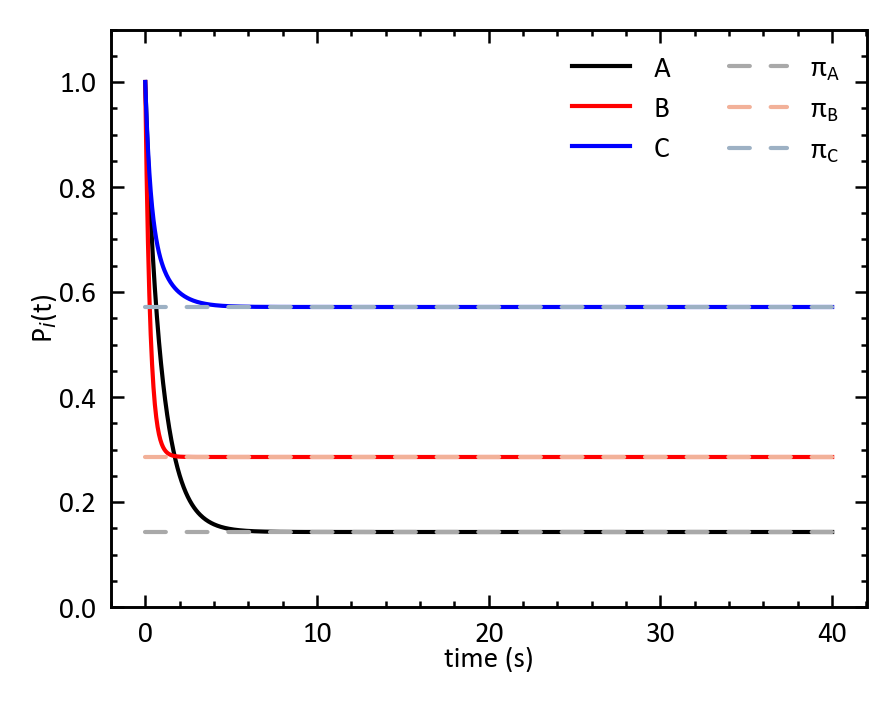

In [25]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')

plt.hlines(piA, 0, 40, colors='#A9A9A9', linestyles=(0, (5,5)), label=r'$\pi_A$', 
           capstyle='round', joinstyle='miter')
plt.hlines(piB, 0, 40, colors='#F2B199', linestyles=(0, (5,5)), label=r'$\pi_B$',
           capstyle='round', joinstyle='round')
plt.hlines(piC, 0, 40, colors='#9DB1C4', linestyles=(0, (5,5)), label=r'$\pi_C$', 
           capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (s)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [26]:
fig.savefig('3statemodel.png')

As can be seen the $\pi_i$'s from simulating the rate matrix agrees with the algebric resuslts from paper. \
The algebric results were obtained from solving the detailed balance \
$\pi_i k_{ij} = \pi_j k_{ji}$ \
and with \
$\sum_i^M\pi_i = 1$

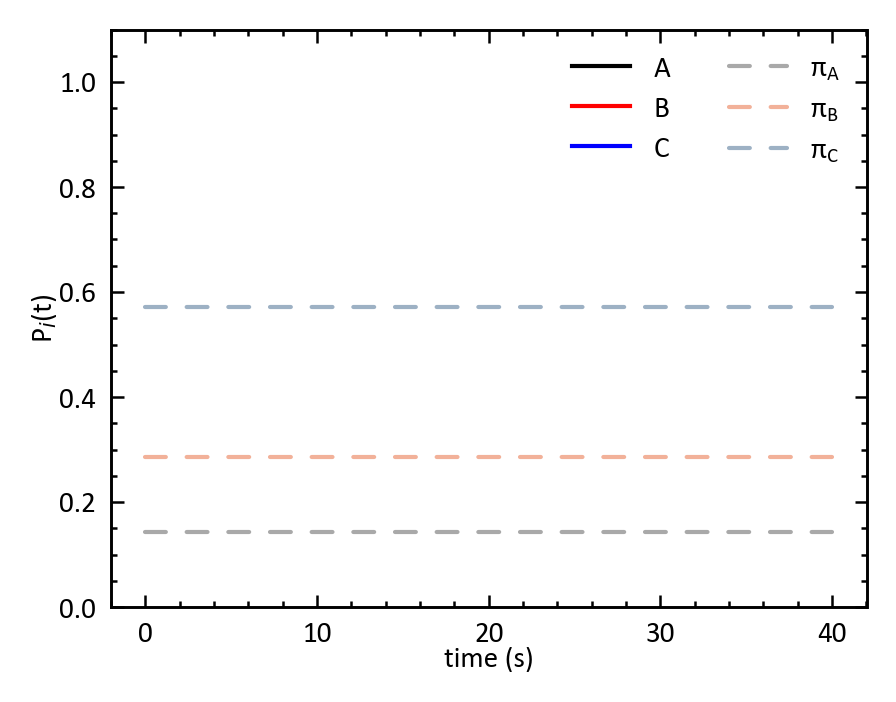

In [101]:
fig = plt.figure()

A = plt.plot(times[0], P[:, 0, 0][0], '-', label='A')
B = plt.plot(times[0], P[:, 1, 1][0], '-', label='B')
C = plt.plot(times[0], P[:, 2, 2][0], '-', label='C')

plt.hlines(piA, 0, 40, colors='#A9A9A9', linestyles=(0, (5,5)), label=r'$\pi_A$', 
           capstyle='round', joinstyle='miter')
plt.hlines(piB, 0, 40, colors='#F2B199', linestyles=(0, (5,5)), label=r'$\pi_B$',
           capstyle='round', joinstyle='round')
plt.hlines(piC, 0, 40, colors='#9DB1C4', linestyles=(0, (5,5)), label=r'$\pi_C$', 
           capstyle='round', joinstyle='bevel')

plt.xlabel('time (s)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

def update(frame):
    A[0].set_data(times[:frame*5], P[:, 0, 0][:frame*5])
    B[0].set_data(times[:frame*5], P[:, 1, 1][:frame*5])
    C[0].set_data(times[:frame*5], P[:, 2, 2][:frame*5])
    return (A, B, C)

ani = animation.FuncAnimation(fig=fig, func=update, 
                              frames=times.shape[0]//5, interval=20)
plt.show()

In [102]:
#Pillow writers::

ani.save(filename="3statemodel.gif", writer="pillow")
# ani.save(filename="/tmp/pillow_example.apng", writer="pillow")

## SVD

- One can also get the equilibrium probabilities from the spectral decomposition of the rate matrix, which I will show next

In [22]:
# it is transpose because the function returns the right eigenvec's but we want left eigenvectors
eig_val, eig_vec = np.linalg.eig(Q.T)

In [21]:
eig_val

array([-3.50000000e+00, -1.00000000e+00, -1.34455157e-16])

In [22]:
eig_val[2] * eig_vec[:,2]

array([-2.93405207e-17, -5.86810414e-17, -1.17362083e-16])

In [23]:
eig_vec[:, 2] @ Q

array([ 1.94289029e-16,  0.00000000e+00, -2.22044605e-16])

In [22]:
P[-1]

array([[0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857],
       [0.14285714, 0.28571429, 0.57142857]])

In [16]:
eig_val, eig_vec = SVD(Q)

In [28]:
print(piA, piB, piC)

0.14285714285714285 0.2857142857142858 0.5714285714285714


In [29]:
eig_vec[:,2] / np.sum(eig_vec[:,2])

array([0.14285714, 0.28571429, 0.57142857])

Notice that the eigenvector associated with 0 eigenvector is the equilibrium vector when it is normalized

In [20]:
def Prob_t(val, vec, time):
    D = np.array([[np.exp(val[0] * time), 0, 0],
                  [0, np.exp(val[1] * time), 0],
                  [0, 0, np.exp(val[2] * time)]])
    return np.linalg.inv(vec.T) @ D @ vec.T

In [25]:
# from Spectral decomposition
P_spectral_decomp = []
for t in times:
    P_spectral_decomp.append(Prob_t(eig_val, eig_vec, t))

In [15]:
P_spectral_decomp = np.stack(P_spectral_decomp)

In [30]:
# from Spectral decomposition
times = np.linspace(0, 40, num=1000)
P_spectral_decomp = []
for t in times:
    P_spectral_decomp.append(Prob_t(3, eig_val, eig_vec, t))

P_spectral_decomp = np.stack(P_spectral_decomp)

In [31]:
P.shape

(1000, 3, 3)

In [32]:
P_spectral_decomp.shape

(1000, 3, 3)

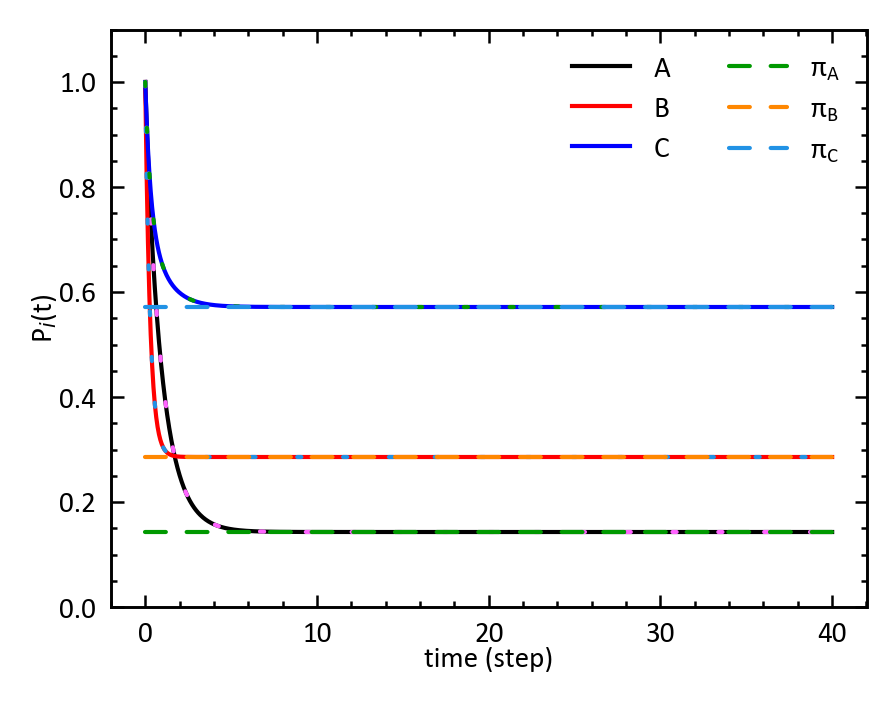

In [34]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')

plt.plot(times, P_spectral_decomp[:, 0, 0], ls=(0, (1, 10)))#, label='A')
plt.plot(times, P_spectral_decomp[:, 1, 1], ls=(0, (1, 10)))#, label='B')
plt.plot(times, P_spectral_decomp[:, 2, 2], ls=(0, (1, 10)))#, label='C')

plt.hlines(piA, 0, 40, colors='#009900', linestyles=(0, (5,5)), label=r'$\pi_A$', 
           capstyle='round', joinstyle='miter')
plt.hlines(piB, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_B$',
           capstyle='round', joinstyle='round')
plt.hlines(piC, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_C$', 
           capstyle='round', joinstyle='bevel')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

Notice that the above is another way to evolve the $\textbf{P}(t)$ with the spectral decomposition

## Kinetic Monte Carlo

Now we will do the kinetic Monte Carlo

### One round

In [35]:
Q

array([[-1. ,  1. ,  0. ],
       [ 0.5, -2.5,  2. ],
       [ 0. ,  1. , -1. ]])

In [22]:
def cum_prob(i, j, rate_mat):
    P_j = 0
    for k in range(j+1):
        if k != i:
            P_j += rate_mat[i, k] / (-rate_mat[i, i])
    return P_j

In [17]:
cum_prob(1, 2, Q)

1.0

In [24]:
curr_state = np.random.choice(3)
steps = 1000
traj = []
for i in range(steps):
    R = np.random.uniform()
    time = np.log(R) / Q[curr_state, curr_state]
    traj.append([curr_state, time])
    for j in range(Q.shape[0]):
        if j != curr_state:
            P_j = cum_prob(curr_state, j, Q)
            if R <= P_j:
                curr_state = j
                break

In [19]:
traj = np.array(traj)

NameError: name 'traj' is not defined

In [36]:
traj = monteCarloSim(3, Q, 1000)

In [37]:
traj

array([[0.37233653, 2.        ],
       [0.34100839, 1.        ],
       [0.94692434, 2.        ],
       ...,
       [0.07801433, 1.        ],
       [0.71094616, 2.        ],
       [0.26980895, 1.        ]])

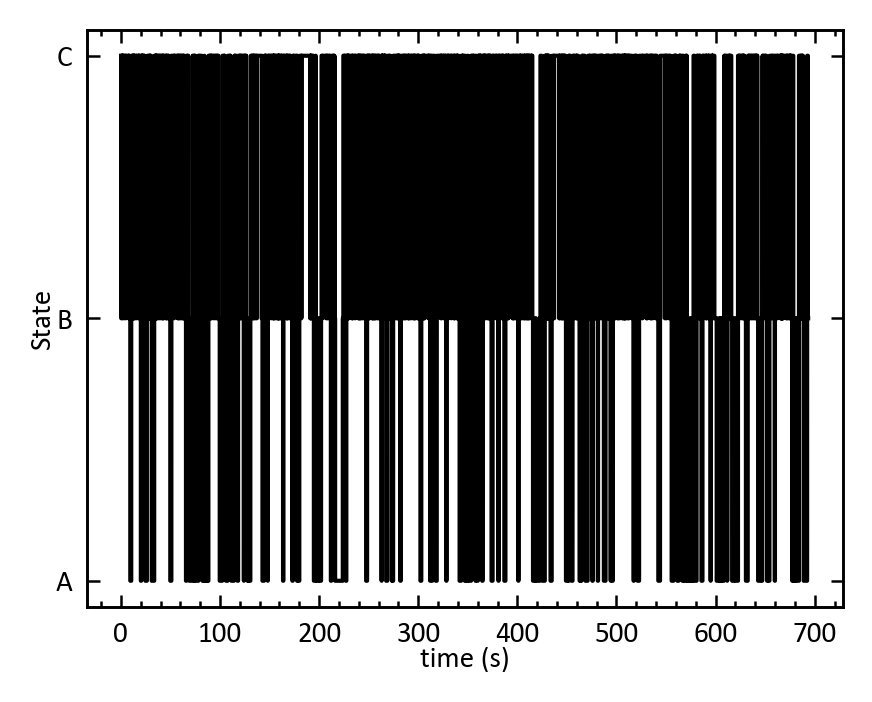

In [39]:
fig = plt.figure()

# I was trying to color the trajectory but the intermediate region was not coloring properly
# A = (traj[:,0] == 0) + (traj[:,0] == 1)
# C = (traj[:,0] == 2) + (traj[:,0] == 1)
# plt.plot(np.cumsum(traj[:,1])[A], traj[:,0][A], 
#          drawstyle='steps')
plt.plot(np.cumsum(traj[:,0]), traj[:,1], 
         drawstyle='steps')
# plt.plot(np.cumsum(traj[:,1])[C], traj[:,0][C], 
#          drawstyle='steps')

plt.tick_params(axis='y', which='minor', left=False, 
                right=False)
plt.yticks([0,1,2], ['A', 'B', 'C'])
plt.xlabel('time (s)')
plt.ylabel('State')
# plt.xlim([0, 10])
# plt.legend(ncols=2)

plt.show()

In [40]:
fig.savefig("3statemc.png")

$A \leftrightharpoons B \leftrightharpoons C$ \
k$_{A \rightarrow B} = 1/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{C \rightarrow B} = 1/step$

Now we will try to compute the rate constants from the coloring of the trajectory

In [28]:
traj[:20]

array([[1.        , 0.47084295],
       [2.        , 0.50071204],
       [1.        , 0.37119401],
       [2.        , 0.30843836],
       [1.        , 0.03692903],
       [2.        , 0.16657274],
       [1.        , 0.52347644],
       [2.        , 3.27562862],
       [1.        , 0.63481214],
       [2.        , 0.05299623],
       [1.        , 0.63577654],
       [2.        , 0.09882601],
       [1.        , 0.49195591],
       [2.        , 0.1236641 ],
       [1.        , 0.93859084],
       [0.        , 0.51971791],
       [1.        , 1.05213577],
       [0.        , 0.40324637],
       [1.        , 0.26871715],
       [2.        , 0.99067288]])

In [41]:
N_AB = 0
N_BC = 0
N_BA = 0
N_CB = 0
for i, j in zip(traj[:,1][:-1], traj[:,1][1:]):
    if i == 0 and j == 1:
        N_AB += 1
    elif i == 1 and j == 2:
        N_BC += 1
    elif i == 1 and j == 0:
        N_BA += 1
    elif i == 2 and j == 1:
        N_CB += 1
print(N_AB, N_BC, N_BA, N_CB)

101 398 101 399


In [42]:
T_A = traj[:,0][traj[:,1] == 0].sum()
T_B = traj[:,0][traj[:,1] == 1].sum()
T_C = traj[:,0][traj[:,1] == 2].sum()
T   = traj[:,0].sum()
print(1/k_AB, T_A / N_AB, t_ABC, T_B / (N_AB + N_BC), 1/k_CB, T_C / N_BC)

1.0 1.0962803893710267 0.4 0.4022972445685519 1.0 0.9595906925845448


In [43]:
print(t_BC, (T_A + T_B) / N_BC, t_BA, (T_B + T_C) / N_BA, 
      t_AC, T_A / N_AB + (T_A + T_B) / N_BC, 
      t_CA, T_C / N_BC + (T_B + T_C) / N_BA)

0.75 0.7825895587089977 6.0 5.768944759290655 1.75 1.8788699480800244 7.0 6.728535451875199


In [44]:
print(phi_ba, N_AB / (N_AB + N_BC), phi_bc, N_BC / (N_AB + N_BC))

0.2 0.20240480961923848 0.8 0.7975951903807615


In [45]:
print(piA, T_A / traj[:,0].sum(), piB, T_B / traj[:,0].sum(), piC, T_C /traj[:,0].sum())

0.14285714285714285 0.15968600674148864 0.2857142857142858 0.28951525020533814 0.5714285714285714 0.5507987430531732


In [46]:
print(J_AB, N_AB / traj[:,0].sum(), J_BC, N_BC / traj[:,0].sum())

0.14285714285714285 0.14566164668247503 0.5714285714285716 0.5739934196002481


In [47]:
print(k_AB, N_AB / traj[:,0].sum() / (T_A / traj[:,0].sum()), 
      k_BC, N_BC / traj[:,0].sum() / (T_B / traj[:,0].sum()), N_BC / T_B, 
      k_BA, N_AB / T_B, k_CB, N_BC / T_C)

1 0.9121753975492839 2 1.982601673635998 1.9826016736359982 0.5 0.5031225352694367 1 1.0421109830761464


### Estimates

$A \leftrightharpoons B \leftrightharpoons C$ \
k$_{A \rightarrow B} = 1/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{C \rightarrow B} = 1/step$

In [35]:
curr_state = np.random.choice(3)
steps = [10, 100, 1000, 10000]
replicates = 3
trajs = []
for k, step in enumerate(steps):
    temp = []
    for replicate in range(replicates):
        traj = []
        for i in range(step):
            R = np.random.uniform()
            time = np.log(R) / Q[curr_state, curr_state]
            traj.append([curr_state, time])
            for j in range(Q.shape[0]):
                if j != curr_state:
                    P_j = cum_prob(curr_state, j, Q)
                    if R <= P_j:
                        curr_state = j
                        break
        traj = np.array(traj)
        temp.append(traj)
    trajs.append(temp)

In [19]:
steps = [10, 100, 1000, 10000]
replicates = 3
trajs = []
for k, step in enumerate(steps):
    temp = []
    for replicate in range(replicates):
        temp.append(monteCarloSim(3, Q, step))
    trajs.append(temp)

In [20]:
estimates = []
for step in trajs:
    estimate = []
    for traj in step:
        N_ab, N_bc = (0,0)
        for i, j in zip(traj[:,1][:-1], traj[:,1][1:]):
            if i == 0 and j == 1:
                N_ab += 1
            elif i == 1 and j == 2:
                N_bc += 1
        
        T_a = traj[:,0][traj[:,1] == 0].sum()
        T_b = traj[:,0][traj[:,1] == 1].sum()
        T_c = traj[:,0][traj[:,1] == 2].sum()
        T   = traj[:,0].sum()
        # print(N_ab, N_bc)
        MFPTs = [T_a / N_ab, T_b / (N_ab + N_bc), T_c / N_bc, (T_a + T_b) / N_bc, (T_b + T_c) / N_ab, 
                 T_a / N_ab + (T_a + T_b) / N_bc, T_c / N_bc + (T_b + T_c) / N_ab]
        committors = [N_ab / (N_ab + N_bc), N_bc / (N_ab + N_bc)]
        pi = [T_a / traj[:,0].sum(), T_b / traj[:,0].sum(), T_c /traj[:,0].sum()]
        flux = [N_ab / traj[:,0].sum(), N_bc / traj[:,0].sum()]
        rate = [N_ab / T_a, N_bc / T_b, N_ab / T_b, N_bc / T_c]
        estimate.append([MFPTs, committors, pi, flux, rate])
    estimates.append(estimate)

C:\Users\ramon\AppData\Local\Temp\ipykernel_13440\3813788197.py:17: RuntimeWarning: invalid value encountered in scalar divide
  MFPTs = [T_a / N_ab, T_b / (N_ab + N_bc), T_c / N_bc, (T_a + T_b) / N_bc, (T_b + T_c) / N_ab,
C:\Users\ramon\AppData\Local\Temp\ipykernel_13440\3813788197.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  MFPTs = [T_a / N_ab, T_b / (N_ab + N_bc), T_c / N_bc, (T_a + T_b) / N_bc, (T_b + T_c) / N_ab,
C:\Users\ramon\AppData\Local\Temp\ipykernel_13440\3813788197.py:18: RuntimeWarning: invalid value encountered in scalar divide
  T_a / N_ab + (T_a + T_b) / N_bc, T_c / N_bc + (T_b + T_c) / N_ab]
C:\Users\ramon\AppData\Local\Temp\ipykernel_13440\3813788197.py:18: RuntimeWarning: divide by zero encountered in scalar divide
  T_a / N_ab + (T_a + T_b) / N_bc, T_c / N_bc + (T_b + T_c) / N_ab]
C:\Users\ramon\AppData\Local\Temp\ipykernel_13440\3813788197.py:22: RuntimeWarning: invalid value encountered in scalar divide
  rate = [N_ab / T_a, N_bc / T_b, N

In [40]:
estimates

[[[[1.2491274168176896,
    0.872107026071703,
    0.6852069451134511,
    2.286263321331298,
    3.208077982849434,
    3.5353907381489877,
    3.893284927962885],
   [0.4, 0.6],
   [0.2802490136332909, 0.48915573092998715, 0.23059525543672196],
   [0.2243558262032714, 0.3365337393049071],
   [0.8005588433465233,
    0.6879889532625657,
    0.4586593021750438,
    1.4594131118073064]],
  [[nan,
    0.2618798281528213,
    0.8752997063899441,
    0.2618798281528213,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.2302889035530501, 0.76971109644695],
   [0.0, 0.8793686217735863],
   [nan, 3.818545349802372, 0.0, 1.142465823648411]],
  [[0.64295371174507,
    0.5584017231526957,
    0.7305767409447004,
    2.3604348754993443,
    1.4177206992176263,
    3.003388587244414,
    2.1482974401623265],
   [0.6, 0.4],
   [0.3120113048061279, 0.451633471855964, 0.23635522333790807],
   [0.48527802096247924, 0.32351868064165284],
   [1.5553219177876032,
    0.7163301677180166,
    1.0744952

In [55]:
MFPTs = []
for i in estimates:
    for j in i:
        MFPTs.append(j[0])

In [56]:
MFPTs = np.reshape(np.nan_to_num(np.array(MFPTs), nan=np.nan, posinf=np.nan, neginf=np.nan), 
                   newshape=(4,3,7))

In [40]:
MFPTs

array([[[        nan,  0.47572784,  0.99011252,  0.47572784,
                 nan,         nan,         nan],
        [ 0.2847043 ,  0.65960838,  1.40005643,  1.60392106,
          2.71927319,  1.88862536,  4.11932961],
        [        nan,  0.24785071,  0.95683283,  0.24785071,
                 nan,         nan,         nan]],

       [[ 1.31127623,  0.42466594,  0.91125576,  0.81525293,
          6.36209573,  2.12652917,  7.27335149],
        [ 0.67867788,  0.3373254 ,  0.87271396,  0.45278032,
         10.98567173,  1.1314582 , 11.85838569],
        [ 1.27150325,  0.29435767,  1.0319175 ,  0.43354531,
         15.21495331,  1.70504856, 16.2468708 ]],

       [[ 0.94050687,  0.38205831,  1.02552161,  0.69633123,
          6.30562385,  1.6368381 ,  7.33114546],
        [ 0.93015598,  0.40447346,  1.07356176,  0.76444984,
          5.88435875,  1.69460582,  6.95792051],
        [ 0.98872681,  0.42112303,  0.97873043,  0.78335145,
          5.86957225,  1.77207826,  6.84830267]],

    

In [39]:
np.nanmean(MFPTs[-1], axis=0)

array([0.97815236, 0.39832812, 0.98806567, 0.73848288, 6.00984532,
       1.71663524, 6.99791099])

In [40]:
np.nanstd(MFPTs[-1], axis=0)

array([0.01572925, 0.00552453, 0.01477583, 0.00783169, 0.11414402,
       0.00875253, 0.12661955])

In [42]:
np.nanmean(MFPTs, axis=1).T[4]

array([5.51604026, 5.84126401, 5.57196461, 6.00984532])

In [50]:
print(1/k_AB, 1/k_CB, t_BA)

1.0 1.0 6.0


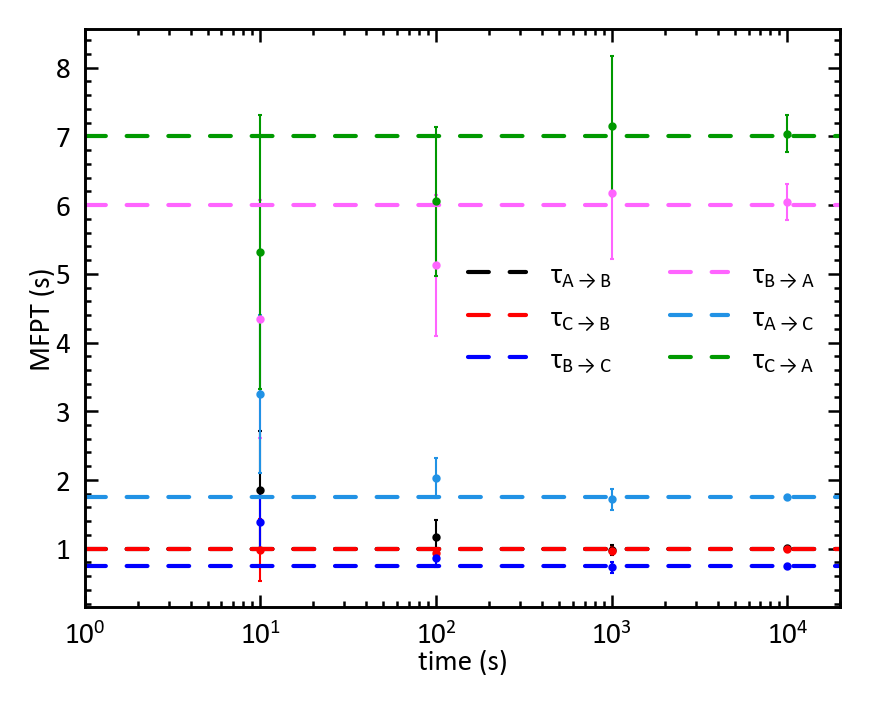

In [58]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[0], yerr=np.nanstd(MFPTs, axis=1).T[0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[2], yerr=np.nanstd(MFPTs, axis=1).T[2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[3], yerr=np.nanstd(MFPTs, axis=1).T[3], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[4], yerr=np.nanstd(MFPTs, axis=1).T[4], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[5], yerr=np.nanstd(MFPTs, axis=1).T[5], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(MFPTs, axis=1).T[6], yerr=np.nanstd(MFPTs, axis=1).T[6], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(1/k_AB, 1, 20000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$\tau_{A \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(1/k_CB, 1, 20000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$\tau_{C \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(t_BC, 1, 20000, colors=colorList[2], linestyles=(0, (5,5)), label=r'$\tau_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(t_BA, 1, 20000, colors=colorList[3], linestyles=(0, (5,5)), label=r'$\tau_{B \rightarrow A}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(t_AC, 1, 20000, colors=colorList[4], linestyles=(0, (5,5)), label=r'$\tau_{A \rightarrow C}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(t_CA, 1, 20000, colors=colorList[5], linestyles=(0, (5,5)), label=r'$\tau_{C \rightarrow A}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'MFPT (s)')
plt.xlim([1,20000])
# plt.ylim([0, 1.1])
plt.legend(ncols=2, loc="center right")

plt.show()

In [59]:
fig.savefig("3state_mfpts.png")

In [79]:
estimates

[[[[0.004365623046920769,
    0.32030405105623405,
    1.0440181205657904,
    0.40147146958202273,
    5.777592737544332,
    0.4058370926289435,
    6.821610858110122],
   [0.2, 0.8],
   [0.0007550422840600237, 0.27698578152980713, 0.7222591761861329],
   [0.17295178166896066, 0.6918071266758427],
   [229.06237878355896,
    2.497626855988619,
    0.6244067139971547,
    0.9578377810703751]],
  [[nan,
    0.17198714461661013,
    0.860633850360883,
    0.17198714461661013,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.1665539878165645, 0.8334460121834354],
   [0.0, 0.9684095179778867],
   [nan, 5.814388059230692, 0.0, 1.1619343110669857]],
  [[nan,
    0.2396171970354765,
    0.1748509309840442,
    0.2396171970354765,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.5781317810381573, 0.4218682189618427],
   [0.0, 2.41273075635119],
   [nan, 4.173323168670341, 0.0, 5.719157423824376]]],
 [[[0.8451161260754486,
    0.3426134820206673,
    0.9165701534004194,
    0.5688476

In [60]:
committors = []
for i in estimates:
    for j in i:
        committors.append(j[1])

In [61]:
committors = np.reshape(np.nan_to_num(np.array(committors), nan=np.nan, posinf=np.nan, neginf=np.nan), 
                        newshape=(4,3,2))

In [42]:
committors

array([[[0.        , 1.        ],
        [0.        , 1.        ],
        [0.        , 1.        ]],

       [[0.22      , 0.78      ],
        [0.16      , 0.84      ],
        [0.20408163, 0.79591837]],

       [[0.22044088, 0.77955912],
        [0.198     , 0.802     ],
        [0.174     , 0.826     ]],

       [[0.1928    , 0.8072    ],
        [0.1956    , 0.8044    ],
        [0.1974    , 0.8026    ]]])

In [43]:
np.nanmean(committors[-1], axis=0)

array([0.19526667, 0.80473333])

In [44]:
np.nanstd(MFPTs[-1], axis=0)

array([0.02016777, 0.00292875, 0.01221458, 0.00281804, 0.09730539,
       0.01739884, 0.10868013])

In [45]:
np.nanmean(committors, axis=1).T[0]

array([0.        , 0.19469388, 0.19748029, 0.19526667])

In [46]:
print(phi_ba, phi_bc)

0.2 0.8


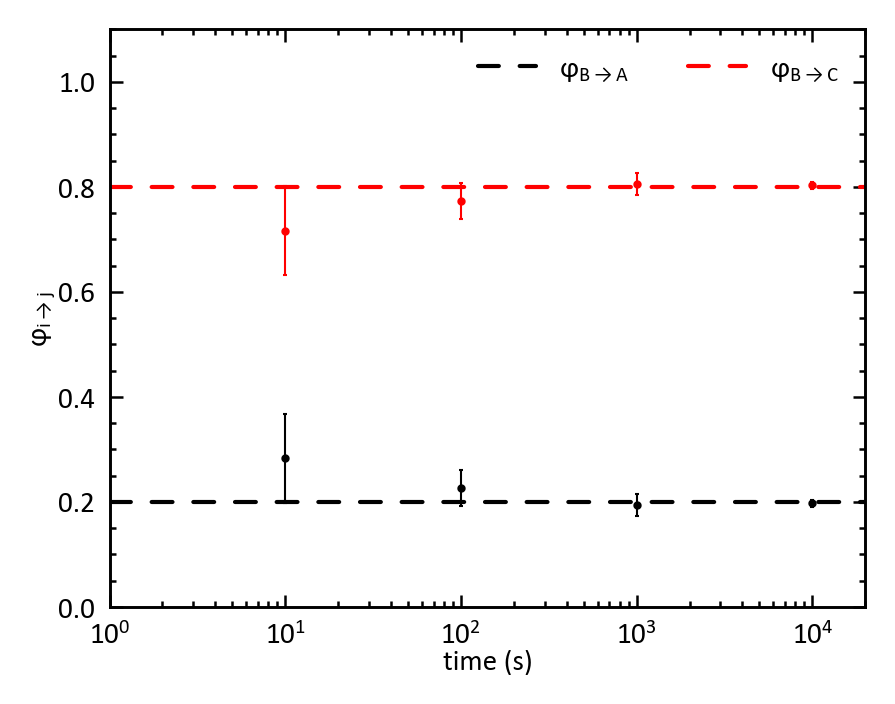

In [72]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, np.nanmean(committors, axis=1).T[0], yerr=np.nanstd(committors, axis=1).T[0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(committors, axis=1).T[1], yerr=np.nanstd(committors, axis=1).T[1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(phi_ba, 1, 20000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$\phi_{B \rightarrow A}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(phi_bc, 1, 20000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$\phi_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$\phi_{i \rightarrow j}$')
plt.xlim([1,20000])
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [73]:
fig.savefig("3state_committors.png")

In [89]:
estimates

[[[[0.004365623046920769,
    0.32030405105623405,
    1.0440181205657904,
    0.40147146958202273,
    5.777592737544332,
    0.4058370926289435,
    6.821610858110122],
   [0.2, 0.8],
   [0.0007550422840600237, 0.27698578152980713, 0.7222591761861329],
   [0.17295178166896066, 0.6918071266758427],
   [229.06237878355896,
    2.497626855988619,
    0.6244067139971547,
    0.9578377810703751]],
  [[nan,
    0.17198714461661013,
    0.860633850360883,
    0.17198714461661013,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.1665539878165645, 0.8334460121834354],
   [0.0, 0.9684095179778867],
   [nan, 5.814388059230692, 0.0, 1.1619343110669857]],
  [[nan,
    0.2396171970354765,
    0.1748509309840442,
    0.2396171970354765,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.5781317810381573, 0.4218682189618427],
   [0.0, 2.41273075635119],
   [nan, 4.173323168670341, 0.0, 5.719157423824376]]],
 [[[0.8451161260754486,
    0.3426134820206673,
    0.9165701534004194,
    0.5688476

In [64]:
pi = []
for i in estimates:
    for j in i:
        pi.append(j[2])

In [65]:
pi = np.reshape(np.nan_to_num(np.array(pi), nan=np.nan, posinf=np.nan, neginf=np.nan), 
                newshape=(4,3,3))

In [63]:
pi

array([[[0.        , 0.22640129, 0.77359871],
        [0.11661258, 0.29538708, 0.58800034],
        [0.        , 0.38543682, 0.61456318]],

       [[0.12357448, 0.29364778, 0.58277774],
        [0.15769205, 0.23814416, 0.60416379],
        [0.25415783, 0.34249554, 0.40334663]],

       [[0.11139298, 0.29408141, 0.59452561],
        [0.17379872, 0.26944406, 0.55675722],
        [0.14977168, 0.31304815, 0.53718017]],

       [[0.13927471, 0.28052575, 0.58019955],
        [0.14130272, 0.28766868, 0.5710286 ],
        [0.13937651, 0.29509123, 0.56553226]]])

In [64]:
np.nanmean(committors[-1], axis=0)

array([0.19815969, 0.80184031])

In [95]:
np.nanstd(MFPTs[-1], axis=0)

array([0.03581021, 0.0038253 , 0.02265483, 0.01772442, 0.16273081,
       0.0523401 , 0.18503412])

In [65]:
np.nanmean(pi, axis=1).T[0]

array([0.03887086, 0.17847478, 0.14498779, 0.13998465])

In [66]:
print(piA, piB, piC)

0.14285714285714285 0.2857142857142858 0.5714285714285714


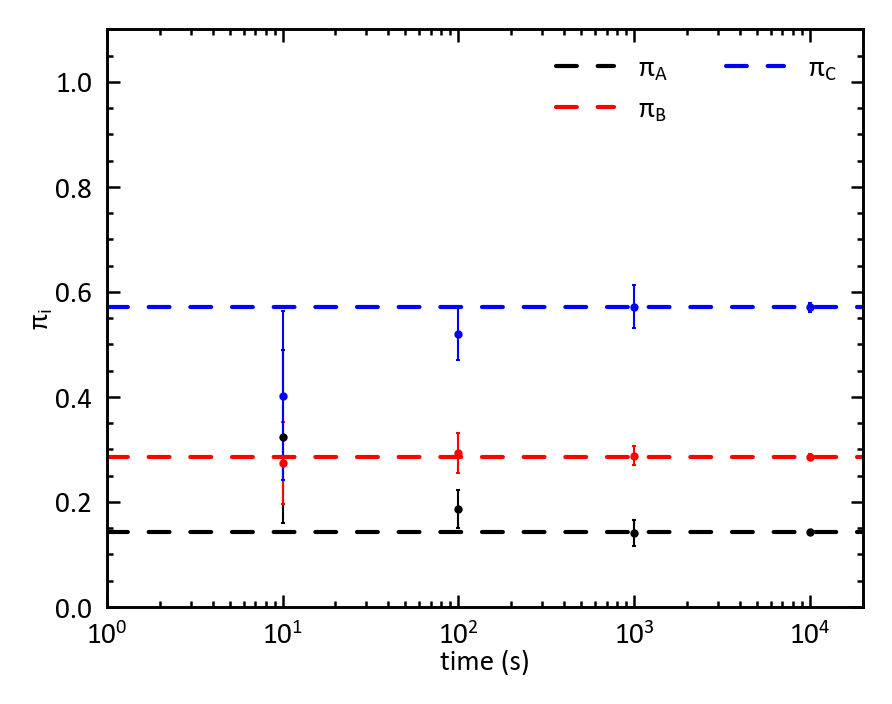

In [76]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, np.nanmean(pi, axis=1).T[0], yerr=np.nanstd(pi, axis=1).T[0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(pi, axis=1).T[1], yerr=np.nanstd(pi, axis=1).T[1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(pi, axis=1).T[2], yerr=np.nanstd(pi, axis=1).T[2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(piA, 1, 20000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$\pi_A$', 
           capstyle='round', joinstyle='miter')
plt.hlines(piB, 1, 20000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$\pi_B$', 
           capstyle='round', joinstyle='miter')
plt.hlines(piC, 1, 20000, colors=colorList[2], linestyles=(0, (5,5)), label=r'$\pi_C$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$\pi_i$')
plt.xlim([1,20000])
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [77]:
fig.savefig("3state_pi.png")

In [99]:
estimates

[[[[0.004365623046920769,
    0.32030405105623405,
    1.0440181205657904,
    0.40147146958202273,
    5.777592737544332,
    0.4058370926289435,
    6.821610858110122],
   [0.2, 0.8],
   [0.0007550422840600237, 0.27698578152980713, 0.7222591761861329],
   [0.17295178166896066, 0.6918071266758427],
   [229.06237878355896,
    2.497626855988619,
    0.6244067139971547,
    0.9578377810703751]],
  [[nan,
    0.17198714461661013,
    0.860633850360883,
    0.17198714461661013,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.1665539878165645, 0.8334460121834354],
   [0.0, 0.9684095179778867],
   [nan, 5.814388059230692, 0.0, 1.1619343110669857]],
  [[nan,
    0.2396171970354765,
    0.1748509309840442,
    0.2396171970354765,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.5781317810381573, 0.4218682189618427],
   [0.0, 2.41273075635119],
   [nan, 4.173323168670341, 0.0, 5.719157423824376]]],
 [[[0.8451161260754486,
    0.3426134820206673,
    0.9165701534004194,
    0.5688476

In [68]:
flux = []
for i in estimates:
    for j in i:
        flux.append(j[3])

In [69]:
flux = np.reshape(np.nan_to_num(np.array(flux), nan=np.nan, posinf=np.nan, neginf=np.nan), 
                  newshape=(4,3,2))

In [71]:
flux

array([[[0.        , 0.68698729],
        [0.16014884, 0.48044651],
        [0.        , 0.74937031]],

       [[0.11264781, 0.59140099],
        [0.12354672, 0.49418687],
        [0.25491587, 0.38237381]],

       [[0.1426944 , 0.61480035],
        [0.15095831, 0.50981534],
        [0.16951989, 0.57906795]],

       [[0.13947301, 0.57710003],
        [0.14484142, 0.57705515],
        [0.14513694, 0.58346216]]])

In [72]:
np.nanmean(flux[0], axis=0)

array([0.05338295, 0.6389347 ])

In [73]:
np.nanstd(flux[0], axis=0)

array([0.07549489, 0.11492546])

In [106]:
np.nanmean(pi, axis=1).T[0]

array([0.00025168, 0.12810964, 0.15354761, 0.14516131])

In [74]:
print(J_AB, J_BC)

0.14285714285714285 0.5714285714285716


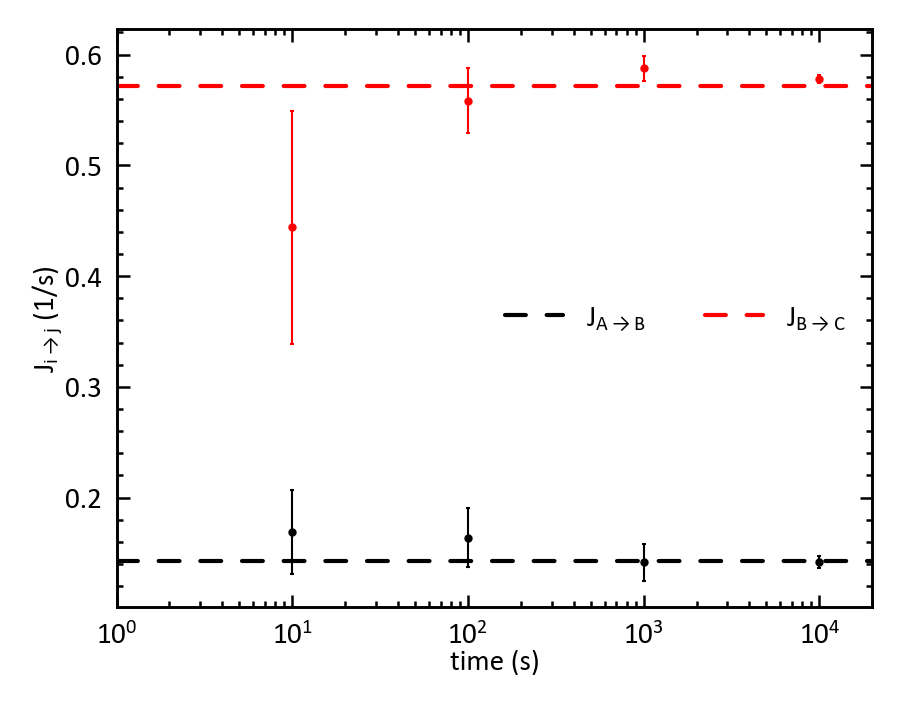

In [83]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, np.nanmean(flux, axis=1).T[0], yerr=np.nanstd(flux, axis=1).T[0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(flux, axis=1).T[1], yerr=np.nanstd(flux, axis=1).T[1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(J_AB, 1, 20000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$J_{A \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(J_BC, 1, 20000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$J_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$J_{i \rightarrow j}$ (1/s)')
plt.xlim([1,20000])
# plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [84]:
fig.savefig("3state_flux.png")

In [109]:
estimates

[[[[0.004365623046920769,
    0.32030405105623405,
    1.0440181205657904,
    0.40147146958202273,
    5.777592737544332,
    0.4058370926289435,
    6.821610858110122],
   [0.2, 0.8],
   [0.0007550422840600237, 0.27698578152980713, 0.7222591761861329],
   [0.17295178166896066, 0.6918071266758427],
   [229.06237878355896,
    2.497626855988619,
    0.6244067139971547,
    0.9578377810703751]],
  [[nan,
    0.17198714461661013,
    0.860633850360883,
    0.17198714461661013,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.1665539878165645, 0.8334460121834354],
   [0.0, 0.9684095179778867],
   [nan, 5.814388059230692, 0.0, 1.1619343110669857]],
  [[nan,
    0.2396171970354765,
    0.1748509309840442,
    0.2396171970354765,
    inf,
    nan,
    inf],
   [0.0, 1.0],
   [0.0, 0.5781317810381573, 0.4218682189618427],
   [0.0, 2.41273075635119],
   [nan, 4.173323168670341, 0.0, 5.719157423824376]]],
 [[[0.8451161260754486,
    0.3426134820206673,
    0.9165701534004194,
    0.5688476

In [85]:
rate = []
for i in estimates:
    for j in i:
        rate.append(j[4])

In [86]:
rate = np.reshape(np.nan_to_num(np.array(rate), nan=np.nan, posinf=np.nan, neginf=np.nan), 
                  newshape=(4,3,4))

In [79]:
rate

array([[[       nan, 3.03437885, 0.        , 0.88804089],
        [1.37334104, 1.62649803, 0.54216601, 0.81708542],
        [       nan, 1.94421049, 0.        , 1.2193544 ]],

       [[0.91157827, 2.01398078, 0.38361539, 1.01479679],
        [0.78346829, 2.07515844, 0.51878961, 0.81796836],
        [1.00298254, 1.11643442, 0.74428961, 0.94800298]],

       [[1.28099999, 2.09057876, 0.48522075, 1.03410238],
        [0.86858126, 1.89210086, 0.56025844, 0.91568697],
        [1.13185545, 1.84977275, 0.54151379, 1.07797715]],

       [[1.00142381, 2.05720879, 0.49718434, 0.99465785],
        [1.02504337, 2.00597146, 0.50350084, 1.01055385],
        [1.04132998, 1.9772264 , 0.49183754, 1.03170448]]])

In [80]:
np.nanmean(flux[0], axis=0)

array([0.05338295, 0.6389347 ])

In [115]:
np.nanstd(flux[0], axis=0)

array([0.08153025, 0.75455291])

In [116]:
np.nanmean(pi, axis=1).T[0]

array([0.00025168, 0.12810964, 0.15354761, 0.14516131])

In [81]:
print(k_AB, k_BC, k_BA, k_CB)

1 2 0.5 1


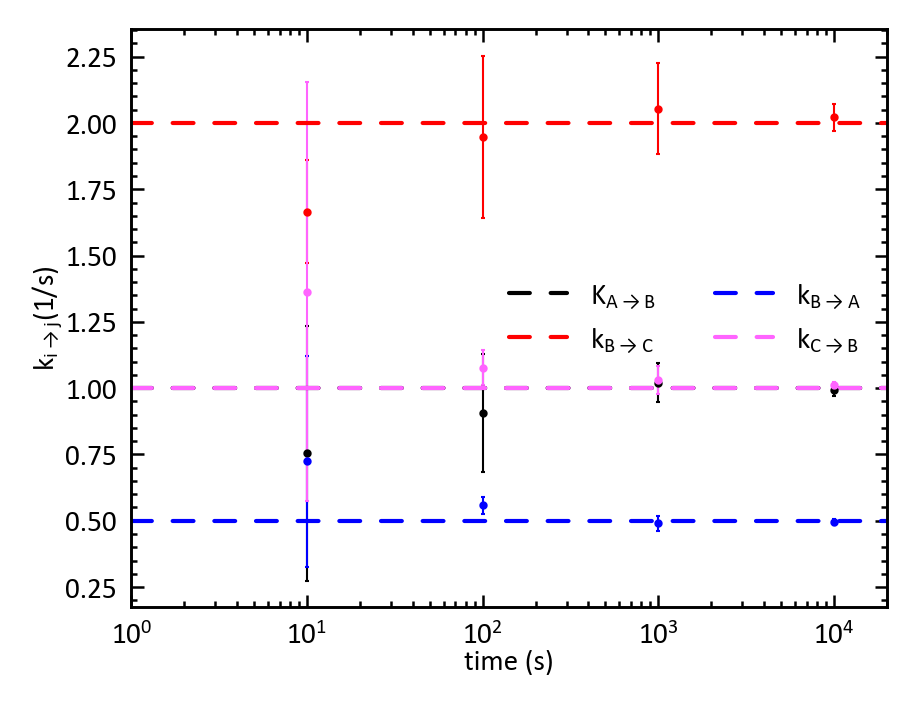

In [90]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, np.nanmean(rate, axis=1).T[0], yerr=np.nanstd(rate, axis=1).T[0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(rate, axis=1).T[1], yerr=np.nanstd(rate, axis=1).T[1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(rate, axis=1).T[2], yerr=np.nanstd(rate, axis=1).T[2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, np.nanmean(rate, axis=1).T[3], yerr=np.nanstd(rate, axis=1).T[3], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(k_AB, 1, 20000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$K_{A \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_BC, 1, 20000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$k_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_BA, 1, 20000, colors=colorList[2], linestyles=(0, (5,5)), label=r'$k_{B \rightarrow A}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_CB, 1, 20000, colors=colorList[3], linestyles=(0, (5,5)), label=r'$k_{C \rightarrow B}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$k_{i \rightarrow j} (1/s)$')
plt.xlim([1,20000])
# plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [88]:
fig.savefig("3state_rates.png")

## MSM

$A \leftrightharpoons B \leftrightharpoons C$ \
k$_{A \rightarrow B} = 1/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{C \rightarrow B} = 1/step$

Shorter lagtimes resolves the timescales better espeically the second faster timescale. However, the timescales, fluxs, mfpts, and rates all do not make any sense. Also, more sampling does not seem to affect the final resuslt either.

In [52]:
lagtime = 0.2
Prob_t(eig_val, eig_vec, lagtime)

array([[0.82621805, 0.14383277, 0.02994918],
       [0.07191639, 0.64041807, 0.28766554],
       [0.0074873 , 0.14383277, 0.84867993]])

In [53]:
MSM_true = dt.markov.msm.MarkovStateModel(Prob_t(eig_val, eig_vec, lagtime))

In [54]:
traj_discretized = MSM_true.simulate(40000)

In [17]:
lagtime = 0.2
MSM_true, traj_discrete = MSMtraj(20000, Prob_t(3, eig_val, eig_vec, lagtime))

In [17]:
lagtime = 1
MSM_true, traj_discrete = MSMtraj(20000, Prob_t(3, eig_val, eig_vec, lagtime))

In [21]:
traj

array([[0.66562241, 2.        ],
       [0.06949356, 1.        ],
       [1.47455454, 2.        ],
       ...,
       [0.5203397 , 1.        ],
       [5.69246525, 2.        ],
       [0.8770206 , 1.        ]])

In [22]:
traj_discrete_step = traj[:,0] // lagtime
traj_discrete_step = traj_discrete_step.astype(np.int32)
print(traj_discrete_step.shape)

traj_discretized2 = []
for state, repeat in zip(traj[:,1].astype(np.int32), traj_discrete_step):
    # print(state, type(state))
    # print(repeat, type(repeat))
    traj_discretized2 = np.concatenate((traj_discretized2, np.repeat(state, repeat)))

traj_discretized2 = traj_discretized2.astype(np.int32)

(10000,)


In [23]:
traj[:,1][:20].astype(np.int32)

array([2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1])

In [24]:
traj_discrete_step[:20]

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 4, 0, 4, 0, 0, 0, 0, 0])

In [25]:
traj_discretized2[:13]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1])

In [26]:
traj_discrete[:13]

array([0, 0, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1])

In [27]:
traj_discrete.shape

(20000,)

In [28]:
traj_discretized2.shape

(3416,)

In [29]:
traj[:,0].sum()

7054.746471813055

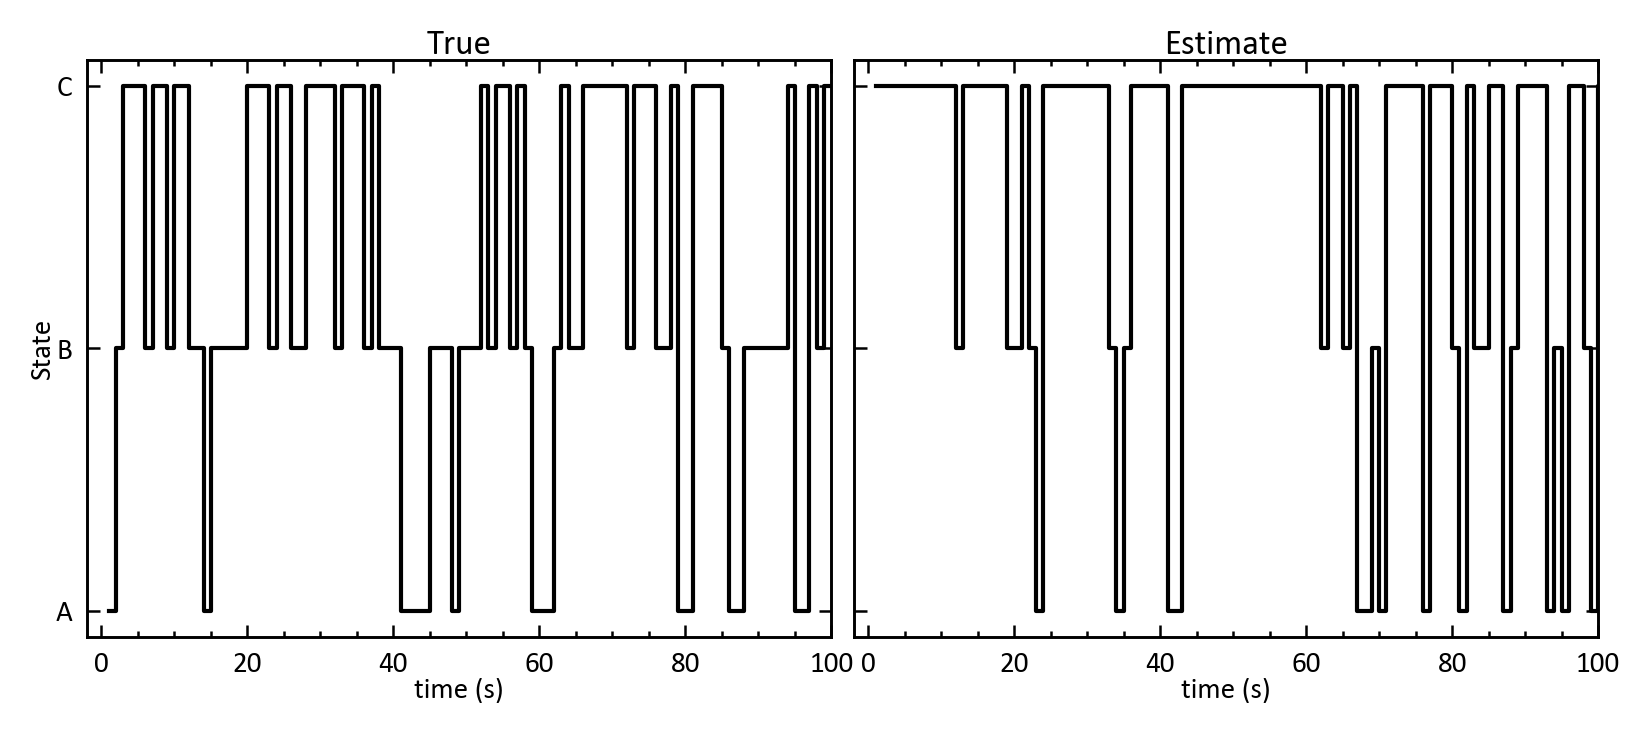

In [30]:
fig, axs = plt.subplots(1,2, figsize=(2*3.25, 2.5),
                        sharex=True, sharey=True)
# fig.tight_layout()
plt.subplots_adjust(wspace=0.03)

axs[0].plot(np.arange(1, traj_discrete.shape[0]+1)*lagtime, 
            traj_discrete, drawstyle='steps')
axs[1].plot(np.arange(1, traj_discretized2.shape[0]+1)*lagtime, 
            traj_discretized2, drawstyle='steps')

axs[0].set_title("True")
axs[1].set_title("Estimate")
axs[0].tick_params(axis='y', which='minor', left=False, right=False)
axs[1].tick_params(axis='y', which='minor', left=False, right=False)
axs[0].set_yticks([0,1,2], ['A', 'B', 'C'])
axs[1].set_yticks([0,1,2], ['A', 'B', 'C'])
axs[0].set_xlabel('time (s)')
axs[1].set_xlabel('time (s)')
axs[0].set_ylabel('State')
axs[0].set_xlim([-2, 100])
axs[1].set_xlim([-2, 100])
# plt.xlim([0, 10])
# plt.legend(ncols=2)

plt.show()

In [106]:
fig.savefig("3state_msm_sim.png", dpi=300)

In [31]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [32]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[1320.,  815.,  780.],
       [ 802., 1691., 3149.],
       [ 792., 3137., 7513.]])

In [33]:
count_estimator.fit(traj_discretized2).fetch_model().count_matrix

array([[ 244.,   82.,  268.],
       [ 196.,  108.,  197.],
       [ 154.,  311., 1855.]])

In [34]:
t_CA

7.0

The time to get from C to A is very long that is why we do not get counts for C to A in the second approach

In [35]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [36]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=np.array([piA, piB, piC])
)

In [37]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM3 = MSM_estimator.fit(count_estimator.fit(traj_discretized2).fetch_model()).fetch_model()
MSM4 = MSM_estimator2.fit(count_estimator.fit(traj_discretized2).fetch_model()).fetch_model()

In [71]:
print(MSM_true.transition_matrix)
print(MSM.transition_matrix - MSM_true.transition_matrix)
print(MSM2.transition_matrix - MSM_true.transition_matrix)
print(MSM3.transition_matrix - MSM_true.transition_matrix)
print(MSM4.transition_matrix - MSM_true.transition_matrix)

[[0.82621805 0.14383277 0.02994918]
 [0.07191639 0.64041807 0.28766554]
 [0.0074873  0.14383277 0.84867993]]
[[ 3.42683784e-03 -2.39881753e-03 -1.02802031e-03]
 [-3.50387943e-04 -6.02293855e-04  9.52681798e-04]
 [-5.55349267e-05  2.73776571e-03 -2.68223078e-03]]
[[ 0.00243855 -0.00181231 -0.00062624]
 [-0.00090615 -0.00215634  0.00306249]
 [-0.00015656  0.00153124 -0.00137468]]
[[-0.00374897  0.00280541  0.00094356]
 [ 0.01792318  0.01325047 -0.03117365]
 [ 0.00079846 -0.03154598  0.03074752]]
[[-0.01992218  0.01836488  0.0015573 ]
 [ 0.00918244  0.03638745 -0.04556988]
 [ 0.00038933 -0.02278494  0.02239562]]


In [137]:
a, b

(-0.013976682466132734, 0.011750415588215324)

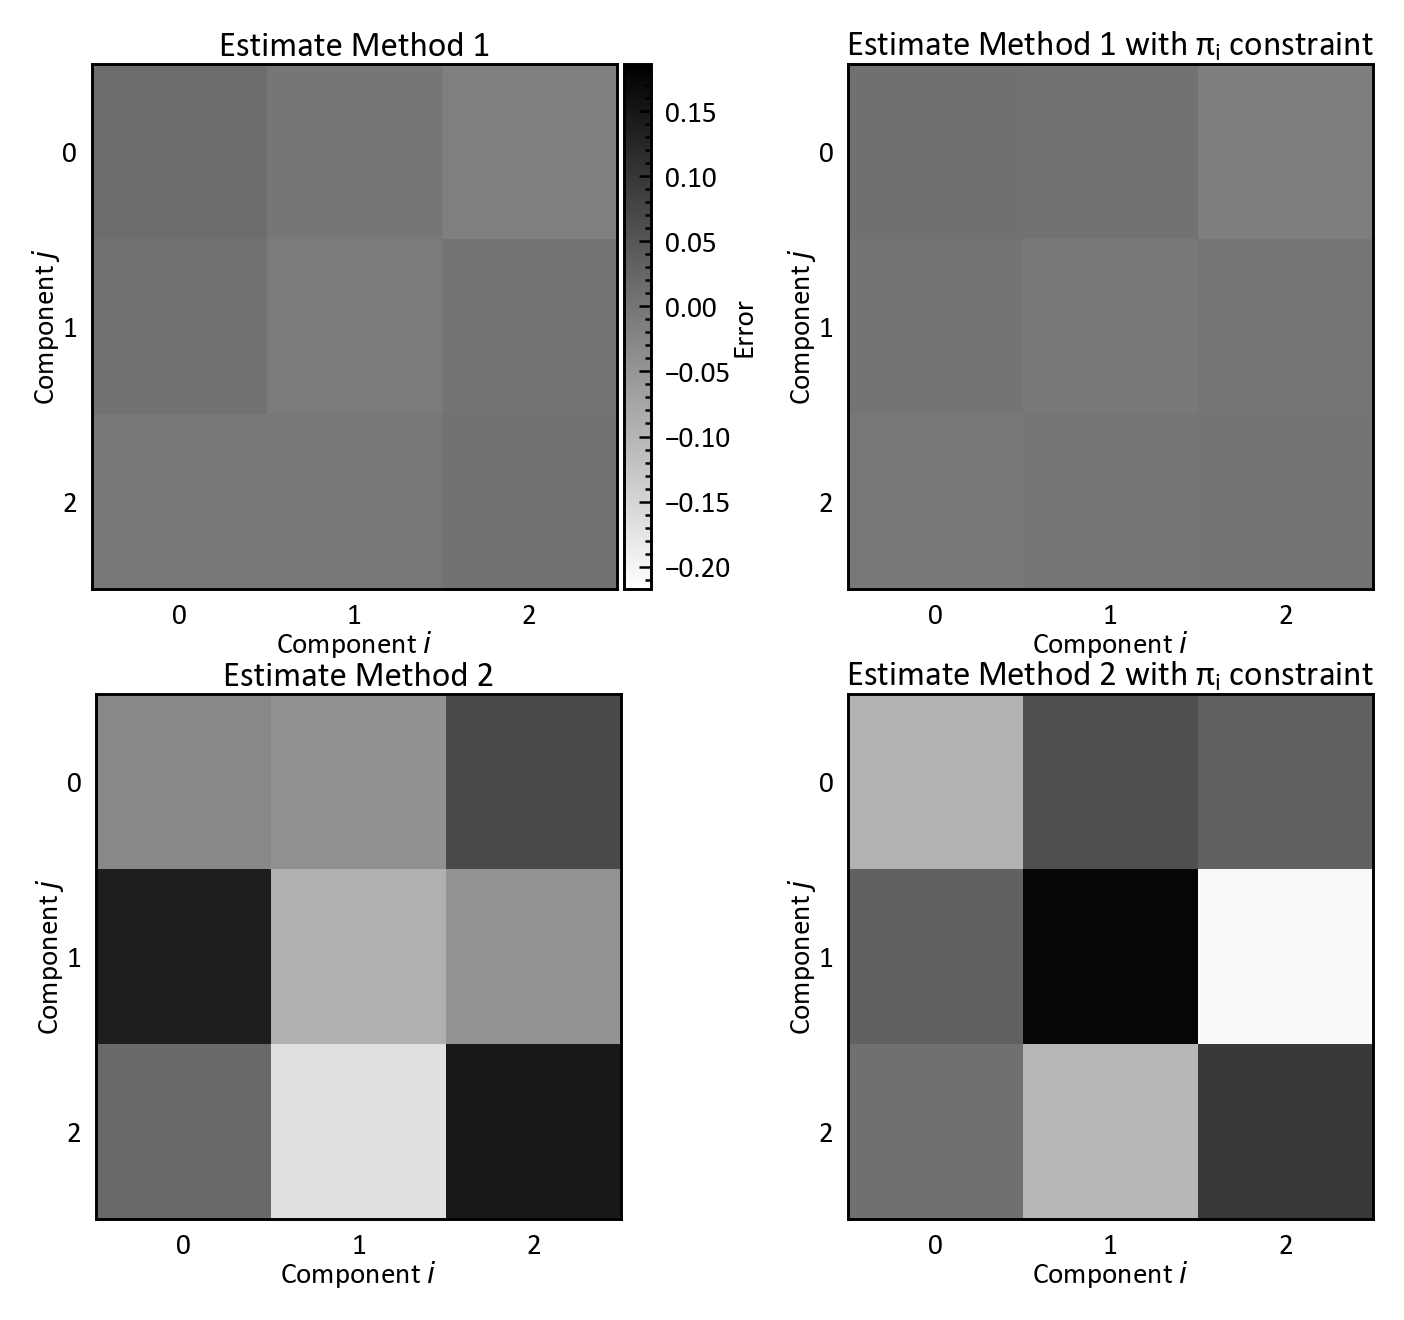

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(2*3.25, 2*2.5))
# fig.tight_layout()
# plt.subplots_adjust(wspace=0.)
plt.subplots_adjust(wspace=-0.01)

a = np.min([MSM.transition_matrix - MSM_true.transition_matrix,
            MSM2.transition_matrix - MSM_true.transition_matrix,
            MSM3.transition_matrix - MSM_true.transition_matrix,
            MSM4.transition_matrix - MSM_true.transition_matrix])
b = np.max([MSM.transition_matrix - MSM_true.transition_matrix,
            MSM2.transition_matrix - MSM_true.transition_matrix,
            MSM3.transition_matrix - MSM_true.transition_matrix,
            MSM4.transition_matrix - MSM_true.transition_matrix])

pos = axs[0,0].imshow(MSM.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)
axs[0,1].imshow(MSM2.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)
axs[1,0].imshow(MSM3.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)
axs[1,1].imshow(MSM4.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)

fig.colorbar(pos, ax=axs[0,0], pad=0.01, label=r"Error")

titles = [r"Estimate Method 1", r"Estimate Method 1 with $\pi_i$ constraint", 
          r"Estimate Method 2", r"Estimate Method 2 with $\pi_i$ constraint"]
count = 0
for i in axs:
    for j in i:
        j.set_title(titles[count], pad=2)
        count += 1
        j.set_xlabel(r"Component $\it{i}$")
        j.set_ylabel(r"Component $\it{j}$")
        j.set_xticks([0,1,2])
        j.set_yticks([0,1,2])
        j.tick_params(axis='both', which='both', bottom=False, 
                        top=False, left=False, right=False)

plt.show()

In [121]:
fig.savefig("3state_msm_error.png")

In [39]:
models = []
models2 = []
models3 = []
models4 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models3.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discretized2)))
    models4.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discretized2)))

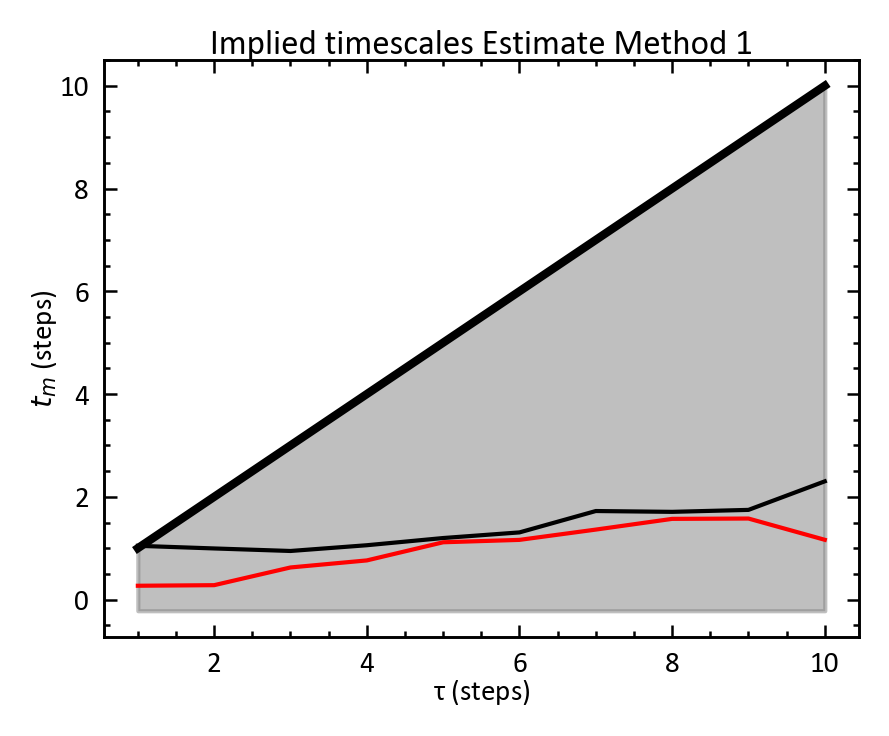

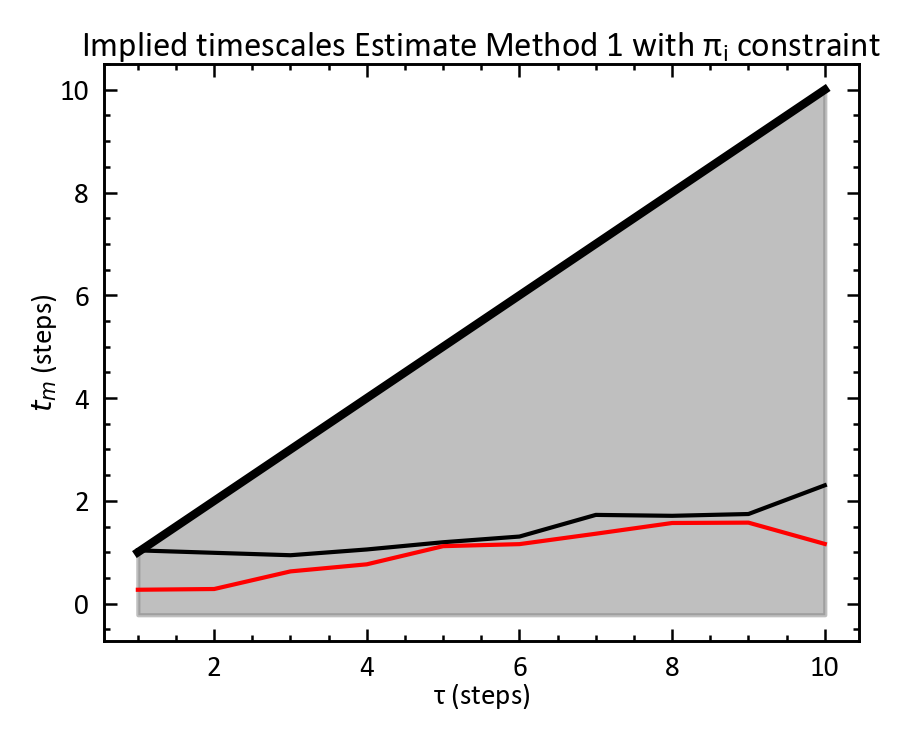

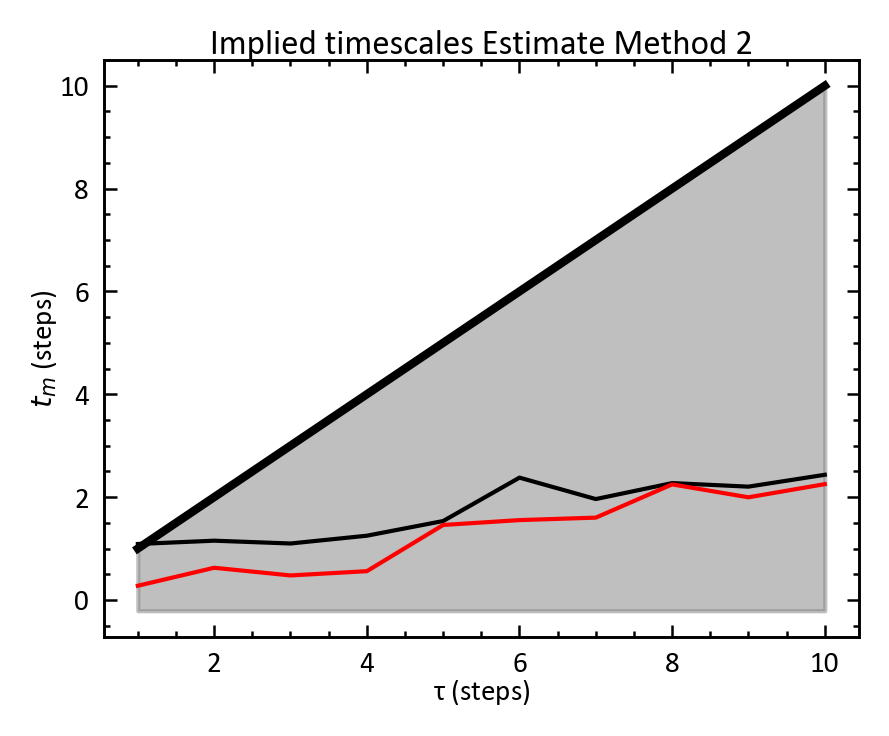

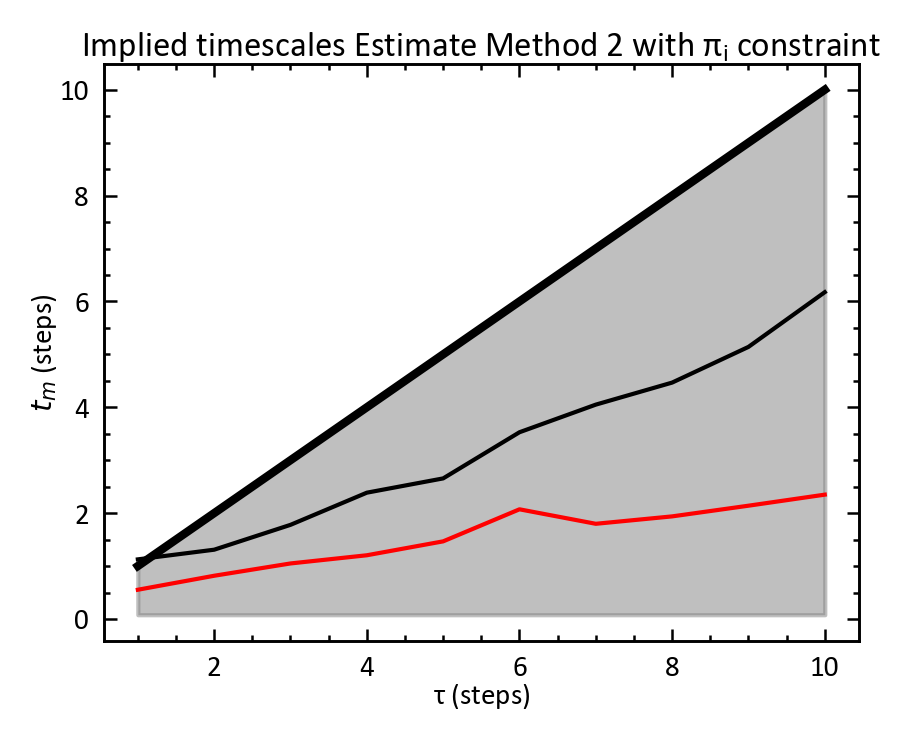

In [40]:
temp = [models, models2, models3, models4]
for i in range(4):
    fig, ax = plt.subplots(1,1)
    dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(temp[i]))
    
    ax.set_title("Implied timescales " + titles[i])
    ax.set_xlabel(r"$\tau$ (steps)")
    ax.set_ylabel(r"$\it{t}_m$ (steps)")

    fig.savefig(f"3state_its_model{i+1}_1s.png")
    plt.show()

Above I think shows that the shorter timescale is too fast for the lagtimes being considered. May actually get better resuslts with lower timescale. **Yes** the lagtime improves the observation of the second fast mode.

In [41]:
np.exp(eig_val*lagtime)

array([0.03019738, 0.36787944, 1.        ])

In [42]:
eig_vec

array([[-1.54303350e-01, -7.07106781e-01,  2.18217890e-01],
       [ 7.71516750e-01,  9.40257721e-17,  4.36435780e-01],
       [-6.17213400e-01,  7.07106781e-01,  8.72871561e-01]])

In [43]:
print(MSM_true.eigenvalues())

[1.         0.36787944 0.03019738]


In [45]:
print(piA, piB, piC)

0.14285714285714285 0.2857142857142858 0.5714285714285714


In [44]:
MSM_true.eigenvectors_left()

array([[ 1.42857143e-01,  2.85714286e-01,  5.71428571e-01],
       [-3.38061702e-01,  3.52419268e-18,  3.38061702e-01],
       [ 9.03507903e-02, -4.51753951e-01,  3.61403161e-01]])

In [46]:
MSM_true.eigenvectors_right().T

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [-2.36643191e+00,  1.23346744e-17,  5.91607978e-01],
       [ 6.32455532e-01, -1.58113883e+00,  6.32455532e-01]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [47]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

2

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

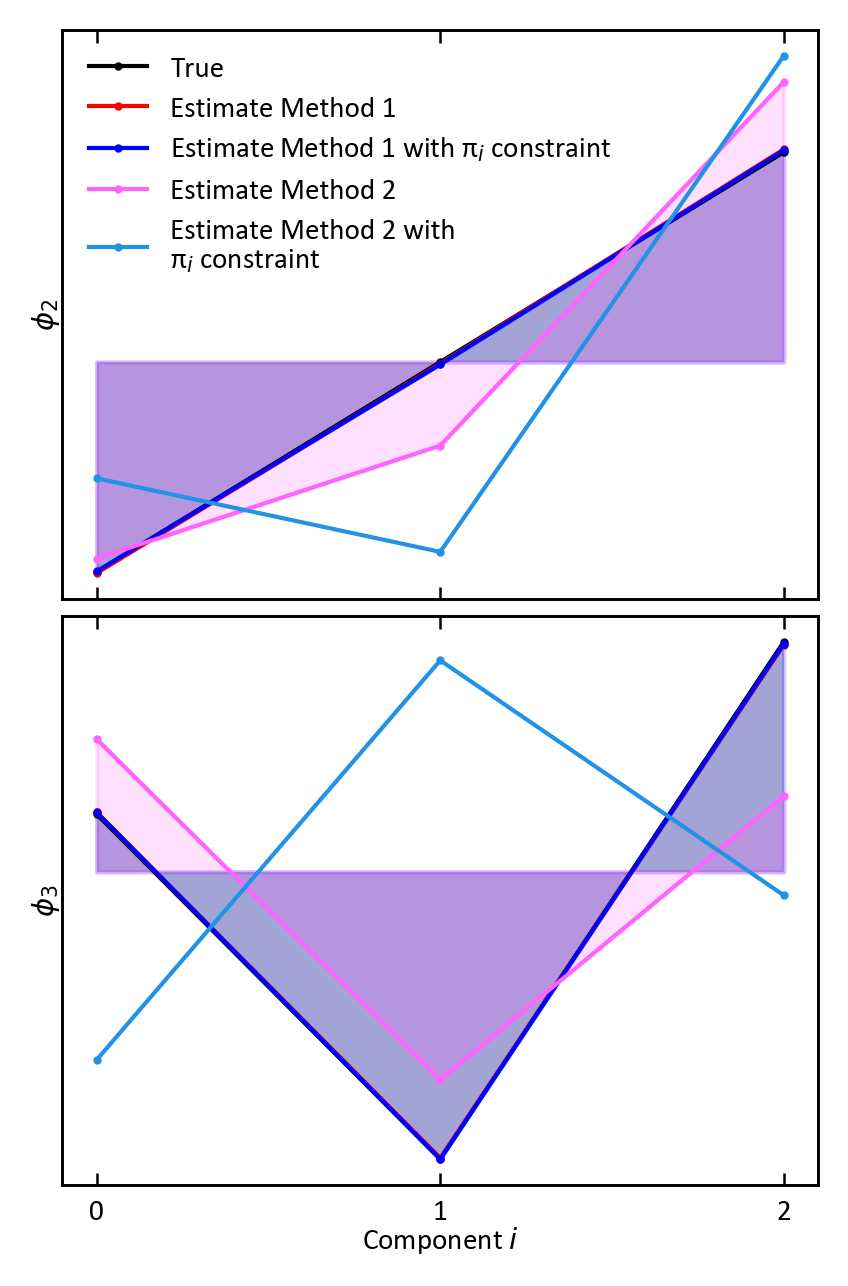

In [48]:
fig, axs = plt.subplots(2,1, figsize=(1*3.25, 2*2.5),
                        sharex=True, sharey=False)

# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con, esti2, esti2_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), 
                                           MSM2.eigenvectors_left(), MSM3.eigenvectors_left(), MSM4.eigenvectors_left())
comps = np.array([0,1,2])

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")
axs[0].plot(esti2[1], 'o-', label="Estimate Method 2")
axs[0].plot(esti2_con[1], 'o-', label="Estimate Method 2 with\n" r"$\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
# axs[0].fill_between(comps, esti1[1], alpha=0.2)
axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])
axs[0].fill_between(comps, esti2[1], alpha=0.2, color=colorList[3])
# axs[0].fill_between(comps, esti2_con[1], alpha=0.2, color=colorList[4])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")
axs[1].plot(esti2[2], 'o-', label="Estimate Method 2")
axs[1].plot(esti2_con[2], 'o-', label=r"Estimate Method 2 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
# axs[1].fill_between(comps, esti1[2], alpha=0.2)
axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])
axs[1].fill_between(comps, esti2[2], alpha=0.2, color=colorList[3])
# axs[1].fill_between(comps, esti2_con[2], alpha=0.2, color=colorList[4])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[1].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
axs[0].legend()

plt.show()

In [49]:
fig.savefig("3state_left_eigenfxn_1s.png")

Notice that the two slow modes are the following processes:
1. A $\rightarrow$ C
2. A $\leftarrow$ B $\rightarrow$ C

In [55]:
t_BC

0.75

In [50]:
print(t_AC, t_ABC, (t_BA + t_BC) /2, 1/k_AB, t_BA, t_BC, 1/k_CB, t_CA)

1.75 0.4 3.375 1.0 6.0 0.75 1.0 7.0


In [51]:
a = 1/np.linalg.norm(true[2]) * true[2]
print(a[0] * t_BA + a[1] * t_BC)
print(phi_ba * t_BA + phi_bc * t_BC)

0.34718253741470717
1.8000000000000003


In [52]:
phi_ba, phi_bc

(0.2, 0.8)

In [53]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())
print(MSM3.timescales())
print(MSM4.timescales())

[1.         0.28571429]
[1.04687026 0.26942514]
[1.0365733 0.2701424]
[1.08864032 0.27636568]
[1.12644536 0.55212227]


I think that the first impled timescale is an approximate to $\tau_{AC} \approx t_2$ and the second implied time scale is an approximate to $\tau_{A \leftarrow B \rightarrow C} \approx t_3$. OR maybe the t$_2$ is the average of t$_{B \rightarrow A}$ and t$_{B \rightarrow C}$ with weights from the committor

In [139]:
rf = MSM_true.reactive_flux([0], [2])
rf2 = MSM.reactive_flux([0], [2])
rf3 = MSM2.reactive_flux([0], [2])
rf4 = MSM3.reactive_flux([0], [2])
rf5 = MSM4.reactive_flux([0], [2])

In [54]:
print(phi_ba, phi_bc)

0.2 0.8


In [93]:
print(rf.backward_committor[np.newaxis,:].shape, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)
print(rf4.backward_committor, rf4.forward_committor)
print(rf5.backward_committor, rf5.forward_committor)

(1, 3) [0.  0.8 1. ]
[1.         0.20546951 0.        ] [0.         0.79453049 1.        ]
[1.         0.20322873 0.        ] [0.         0.79677127 1.        ]
[1.        0.2497462 0.       ] [0.        0.7502538 1.       ]
[1.        0.2587726 0.       ] [0.        0.7412274 1.       ]


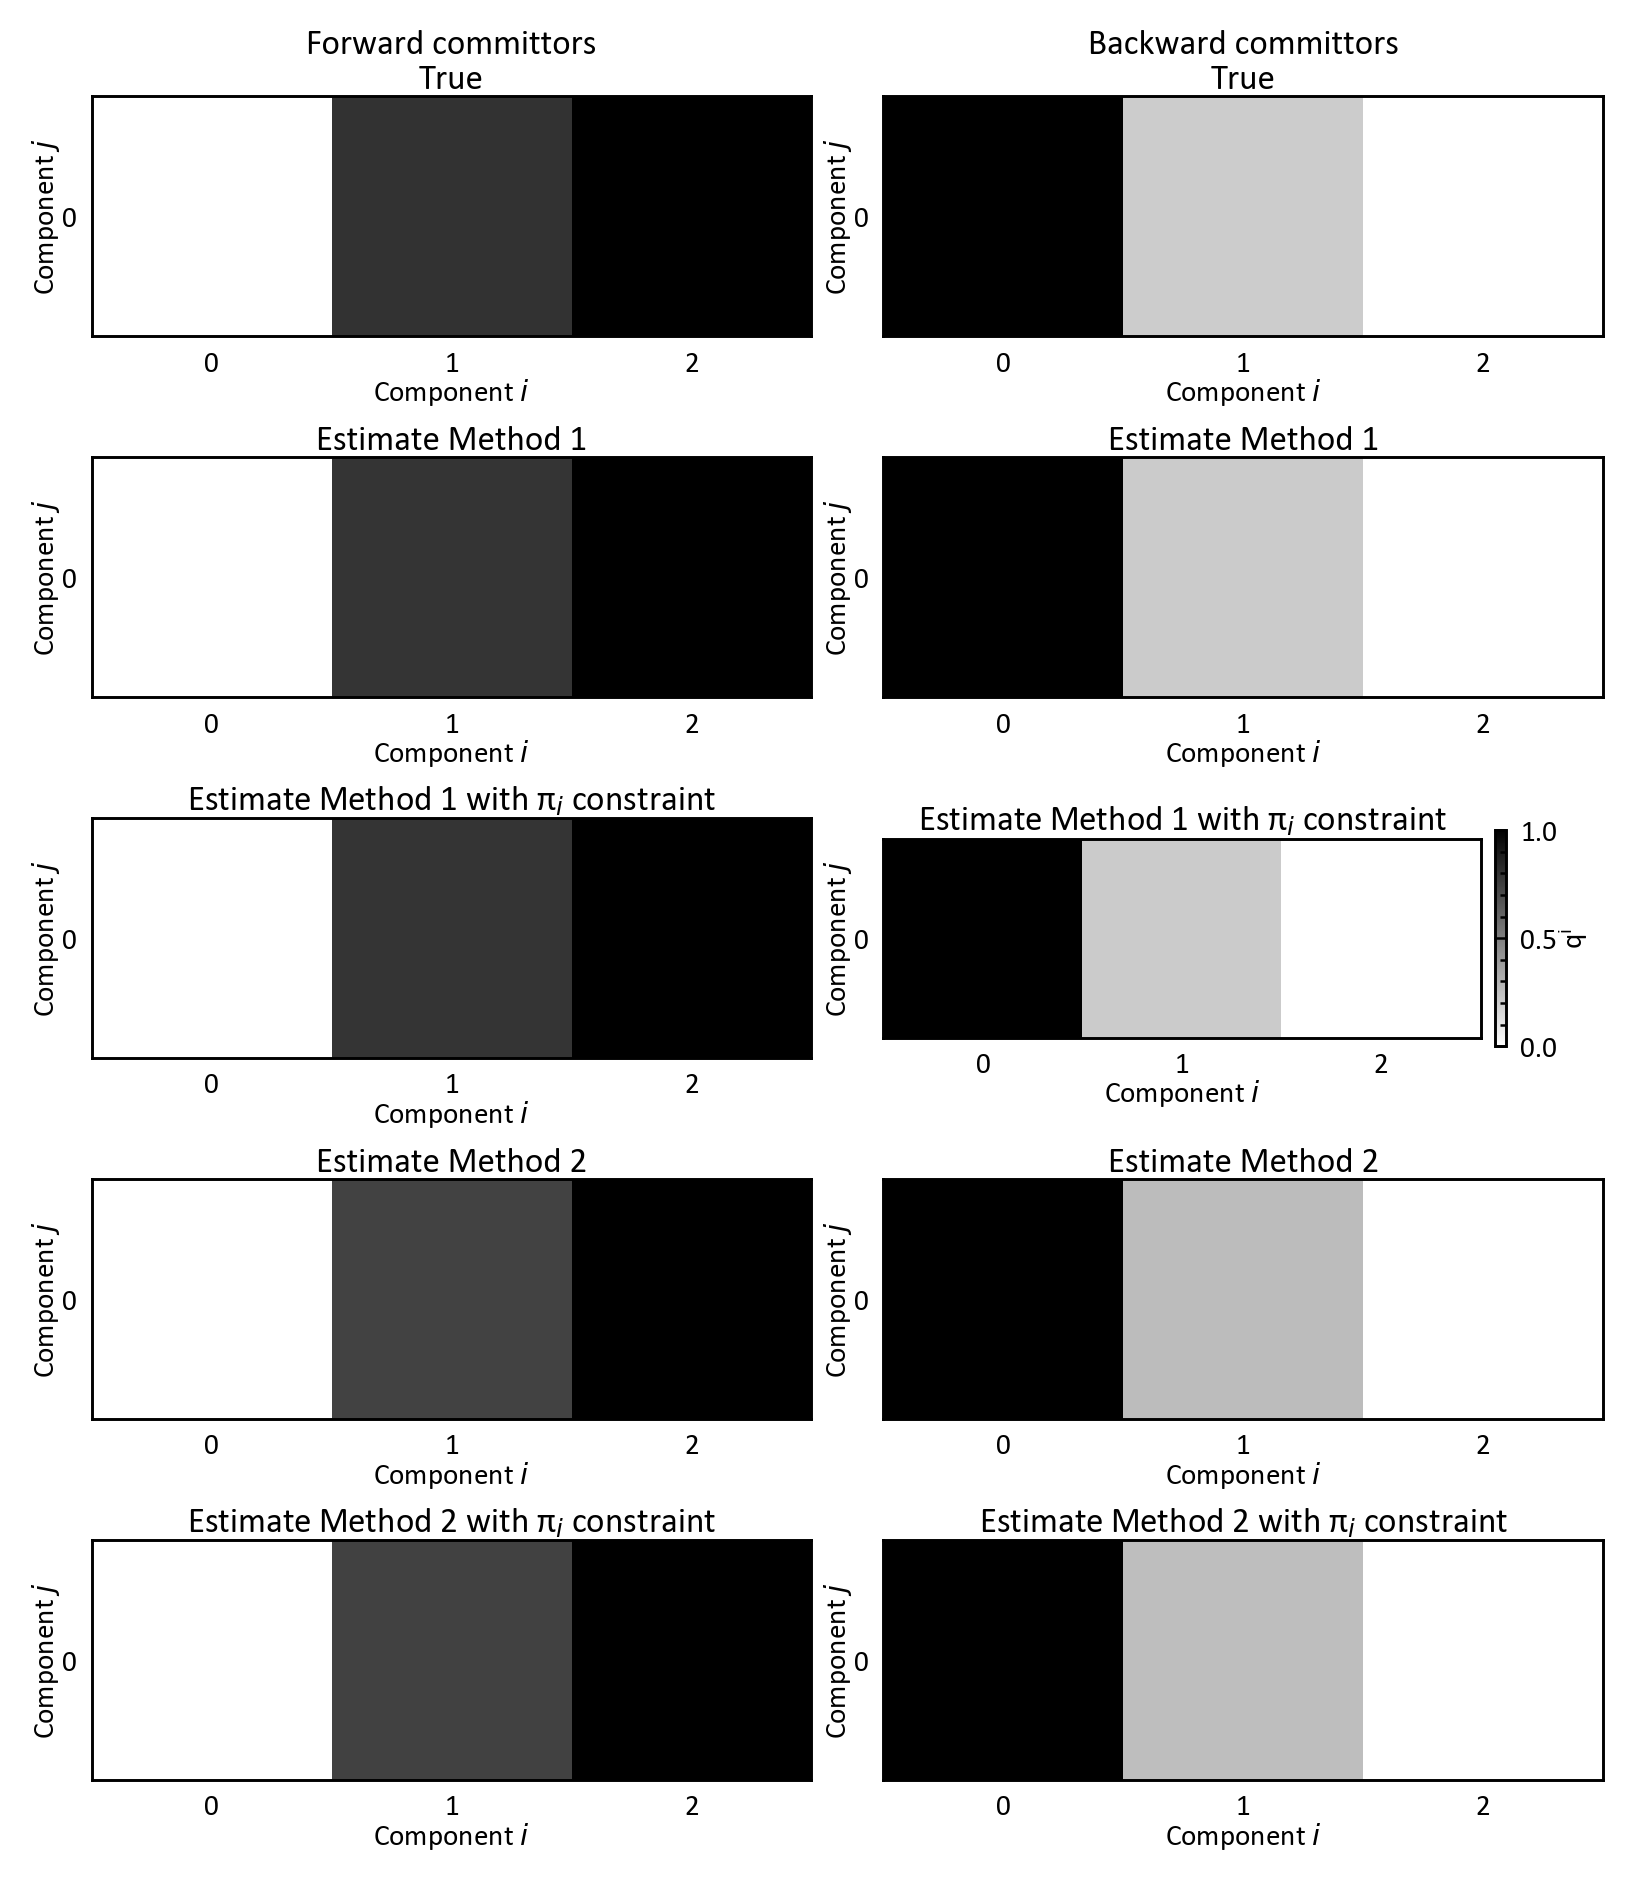

In [140]:
fig, axs = plt.subplots(5, 2, figsize=(2*3.25, 5*2.5))
# fig.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=-0.75)

axs[0,0].imshow(rf.forward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[0,1].imshow(rf.backward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[1,0].imshow(rf2.forward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[1,1].imshow(rf2.backward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[2,0].imshow(rf3.forward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[2,1].imshow(rf3.backward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[3,0].imshow(rf4.forward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[3,1].imshow(rf4.backward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
axs[4,0].imshow(rf5.forward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)
pos = axs[4,1].imshow(rf5.backward_committor[np.newaxis,:], cmap='gray_r', vmin=0, vmax=1)

fig.colorbar(pos, ax=axs[2,1], shrink=0.15, location='right', pad=0.02, label=r"q$^i$")

titles = ["Forward committors\nTrue", "Backward committors\nTrue", 
          r"Estimate Method 1", r"Estimate Method 1",
          r"Estimate Method 1 with $\pi_{\it{i}}$ constraint", r"Estimate Method 1 with $\pi_{\it{i}}$ constraint",
          r"Estimate Method 2", r"Estimate Method 2",
          r"Estimate Method 2 with $\pi_{\it{i}}$ constraint", r"Estimate Method 2 with $\pi_{\it{i}}$ constraint"]
count = 0
for i in axs:
    for j in i:
        j.set_title(titles[count], pad=2)
        count += 1
        j.set_xlabel(r"Component $\it{i}$")
        j.set_ylabel(r"Component $\it{j}$")
        j.set_xticks([0,1,2])
        j.set_yticks([0])
        j.tick_params(axis='both', which='both', bottom=False, 
                        top=False, left=False, right=False)

plt.show()

In [142]:
fig.savefig("3state_rf_committors.png")

Above shows that the splitting probabilities are reproduced. \
I still want to check what the other pairs say (the other reactive pairs that is)

In [143]:
print(t_ABC, 1/k_AB, t_BA, t_BC, 1/k_CB, t_CA, t_AC)

0.4 1.0 6.0 0.75 1.0 7.0 1.75


In [144]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)
print(rf4.mfpt)
print(rf5.mfpt)

9.654147240722262
9.446977294873992
9.369048881823769
10.229160226624444
9.896399244119198


In [145]:
print(1/t_AC, 1/t_CA, k_AB, k_BA, k_BC, k_CB)

0.5714285714285714 0.14285714285714285 1 0.5 2 1


In [146]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)
print(rf4.rate)
print(rf5.rate)

0.10358242681258156
0.1058539645842706
0.10673442017578001
0.09775973568164485
0.10104685303538422


In [147]:
print(piA, piB, piC)

0.14285714285714285 0.2857142857142858 0.5714285714285714


In [148]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)
print(MSM3.stationary_distribution)
print(MSM4.stationary_distribution)

[0.14285714 0.28571429 0.57142857]
[0.14545727 0.28186409 0.57267863]
[0.14285714 0.28571429 0.57142857]
[0.15520644 0.25994629 0.58484727]
[0.14285714 0.28571429 0.57142857]


In [94]:
print(rf.stationary_distribution)
print(rf2.stationary_distribution)
print(rf3.stationary_distribution)
print(rf4.stationary_distribution)
print(rf5.stationary_distribution)

[0.14285714 0.28571429 0.57142857]
[0.15520776 0.28371419 0.56107805]
[0.14285714 0.28571429 0.57142857]
[0.15142836 0.25997017 0.58860147]
[0.14285714 0.28571429 0.57142857]


In [149]:
print(J_AB, J_BC)

0.14285714285714285 0.5714285714285716


In [150]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)
print(rf4.gross_flux)
print(rf5.gross_flux)

[[0.         0.01643803 0.00427845]
 [0.         0.         0.01643803]
 [0.         0.         0.        ]]
[[0.         0.01666048 0.00487524]
 [0.         0.         0.01666048]
 [0.         0.         0.        ]]
[[0.         0.01666275 0.00481494]
 [0.         0.         0.01666275]
 [0.         0.         0.        ]]
[[0.         0.01718437 0.00469308]
 [0.         0.         0.01718437]
 [0.         0.         0.        ]]
[[0.         0.01745146 0.0043901 ]
 [0.         0.         0.01745146]
 [0.         0.         0.        ]]


In [151]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)
print(rf4.net_flux)
print(rf5.net_flux)

[[0.         0.01643803 0.00427845]
 [0.         0.         0.01643803]
 [0.         0.         0.        ]]
[[0.         0.01666048 0.00487524]
 [0.         0.         0.01666048]
 [0.         0.         0.        ]]
[[0.         0.01666275 0.00481494]
 [0.         0.         0.01666275]
 [0.         0.         0.        ]]
[[0.         0.01718437 0.00469308]
 [0.         0.         0.01718437]
 [0.         0.         0.        ]]
[[0.         0.01745146 0.0043901 ]
 [0.         0.         0.01745146]
 [0.         0.         0.        ]]


In [152]:
print(rf.total_flux)
print(rf2.total_flux)
print(rf3.total_flux)
print(rf4.total_flux)
print(rf5.total_flux)

0.020716485362516187
0.021535719993454303
0.021477693606828288
0.021877445453433217
0.021841564033572364


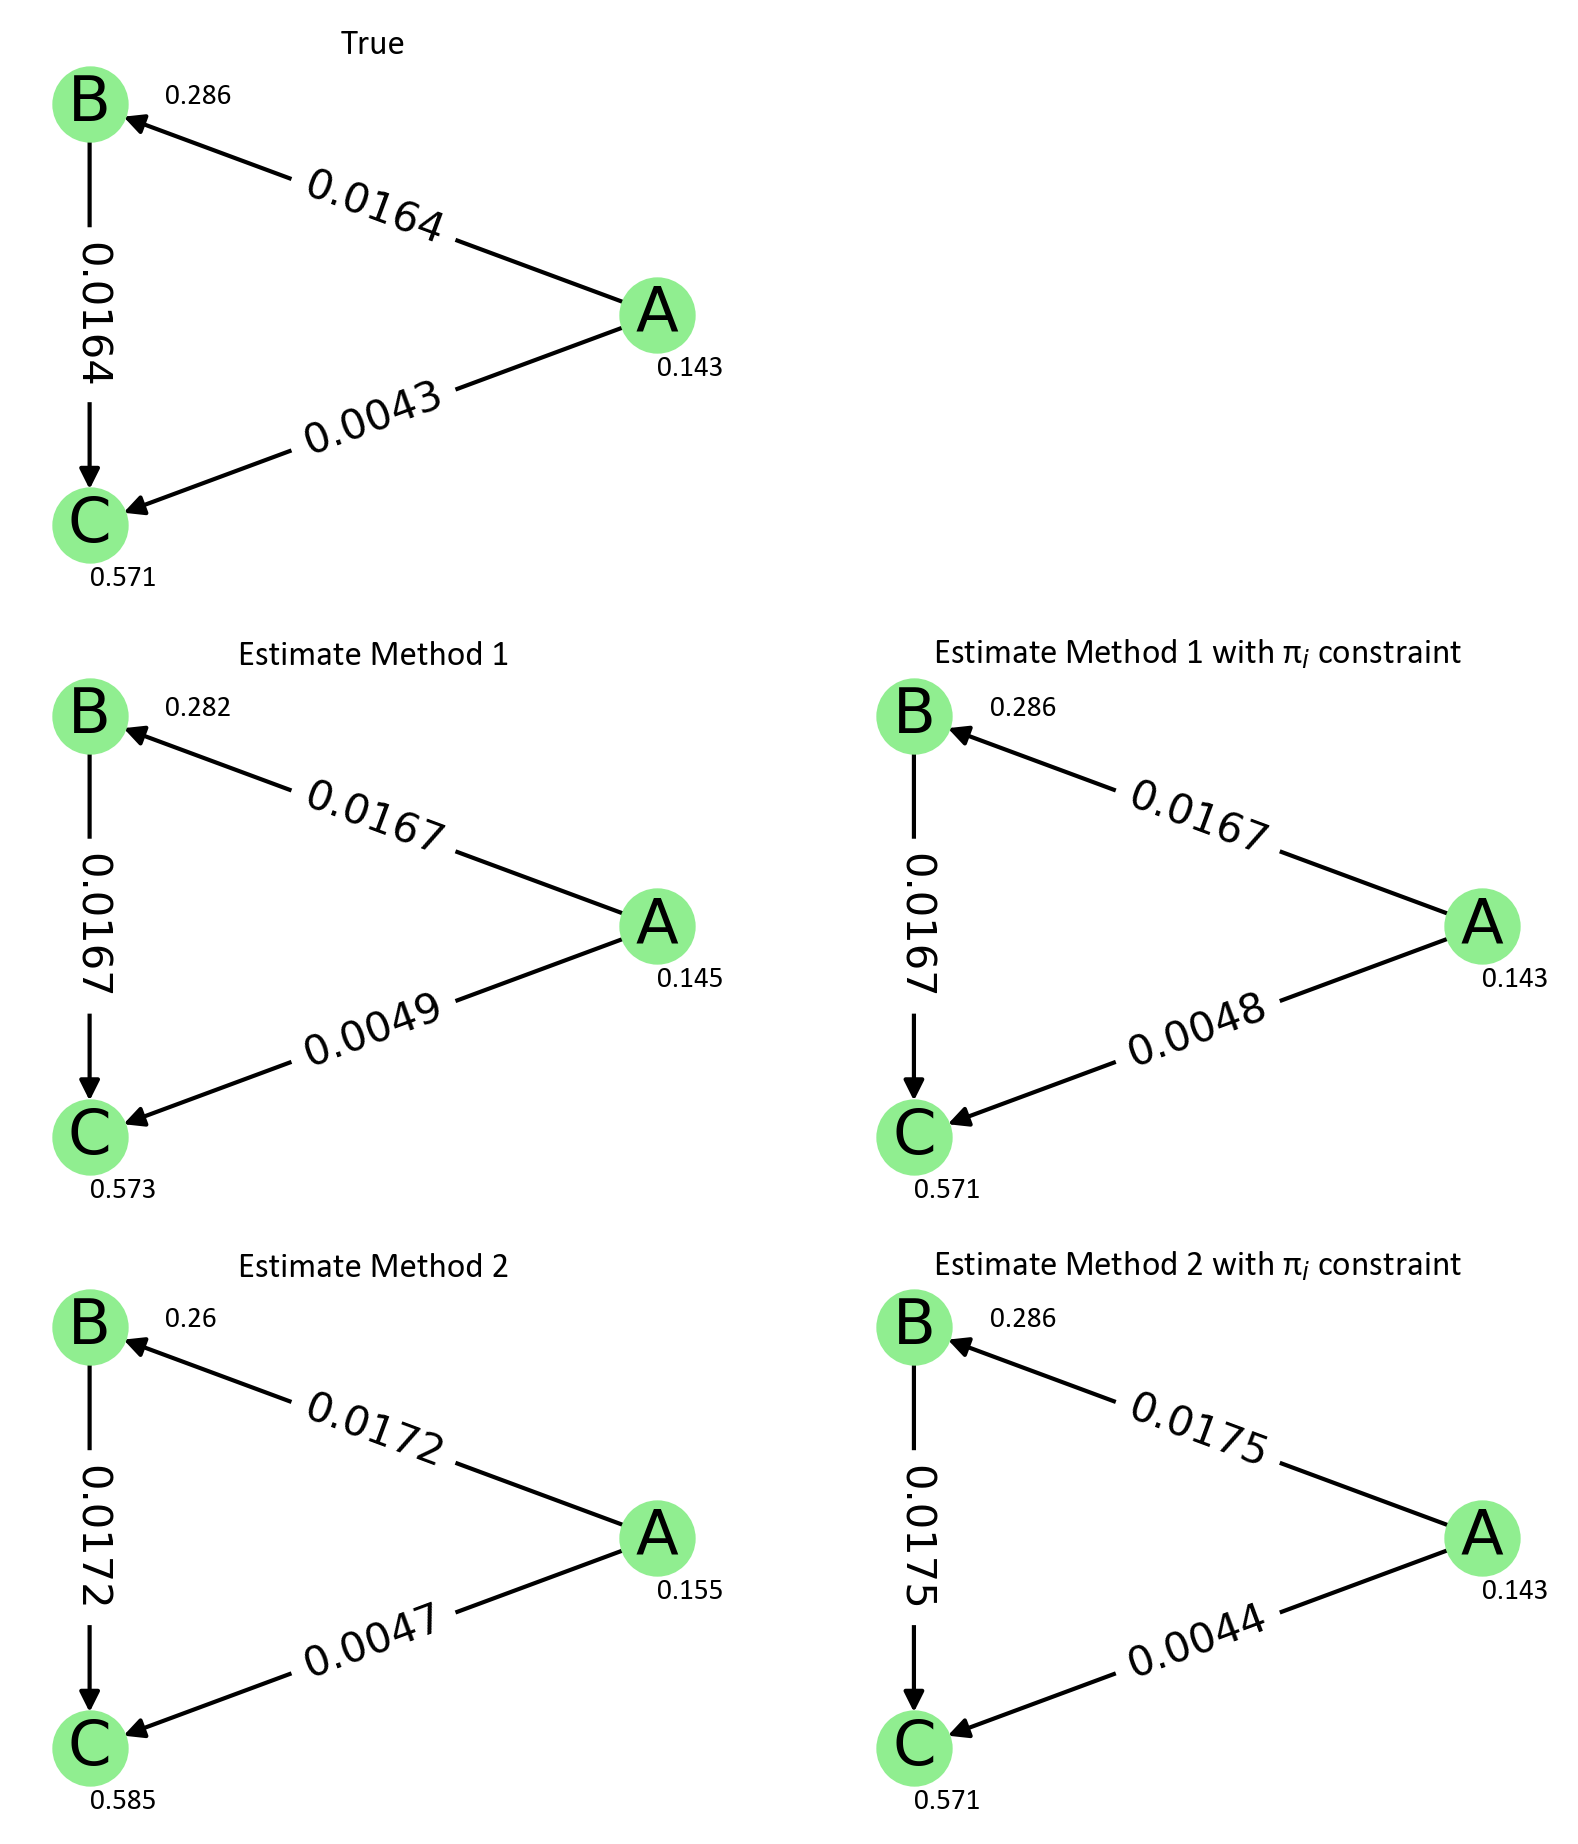

In [153]:
# fig, axs = plt.subplots(2,2, figsize=(2*3.25, 2*2.5))
fig = plt.figure(figsize=(2*3.25,3*2.5))

titles = ["True", r"Estimate Method 1", r"Estimate Method 1 with $\pi_{\it{i}}$ constraint",
          r"Estimate Method 2", r"Estimate Method 2 with $\pi_{\it{i}}$ constraint"]

models = [rf, rf2, rf3, rf4, rf5]
count = 1
for i in range(5):
    ax1 = plt.subplot(3, 2, i+count, title=titles[i])
    G = nx.from_numpy_array(models[i].net_flux, create_using=nx.DiGraph())
    pos = nx.circular_layout(G)
    nx.draw_circular(G, node_color='#90EE90')
    nodeID = ['A', 'B', 'C']
    nx.draw_networkx_labels(G, pos, labels={j: nodeID[j] for j in G.nodes()}, font_size=15)
    for key, p in zip(pos.keys(), models[i].stationary_distribution):
        x, y = pos[key]
        if key == 0:
            y = y - 0.25
        elif key == 1:
            x = x + 0.2
        else:
            y = y - 0.25
        ax1.text(x, y, np.round(p, decimals=3))
    edge_labels = nx.get_edge_attributes(G, "weight")
    for key in edge_labels.keys():
        edge_labels[key] = np.round(edge_labels[key], decimals=4)
    nx.draw_networkx_edge_labels(G, pos, edge_labels)
    if i == 0:
        count += 1

plt.show()

In [154]:
fig.savefig("3state_rf_model.png")

## Counting average duration

In [18]:
traj_discrete.shape

(20000,)

In [100]:
def stateDurations(uniqueStates, traj):
    durations = {i:[] for i in range(uniqueStates)}
    count = 1
    for frame, cond in enumerate(traj[:-1] == traj[1:]):
        if cond:
            count += 1
        else:
            durations[traj[frame]].append(count)
            count = 1
    return durations

In [19]:
traj_discrete[:20]

array([2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2])

In [20]:
state_durations = stateDurations(3, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [177]:
state_durations[2]

[25,
 17,
 9,
 4,
 3,
 4,
 2,
 3,
 2,
 12,
 3,
 25,
 1,
 3,
 9,
 12,
 2,
 2,
 5,
 19,
 2,
 3,
 16,
 11,
 20,
 9,
 3,
 12,
 8,
 9,
 1,
 9,
 26,
 8,
 4,
 14,
 14,
 2,
 2,
 3,
 1,
 11,
 9,
 7,
 8,
 4,
 2,
 16,
 3,
 5,
 3,
 19,
 7,
 4,
 6,
 7,
 1,
 3,
 1,
 4,
 2,
 1,
 3,
 5,
 14,
 6,
 9,
 1,
 12,
 6,
 2,
 3,
 4,
 4,
 3,
 2,
 12,
 3,
 6,
 5,
 1,
 3,
 2,
 2,
 2,
 12,
 3,
 3,
 1,
 2,
 5,
 1,
 3,
 34,
 4,
 1,
 2,
 6,
 7,
 2,
 15,
 9,
 11,
 1,
 3,
 2,
 1,
 17,
 1,
 11,
 2,
 2,
 25,
 7,
 8,
 5,
 10,
 17,
 3,
 2,
 6,
 10,
 14,
 3,
 26,
 1,
 12,
 4,
 2,
 5,
 12,
 6,
 5,
 1,
 2,
 6,
 10,
 7,
 3,
 5,
 1,
 2,
 2,
 6,
 10,
 8,
 1,
 1,
 1,
 2,
 9,
 8,
 4,
 5,
 7,
 15,
 21,
 3,
 9,
 2,
 1,
 9,
 6,
 2,
 4,
 2,
 4,
 11,
 1,
 22,
 3,
 18,
 5,
 2,
 1,
 8,
 9,
 1,
 4,
 10,
 17,
 2,
 23,
 1,
 26,
 1,
 3,
 6,
 25,
 1,
 17,
 5,
 7,
 2,
 10,
 12,
 8,
 9,
 3,
 11,
 15,
 6,
 36,
 13,
 11,
 1,
 2,
 7,
 5,
 25,
 9,
 1,
 10,
 1,
 3,
 2,
 2,
 6,
 6,
 1,
 7,
 8,
 10,
 12,
 3,
 4,
 10,
 15,
 3,
 7,
 3,
 1,
 1,
 32,
 8,


In [21]:
avg_state_durations

{0: 6.167338709677419, 1: 2.7261330761812923, 2: 6.480183802412407}

In [22]:
np.array(list(avg_state_durations.values())) * lagtime

array([1.23346774, 0.54522662, 1.29603676])

In [23]:
print(1/k_AB, t_ABC, 1/k_CB)

1.0 0.4 1.0


In [24]:
avg_state_durations[2]* 0.4 * lagtime

0.5184147041929926

It looks like states A and C are about 1 ratio and state B is about 0.4 of States A and C. Also, notice that when the average durations is scaled back to the lagtime we get close to what the mfpt should be from the rates!

In [25]:
# mean life time of state b
print(t_ABC, 1/(k_BA + k_BC))

0.4 0.4


In [107]:
def countMatrix(uniqueStates, traj):
    countsMat = np.zeros((uniqueStates, uniqueStates))
    for statei, statej in zip(traj[:-1], traj[1:]):
        if statei != statej:
            countsMat[statei, statej] += 1
    return countsMat

In [122]:
# I do not think we should count the i to i transition so do not use
def countMatrix(uniqueStates, traj):
    countsMat = np.zeros((uniqueStates, uniqueStates))
    for statei, statej in zip(traj[:-1], traj[1:]):
        # if statei != statej:
        countsMat[statei, statej] += 1
    return countsMat

In [108]:
def ProbMatrix(uniqueStates, traj):
    countMat = countMatrix(uniqueStates, traj)
    countSum = np.sum(countMat, axis=1)
    invCountSum_X2, invCountSum_X1 = np.meshgrid(1 / countSum, 1 / countSum)
    return countMat * invCountSum_X1

In [26]:
ProbMat = ProbMatrix(3, traj_discrete)

In [27]:
ProbMat

array([[0.        , 0.83669355, 0.16330645],
       [0.20009643, 0.        , 0.79990357],
       [0.04652499, 0.95347501, 0.        ]])

In [28]:
np.sum(ProbMat, axis=1)

array([1., 1., 1.])

In [29]:
MSM_true.transition_matrix

array([[0.82621805, 0.14383277, 0.02994918],
       [0.07191639, 0.64041807, 0.28766554],
       [0.0074873 , 0.14383277, 0.84867993]])

In [30]:
MSM.transition_matrix

NameError: name 'MSM' is not defined

In [31]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [32]:
mfpt

array([1.23346774, 0.54522662, 1.29603676])

In [33]:
print(1/k_AB, t_ABC, 1/k_CB,)

1.0 0.4 1.0


In [34]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [35]:
inv_mfpt_X1

array([[0.81072246, 0.81072246, 0.81072246],
       [1.83409975, 1.83409975, 1.83409975],
       [0.77158305, 0.77158305, 0.77158305]])

In [36]:
ProbMat * inv_mfpt_X1

array([[0.        , 0.67832625, 0.13239621],
       [0.36699682, 0.        , 1.46710294],
       [0.03589789, 0.73568516, 0.        ]])

In [37]:
MSM_true.transition_matrix / mfpt

array([[0.66983353, 0.26380365, 0.02310828],
       [0.05830423, 1.17459063, 0.22195786],
       [0.00607012, 0.26380365, 0.65482705]])

In [38]:
print(k_AB, k_BA, k_BC, k_CB)

1 0.5 2 1


In [39]:
lagtime

0.2

In [40]:
replicates = 3
steps = [100, 1000, 10000, 50000]
rates = []
mfpts = []
probs = []
for step in steps:
    temp = []
    temp_mfpt = []
    temp_prob = []
    for replicate in range(replicates):
        # temp.append(MSM_true.simulate(step))
        traj = MSM_true.simulate(step)
        state_durations = stateDurations(3, traj)
        avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}
        mfpt = np.array(list(avg_state_durations.values())) * lagtime
        inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)
        prob = ProbMatrix(3, traj)
        temp_mfpt.append(mfpt)
        temp_prob.append(prob)
        temp.append(prob * inv_mfpt_X1)
    rates.append(temp)
    mfpts.append(temp_mfpt)
    probs.append(temp_prob)

In [41]:
traj

array([2, 2, 2, ..., 1, 1, 1])

In [42]:
print(1/k_AB, t_ABC, 1/k_CB,)

1.0 0.4 1.0


In [43]:
mfpt

array([1.1388576 , 0.56125312, 1.29070191])

Notice that the average duration spent in the state before making the transition is captured!

In [23]:
mfpts

[[array([1.2       , 0.57777778, 1.175     ]),
  array([0.75, 0.75, 0.78]),
  array([2.8  , 0.72 , 0.325])],
 [array([1.06363636, 0.58510638, 1.47804878]),
  array([1.25384615, 0.60377358, 1.14222222]),
  array([1.09090909, 0.56862745, 1.39761905])],
 [array([1.11317829, 0.5414025 , 1.3340302 ]),
  array([1.24833333, 0.54734812, 1.29144812]),
  array([1.13923077, 0.55209692, 1.22560706])],
 [array([1.14361446, 0.54826781, 1.33089901]),
  array([1.1290578 , 0.56137742, 1.33062748]),
  array([1.17786819, 0.56327485, 1.31020597])]]

In [44]:
mfpts = np.stack(mfpts)
mfpt_means = np.mean(mfpts, axis=1)
mfpt_std = np.std(mfpts, axis=1)

In [25]:
mfpt_means

array([[1.58333333, 0.68259259, 0.76      ],
       [1.13613054, 0.58583581, 1.33929668],
       [1.16691413, 0.54694918, 1.28369513],
       [1.15018015, 0.55764003, 1.32391082]])

In [188]:
np.stack(mfpts)

array([[[0.2       , 0.43333333, 1.16363636],
        [0.92      , 0.76666667, 0.82857143],
        [1.73333333, 0.5       , 0.95      ]],

       [[1.4952381 , 0.658     , 1.17701149],
        [1.94782609, 0.52643678, 1.51142857],
        [1.168     , 0.5588785 , 1.20666667]],

       [[1.07667984, 0.5370892 , 1.27018702],
        [1.25258964, 0.54937198, 1.27611429],
        [1.1792    , 0.56255969, 1.2739726 ]],

       [[1.13978159, 0.54946173, 1.33393855],
        [1.16296296, 0.55642566, 1.3042234 ],
        [1.13426002, 0.5666732 , 1.3390124 ]]])

In [189]:
np.mean(np.stack(mfpts), axis=1)

array([[0.95111111, 0.56666667, 0.98073593],
       [1.53702139, 0.5811051 , 1.29836891],
       [1.16948983, 0.54967363, 1.27342464],
       [1.14566819, 0.5575202 , 1.32572478]])

In [27]:
print(1/k_AB, 1/k_CB)

1.0 1.0


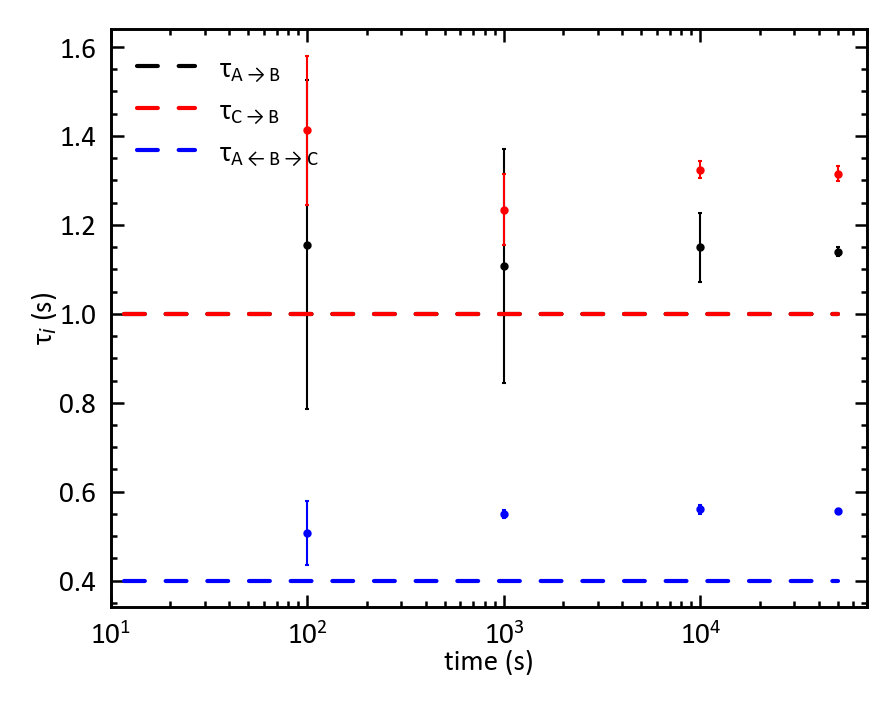

In [60]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, mfpt_means[:,0], yerr=mfpt_std[:,0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, mfpt_means[:,2], yerr=mfpt_std[:,2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, mfpt_means[:,1], yerr=mfpt_std[:,1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(1/k_AB, 1, 50000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$\tau_{A \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(1/k_CB, 1, 50000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$\tau_{C \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(t_ABC, 1, 50000, colors=colorList[2], linestyles=(0, (5,5)), label=r'$\tau_{A \leftarrow B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$\tau_{\it{i}}$ (s)')
plt.xlim([10,70000])
# plt.ylim([0, 1.1])
plt.legend(ncols=1, loc="upper left")

plt.show()

In [61]:
fig.savefig("3state_durations.png")

In [47]:
print(phi_ba, phi_bc)

0.2 0.8


In [48]:
prob

array([[0.        , 0.81013677, 0.18986323],
       [0.20219104, 0.        , 0.79780896],
       [0.0435278 , 0.9564722 , 0.        ]])

Noticed how the spliting probabilitites were recomputed with this route so this does seem to be formally correct!

In [49]:
probs

[[array([[0. , 1. , 0. ],
         [0.3, 0. , 0.7],
         [0. , 1. , 0. ]]),
  array([[0.        , 0.66666667, 0.33333333],
         [0.2       , 0.        , 0.8       ],
         [0.1       , 0.9       , 0.        ]]),
  array([[0.        , 1.        , 0.        ],
         [0.33333333, 0.        , 0.66666667],
         [0.        , 1.        , 0.        ]])],
 [array([[0.        , 0.8       , 0.2       ],
         [0.16346154, 0.        , 0.83653846],
         [0.03296703, 0.96703297, 0.        ]]),
  array([[0.        , 0.76190476, 0.23809524],
         [0.13636364, 0.        , 0.86363636],
         [0.06060606, 0.93939394, 0.        ]]),
  array([[0.        , 0.68181818, 0.31818182],
         [0.16346154, 0.        , 0.83653846],
         [0.05319149, 0.94680851, 0.        ]])],
 [array([[0.        , 0.81690141, 0.18309859],
         [0.22222222, 0.        , 0.77777778],
         [0.07177033, 0.92822967, 0.        ]]),
  array([[0.        , 0.83921569, 0.16078431],
         [0.2

In [55]:
probs = np.stack(probs)
committor_means = np.mean(probs, axis=1)
committor_std = np.std(probs, axis=1)

In [56]:
committor_means

array([[[0.        , 0.88888889, 0.11111111],
        [0.27777778, 0.        , 0.72222222],
        [0.03333333, 0.96666667, 0.        ]],

       [[0.        , 0.74790765, 0.25209235],
        [0.1544289 , 0.        , 0.8455711 ],
        [0.04892153, 0.95107847, 0.        ]],

       [[0.        , 0.837163  , 0.162837  ],
        [0.21058654, 0.        , 0.78941346],
        [0.0534732 , 0.9465268 , 0.        ]],

       [[0.        , 0.8292445 , 0.1707555 ],
        [0.20086332, 0.        , 0.79913668],
        [0.04857845, 0.95142155, 0.        ]]])

In [57]:
committor_means[:,1,0]

array([0.27777778, 0.1544289 , 0.21058654, 0.20086332])

In [50]:
np.stack(probs)

array([[[[0.        , 1.        , 0.        ],
         [0.3       , 0.        , 0.7       ],
         [0.        , 1.        , 0.        ]],

        [[0.        , 0.66666667, 0.33333333],
         [0.2       , 0.        , 0.8       ],
         [0.1       , 0.9       , 0.        ]],

        [[0.        , 1.        , 0.        ],
         [0.33333333, 0.        , 0.66666667],
         [0.        , 1.        , 0.        ]]],


       [[[0.        , 0.8       , 0.2       ],
         [0.16346154, 0.        , 0.83653846],
         [0.03296703, 0.96703297, 0.        ]],

        [[0.        , 0.76190476, 0.23809524],
         [0.13636364, 0.        , 0.86363636],
         [0.06060606, 0.93939394, 0.        ]],

        [[0.        , 0.68181818, 0.31818182],
         [0.16346154, 0.        , 0.83653846],
         [0.05319149, 0.94680851, 0.        ]]],


       [[[0.        , 0.81690141, 0.18309859],
         [0.22222222, 0.        , 0.77777778],
         [0.07177033, 0.92822967, 0.        

In [54]:
(.7+.8+.667)/3

0.7223333333333333

In [51]:
np.mean(np.stack(probs), axis=1)

array([[[0.        , 0.88888889, 0.11111111],
        [0.27777778, 0.        , 0.72222222],
        [0.03333333, 0.96666667, 0.        ]],

       [[0.        , 0.74790765, 0.25209235],
        [0.1544289 , 0.        , 0.8455711 ],
        [0.04892153, 0.95107847, 0.        ]],

       [[0.        , 0.837163  , 0.162837  ],
        [0.21058654, 0.        , 0.78941346],
        [0.0534732 , 0.9465268 , 0.        ]],

       [[0.        , 0.8292445 , 0.1707555 ],
        [0.20086332, 0.        , 0.79913668],
        [0.04857845, 0.95142155, 0.        ]]])

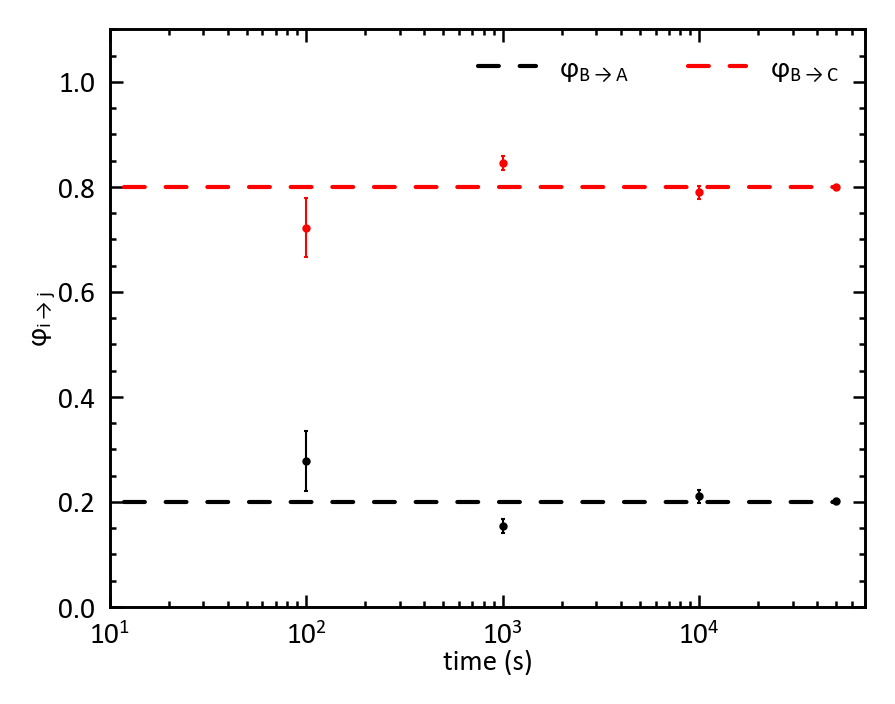

In [62]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, committor_means[:,1,0], yerr=committor_std[:,1,0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, committor_means[:,1,2], yerr=committor_std[:,1,2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(phi_ba, 1, 50000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$\phi_{B \rightarrow A}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(phi_bc, 1, 50000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$\phi_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$\phi_{i \rightarrow j}$')
plt.xlim([10,70000])
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [63]:
fig.savefig("3state_probMat_committors.png")

In [64]:
rates = np.stack(rates)
rate_means = np.mean(rates, axis=1)
rate_std = np.std(rates, axis=1)

In [65]:
prob * inv_mfpt_X1

array([[0.        , 0.71135914, 0.16671376],
       [0.3602493 , 0.        , 1.42147798],
       [0.03372413, 0.7410481 , 0.        ]])

In [66]:
rates

array([[[[0.        , 1.25      , 0.        ],
         [0.5       , 0.        , 1.16666667],
         [0.        , 0.63636364, 0.        ]],

        [[0.        , 0.66666667, 0.33333333],
         [0.4       , 0.        , 1.6       ],
         [0.08474576, 0.76271186, 0.        ]],

        [[0.        , 0.6       , 0.        ],
         [0.78947368, 0.        , 1.57894737],
         [0.        , 0.67307692, 0.        ]]],


       [[[0.        , 0.81632653, 0.20408163],
         [0.2972028 , 0.        , 1.52097902],
         [0.02454992, 0.72013093, 0.        ]],

        [[0.        , 0.87912088, 0.27472527],
         [0.24271845, 0.        , 1.53721683],
         [0.05016722, 0.77759197, 0.        ]],

        [[0.        , 0.46296296, 0.21604938],
         [0.3024911 , 0.        , 1.5480427 ],
         [0.04621072, 0.82255083, 0.        ]]],


       [[[0.        , 0.7030303 , 0.15757576],
         [0.39730401, 0.        , 1.39056403],
         [0.05435767, 0.70302591, 0.        

In [37]:
np.mean(np.stack(rates[0])[:,1,0])

0.4455391351943075

In [49]:
rate_means

array([[[0.        , 1.06703466, 0.21914648],
        [0.44553914, 0.        , 1.77668309],
        [0.03768475, 0.71075199, 0.        ]],

       [[0.        , 0.85550697, 0.17570314],
        [0.38441009, 0.        , 1.53291789],
        [0.03965126, 0.74784126, 0.        ]],

       [[0.        , 0.7302183 , 0.14997148],
        [0.360611  , 0.        , 1.43801389],
        [0.03775916, 0.71215523, 0.        ]],

       [[0.        , 0.73018782, 0.14996523],
        [0.35845098, 0.        , 1.42940036],
        [0.03850148, 0.72615587, 0.        ]]])

In [50]:
rate_means[:,0,1]

array([1.06703466, 0.85550697, 0.7302183 , 0.73018782])

In [67]:
print(k_AB, k_BA, k_BC, k_CB)

1 0.5 2 1


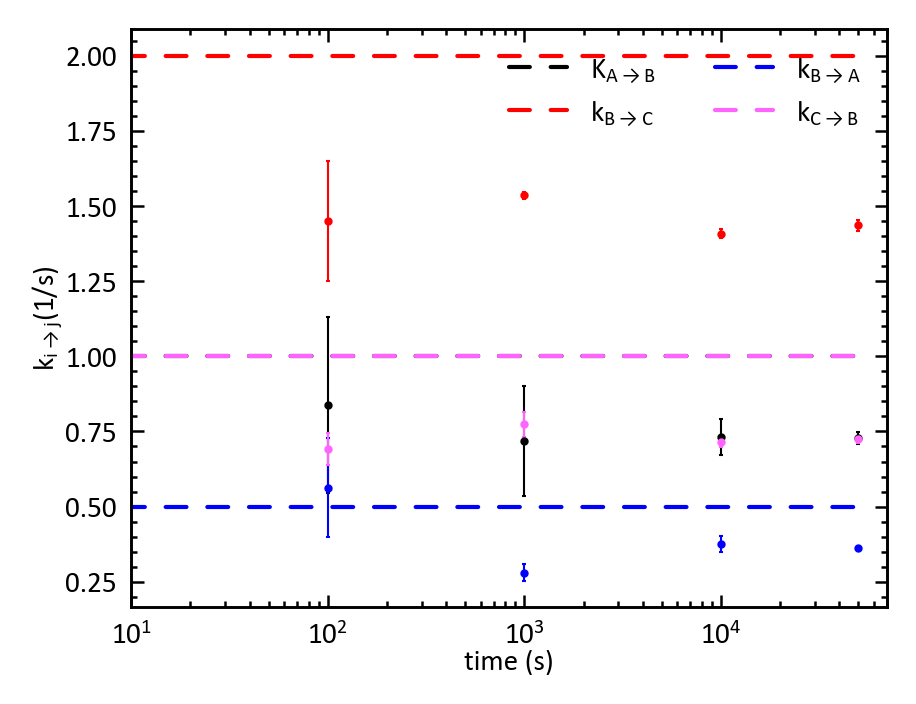

In [70]:
fig = plt.figure()

# plt.plot(steps, np.nanmean(MFPTs, axis=1).T[0], 'o', c='#FF8700')
plt.errorbar(steps, rate_means[:,0,1], yerr=rate_std[:,0,1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, rate_means[:,1,2], yerr=rate_std[:,1,2], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, rate_means[:,1,0], yerr=rate_std[:,1,0], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)
plt.errorbar(steps, rate_means[:,2,1], yerr=rate_std[:,2,1], 
             fmt="o", #ecolor='k', c='k',
             elinewidth=0.5, capsize=0.5, 
             capthick=0.5)

plt.hlines(k_AB, 1, 50000, colors=colorList[0], linestyles=(0, (5,5)), label=r'$K_{A \rightarrow B}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_BC, 1, 50000, colors=colorList[1], linestyles=(0, (5,5)), label=r'$k_{B \rightarrow C}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_BA, 1, 50000, colors=colorList[2], linestyles=(0, (5,5)), label=r'$k_{B \rightarrow A}$', 
           capstyle='round', joinstyle='miter')
plt.hlines(k_CB, 1, 50000, colors=colorList[3], linestyles=(0, (5,5)), label=r'$k_{C \rightarrow B}$', 
           capstyle='round', joinstyle='miter')

plt.xscale('log')
plt.xlabel('time (s)')
plt.ylabel(r'$k_{i \rightarrow j} (1/s)$')
plt.xlim([10,70000])
# plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

In [71]:
fig.savefig("3state_route_3_rates.png")

# Y Kinetic model

$A \leftrightharpoons B \leftrightharpoons C$ \
$D \leftrightharpoons B $ \
k$_{A \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow A} = 2/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{D \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow D} = 2/step$ 

In [5]:
k_AB, k_BA, k_BC, k_CB, k_DB, k_BD = [0.5, 2, 2, 0.5, 0.5, 2]

In [6]:
#                  A                      B      C      D
Q = np.array([[-k_AB,                  k_AB,     0,     0],  # A
              [ k_BA, -(k_BA + k_BC + k_BD),  k_BC,  k_BD],  # B
              [    0,                  k_CB, -k_CB,     0],  # C
              [    0,                  k_DB,     0, -k_DB]]) # D

## Algebric expresions

In [7]:
delta = k_BA * k_CB * k_DB + k_BC * k_AB * k_DB + k_BD * k_AB * k_CB + k_AB * k_CB * k_DB
piA = k_BA * k_CB * k_DB / delta
piB = k_AB * k_CB * k_DB /delta
piC = 
piA, piB

SyntaxError: invalid syntax (2111215673.py, line 4)

## SVD

In [8]:
eig_val, eig_vec = SVD(Q)

In [9]:
eig_val

array([-6.50000000e+00, -5.00000000e-01,  9.17211899e-17, -5.00000000e-01])

In [10]:
eig_vec[:,2] / np.sum(eig_vec[:,2])

array([0.30769231, 0.07692308, 0.30769231, 0.30769231])

In [15]:
np.sum(eig_vec[:,2] / np.sum(eig_vec[:,2]))

1.0

Notice how the eigenvale equal to zero corresponds to the equilibrium probability vector

In [ ]:
# from Spectral decomposition
times = np.linspace(0, 40, num=1000)
P_spectral_decomp = []
for t in times:
    P_spectral_decomp.append(Prob_t(4, eig_val, eig_vec, t))

P_spectral_decomp = np.stack(P_spectral_decomp)

In [13]:
P_spectral_decomp.shape

(1000, 4, 4)

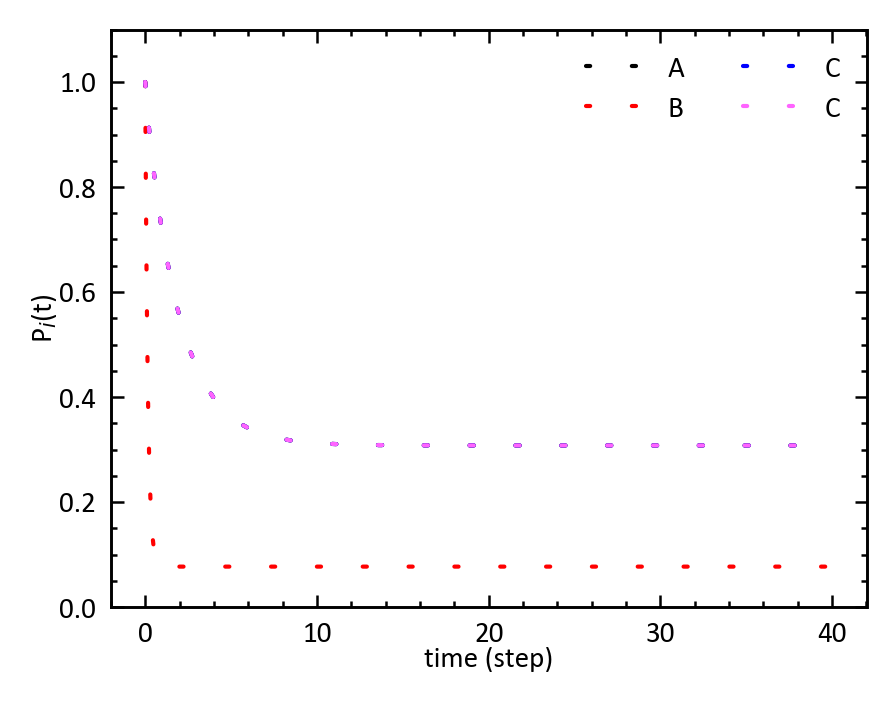

In [14]:
fig = plt.figure()

# plt.plot(times, P[:, 0, 0], '-', label='A')
# plt.plot(times, P[:, 1, 1], '-', label='B')
# plt.plot(times, P[:, 2, 2], '-', label='C')

plt.plot(times, P_spectral_decomp[:, 0, 0], ls=(0, (1, 10)), label='A')
plt.plot(times, P_spectral_decomp[:, 1, 1], ls=(0, (1, 10)), label='B')
plt.plot(times, P_spectral_decomp[:, 2, 2], ls=(0, (1, 10)), label='C')
plt.plot(times, P_spectral_decomp[:, 3, 3], ls=(0, (1, 10)), label='D')

# plt.hlines(piA, 0, 40, colors='#009900', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

I think you can use the characteristic times from reaching the equilibrium probabilites to help guide the choosing of the lagtime

## Simulation

In [18]:
times = np.linspace(0, 40, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [19]:
P = np.stack(P)

In [20]:
P.shape

(1000, 4, 4)

In [21]:
# is the unique and true solution?
P[-1]

array([[0.30769231, 0.07692308, 0.30769231, 0.30769231],
       [0.30769231, 0.07692308, 0.30769231, 0.30769231],
       [0.30769231, 0.07692308, 0.30769231, 0.30769231],
       [0.30769231, 0.07692308, 0.30769231, 0.30769231]])

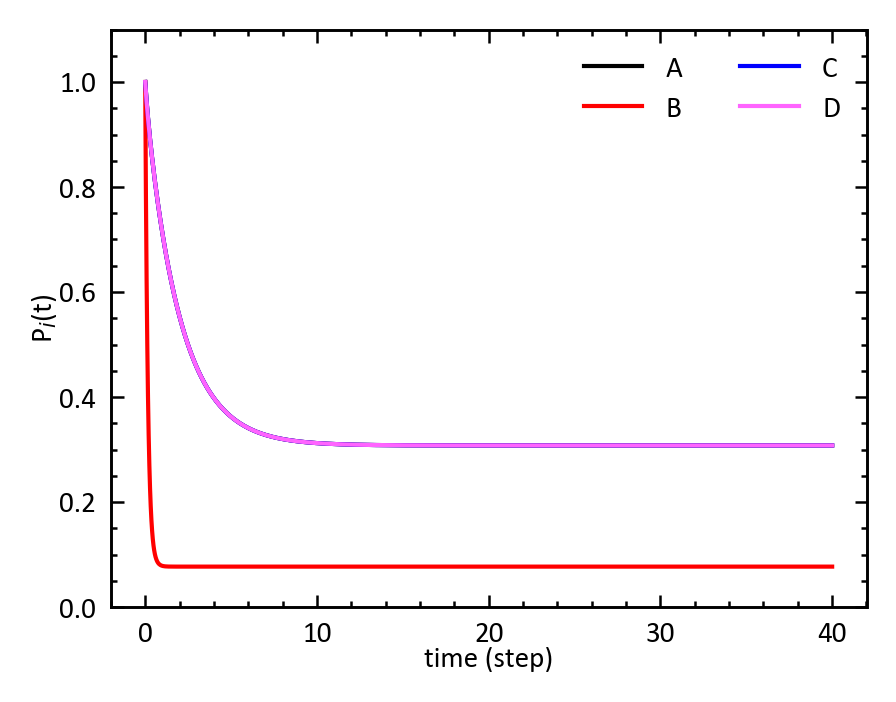

In [25]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
plt.plot(times, P[:, 3, 3], '-', label='D')
# plt.plot(times, P[:, 4, 4], '-', label='E')

# plt.hlines(piA, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#F2E100', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## MSM

In [11]:
lagtime = 0.5
MSM_true, traj_discrete = MSMtraj(20000, Prob_t(4, eig_val, eig_vec, lagtime))

In [11]:
print(Prob_t(4, eig_val, eig_vec, lagtime))
print(MSM_true.transition_matrix)

[[0.71208463 0.07680743 0.10555397 0.10555397]
 [0.30722971 0.07831087 0.30722971 0.30722971]
 [0.10555397 0.07680743 0.71208463 0.10555397]
 [0.10555397 0.07680743 0.10555397 0.71208463]]
[[0.71208463 0.07680743 0.10555397 0.10555397]
 [0.30722971 0.07831087 0.30722971 0.30722971]
 [0.10555397 0.07680743 0.71208463 0.10555397]
 [0.10555397 0.07680743 0.10555397 0.71208463]]


In [12]:
traj_discrete

array([2, 2, 2, ..., 2, 2, 2])

In [13]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [14]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[5365.,  440.,  300.,  300.],
       [ 429.,  136.,  438.,  414.],
       [ 303.,  405., 4878.,  323.],
       [ 308.,  436.,  293., 5231.]])

In [15]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [16]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=eig_vec[:,2] / np.sum(eig_vec[:,2])
)

In [17]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()

In [22]:
MSM.transition_matrix

array([[0.69840996, 0.08222116, 0.11236371, 0.10700518],
       [0.30388005, 0.07352941, 0.30969673, 0.31289381],
       [0.10399481, 0.0775539 , 0.71515442, 0.10329687],
       [0.09669813, 0.07650533, 0.10085904, 0.7259375 ]])

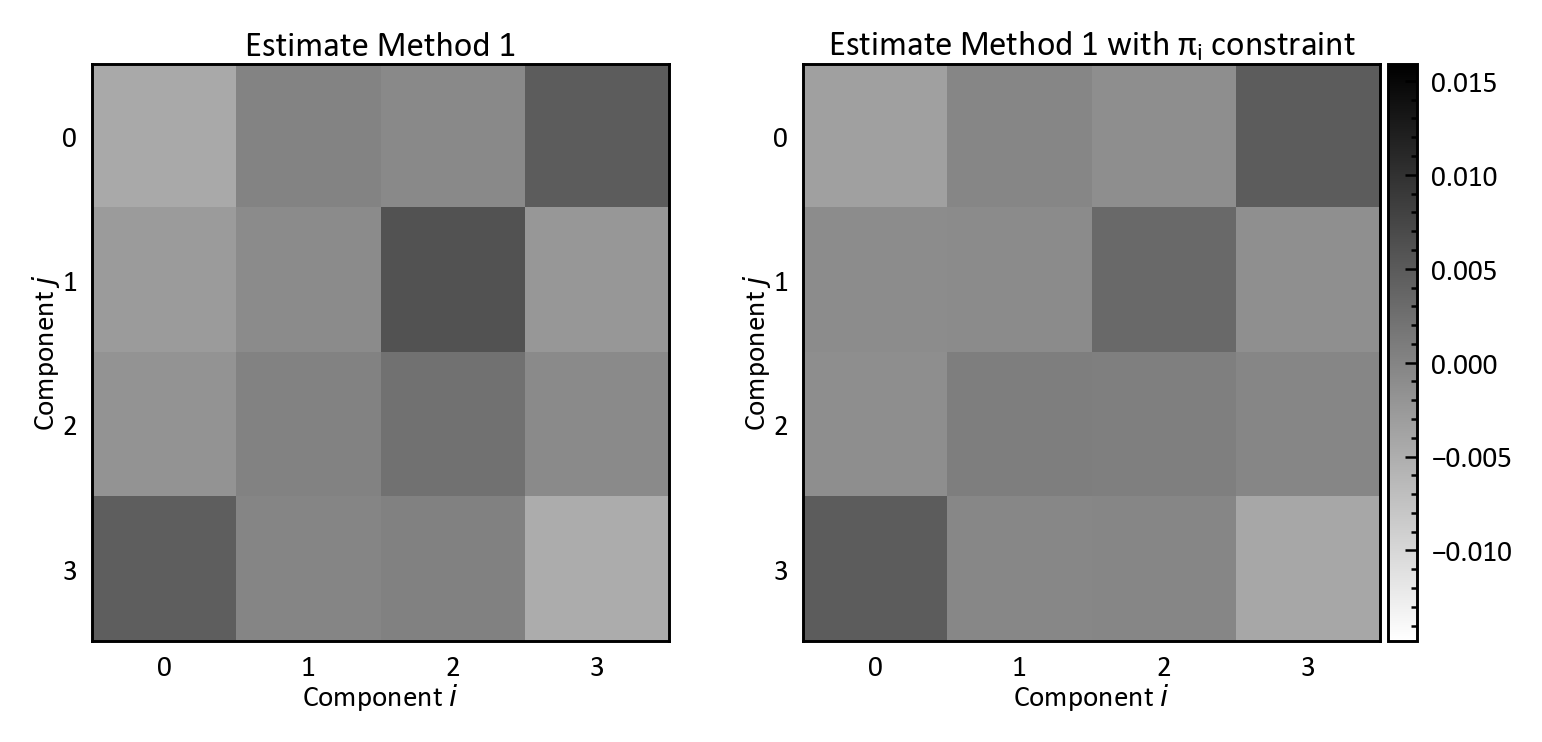

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(2*3.25, 1*2.5))
# fig.tight_layout()
# plt.subplots_adjust(wspace=0.)
plt.subplots_adjust(wspace=-0.05)

a = np.min([MSM.transition_matrix - MSM_true.transition_matrix,
            MSM2.transition_matrix - MSM_true.transition_matrix])
b = np.max([MSM.transition_matrix - MSM_true.transition_matrix,
            MSM2.transition_matrix - MSM_true.transition_matrix])

axs[0].imshow(MSM.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)
pos = axs[1].imshow(MSM2.transition_matrix - MSM_true.transition_matrix, cmap='gray_r', vmin=a-0.01, vmax=b+0.01)

fig.colorbar(pos, ax=axs[1], pad=0.01)

titles = [r"Estimate Method 1", r"Estimate Method 1 with $\pi_i$ constraint"]

count = 0
for j in axs:
    # for j in i:
    j.set_title(titles[count], pad=2)
    count += 1
    j.set_xlabel(r"Component $\it{i}$")
    j.set_ylabel(r"Component $\it{j}$")
    j.set_xticks([0,1,2,3])
    j.set_yticks([0,1,2,3])
    j.tick_params(axis='both', which='both', bottom=False, 
                    top=False, left=False, right=False)

plt.show()

In [18]:
models = []
models2 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))

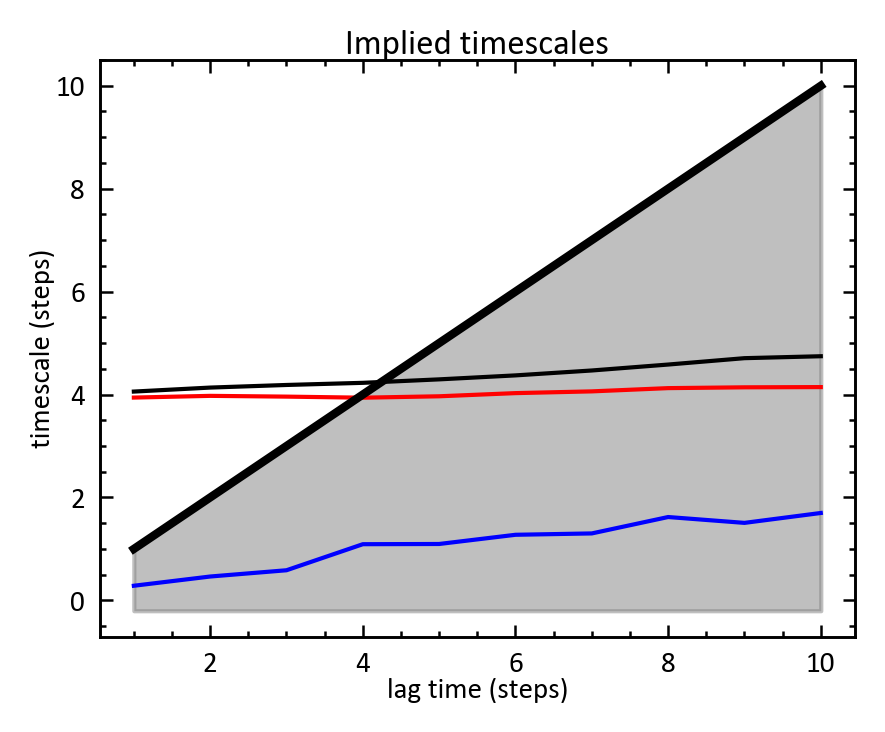

In [19]:
fig, ax = plt.subplots(1,1)
dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(models2))

ax.set_title("Implied timescales")
ax.set_xlabel("lag time (steps)")
ax.set_ylabel("timescale (steps)")

plt.show()

In [20]:
np.exp(eig_val*lagtime)

array([0.03877421, 0.77880078, 1.        , 0.77880078])

In [21]:
eig_vec

array([[ 2.88675135e-01,  8.16496581e-01, -5.71428571e-01,
         4.08248290e-01],
       [-8.66025404e-01,  9.30172554e-17, -1.42857143e-01,
         6.91709603e-17],
       [ 2.88675135e-01, -4.08248290e-01, -5.71428571e-01,
        -8.16496581e-01],
       [ 2.88675135e-01, -4.08248290e-01, -5.71428571e-01,
         4.08248290e-01]])

In [22]:
print(MSM_true.eigenvalues())

[1.         0.77880078 0.77880078 0.03877421]


In [23]:
MSM_true.eigenvectors_left()

array([[ 3.07692308e-01,  7.69230769e-02,  3.07692308e-01,
         3.07692308e-01],
       [-4.52804945e-02, -4.59099747e-17, -3.67626855e-01,
         4.12907350e-01],
       [-4.52910814e-01, -1.78574323e-16,  2.26455407e-01,
         2.26455407e-01],
       [ 8.88231183e-02, -2.66469355e-01,  8.88231183e-02,
         8.88231183e-02]])

In [24]:
MSM_true.eigenvectors_right().T

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00],
       [-1.47161607e-01, -5.96829671e-16, -1.19478728e+00,
         1.34194889e+00],
       [-1.47196014e+00, -2.32146620e-15,  7.35980072e-01,
         7.35980072e-01],
       [ 2.88675135e-01, -3.46410162e+00,  2.88675135e-01,
         2.88675135e-01]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [25]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

3

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

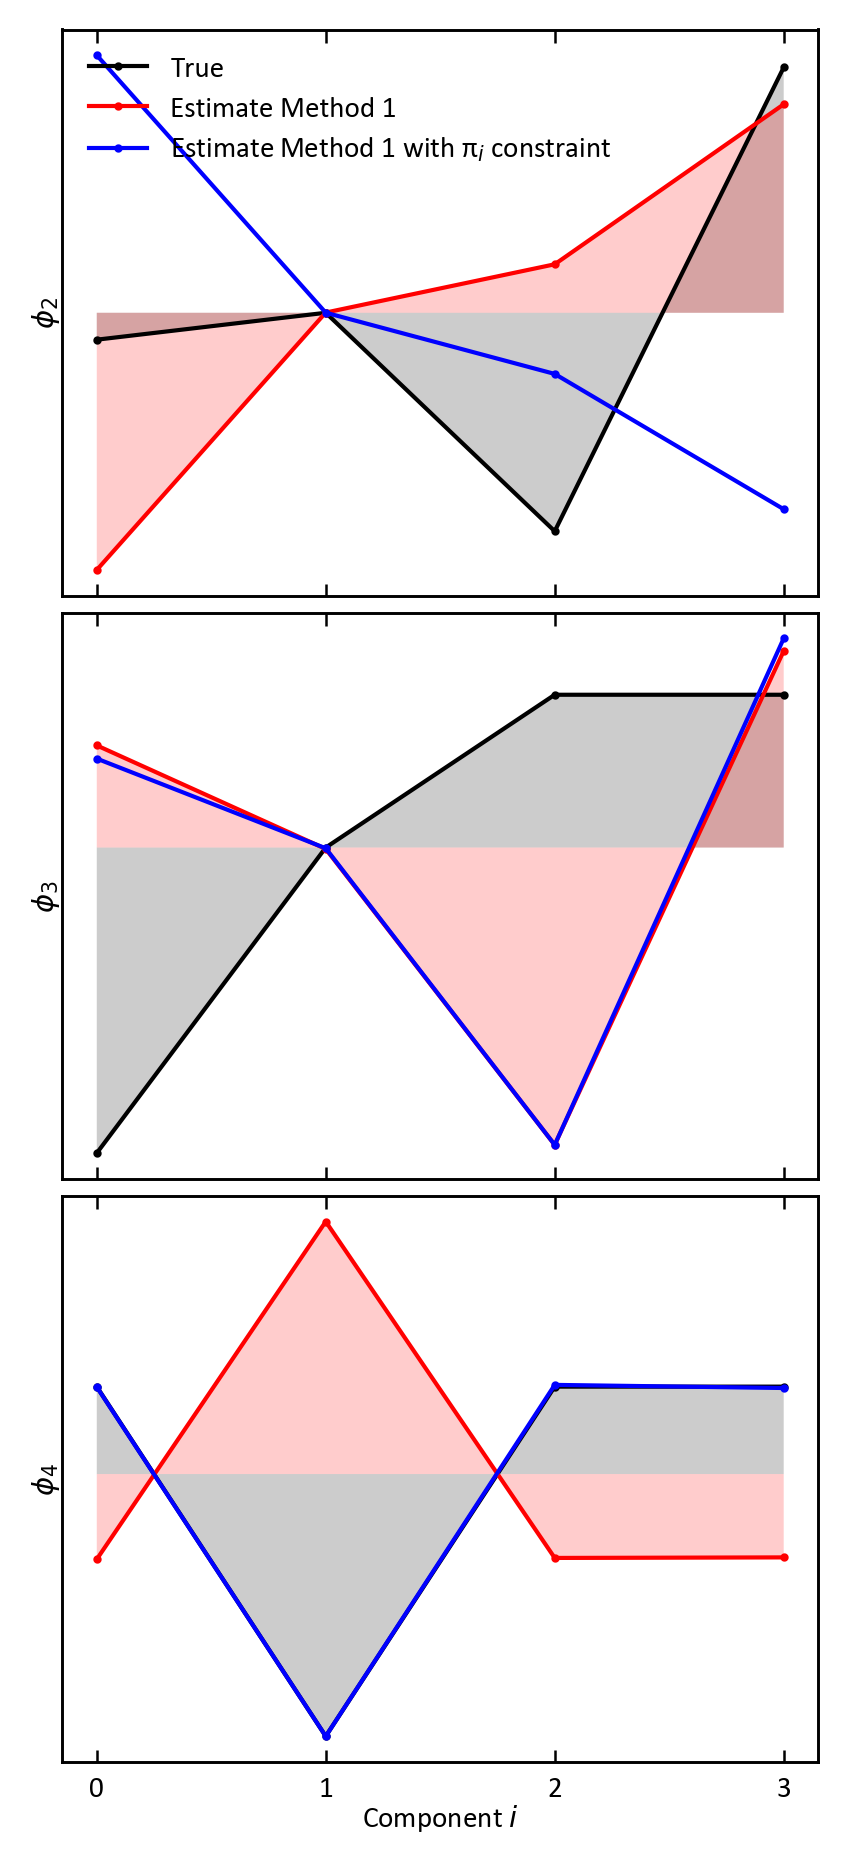

In [26]:
fig, axs = plt.subplots(3,1, figsize=(1*3.25, 3*2.5), sharex=True, sharey=False)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), MSM2.eigenvectors_left())
comps = np.array([0,1,2,3])

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
axs[0].fill_between(comps, esti1[1], alpha=0.2)
# axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
axs[1].fill_between(comps, esti1[2], alpha=0.2)
# axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])

axs[2].plot(true[3], 'o-', label="True")
axs[2].plot(esti1[3], 'o-', label="Estimate Method 1")
axs[2].plot(esti1_con[3], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[2].fill_between(comps, true[3], alpha=0.2)
axs[2].fill_between(comps, esti1[3], alpha=0.2)
# axs[2].fill_between(comps, esti1_con[3], alpha=0.2, color=colorList[2])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[2].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
axs[2].set_ylabel(r"$\it{\phi}_4$")
axs[0].legend()

plt.show()

In [27]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())

[4.         4.         0.30769231]
[4.20691784 3.98882168 0.27683148]
[4.05761218 3.94080172 0.28441098]


In [28]:
rf = MSM_true.reactive_flux([0], [1])
rf2 = MSM.reactive_flux([0], [1])
rf3 = MSM2.reactive_flux([0], [1])

In [29]:
print(rf.backward_committor, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)

[1.         0.         0.39898864 0.39898864] [0.         1.         0.60101136 0.60101136]
[1.         0.         0.41701179 0.41701025] [0.         1.         0.58298821 0.58298975]
[1.         0.         0.39143624 0.39190047] [0.         1.         0.60856376 0.60809953]


In [30]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)

13.524397811543684
14.581518037855279
13.41335896888383


In [31]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)

0.07394044555140598
0.06857996522748086
0.07455254141187077


In [32]:
k_AB

0.5

In [33]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)

[0.30769231 0.07692308 0.30769231 0.30769231]
[0.32026601 0.07085354 0.29546477 0.31341567]
[0.30769231 0.07692308 0.30769231 0.30769231]


In [34]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)

[[0.         0.02275091 0.00907735 0.00907735]
 [0.         0.         0.         0.        ]
 [0.         0.00907735 0.         0.00362176]
 [0.         0.00907735 0.00362176 0.        ]]
[[0.         0.02172609 0.00878899 0.00886189]
 [0.         0.         0.         0.        ]
 [0.         0.00878896 0.         0.00374414]
 [0.         0.00886191 0.00374411 0.        ]]
[[0.         0.02288977 0.00911998 0.00889865]
 [0.         0.         0.         0.        ]
 [0.         0.00912717 0.         0.00368991]
 [0.         0.00889145 0.00369711 0.        ]]


In [35]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)

[[0.00000000e+00 2.27509063e-02 9.07735324e-03 9.07735324e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.07735324e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.07735324e-03 2.16840434e-18 0.00000000e+00]]
[[0.00000000e+00 2.17260863e-02 8.78898668e-03 8.86188725e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.78896297e-03 0.00000000e+00 2.37109290e-08]
 [0.00000000e+00 8.86191096e-03 0.00000000e+00 0.00000000e+00]]
[[0.00000000e+00 2.28897723e-02 9.11997685e-03 8.89864601e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.12717312e-03 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.89144973e-03 7.19627418e-06 0.00000000e+00]]


In [36]:
traj_discrete.shape

(20000,)

In [37]:
traj_discrete[:20]

array([2, 2, 2, 1, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [38]:
state_durations = stateDurations(4, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [30]:
state_durations[0]

[5,
 2,
 26,
 13,
 5,
 2,
 21,
 22,
 4,
 6,
 4,
 7,
 5,
 2,
 1,
 1,
 9,
 23,
 2,
 1,
 8,
 7,
 2,
 1,
 7,
 4,
 11,
 2,
 11,
 11,
 1,
 2,
 1,
 9,
 9,
 12,
 1,
 3,
 1,
 28,
 7,
 4,
 1,
 11,
 3,
 5,
 7,
 3,
 4,
 8,
 4,
 1,
 13,
 3,
 3,
 1,
 4,
 2,
 2,
 4,
 5,
 7,
 16,
 1,
 2,
 1,
 21,
 6,
 17,
 2,
 3,
 1,
 1,
 1,
 2,
 2,
 4,
 1,
 3,
 10,
 5,
 1,
 23,
 8,
 6,
 10,
 1,
 2,
 5,
 4,
 5,
 4,
 15,
 3,
 6,
 4,
 3,
 1,
 3,
 1,
 4,
 9,
 23,
 4,
 1,
 8,
 6,
 4,
 12,
 7,
 3,
 2,
 7,
 17,
 2,
 2,
 1,
 4,
 3,
 3,
 10,
 4,
 4,
 9,
 14,
 18,
 10,
 7,
 3,
 1,
 6,
 12,
 2,
 7,
 7,
 2,
 4,
 7,
 8,
 9,
 2,
 2,
 11,
 11,
 7,
 1,
 10,
 7,
 9,
 1,
 7,
 3,
 6,
 2,
 1,
 1,
 25,
 1,
 23,
 9,
 13,
 2,
 10,
 13,
 4,
 2,
 14,
 7,
 4,
 13,
 12,
 1,
 1,
 7,
 9,
 2,
 3,
 10,
 2,
 3,
 2,
 4,
 15,
 1,
 2,
 4,
 2,
 1,
 3,
 4,
 1,
 3,
 7,
 5,
 4,
 7,
 8,
 1,
 11,
 5,
 4,
 13,
 3,
 3,
 3,
 4,
 4,
 4,
 1,
 4,
 32,
 11,
 3,
 13,
 12,
 7,
 10,
 3,
 2,
 6,
 1,
 8,
 5,
 1,
 6,
 7,
 8,
 5,
 7,
 1,
 15,
 4,
 16,
 7,
 6,
 7,
 1,
 6,

In [39]:
avg_state_durations

{0: 6.158653846153846,
 1: 1.106167056986729,
 2: 5.717749757516974,
 3: 6.044358727097396}

In [40]:
ProbMat = ProbMatrix(4, traj_discrete)

In [41]:
ProbMat

array([[0.        , 0.42307692, 0.28846154, 0.28846154],
       [0.33489461, 0.        , 0.34192037, 0.32318501],
       [0.29388943, 0.3928225 , 0.        , 0.31328807],
       [0.29701061, 0.42044359, 0.28254581, 0.        ]])

In [42]:
np.sum(ProbMat, axis=1)

array([1., 1., 1., 1.])

In [43]:
MSM_true.transition_matrix

array([[0.82788704, 0.07394045, 0.04908626, 0.04908626],
       [0.29576178, 0.11271465, 0.29576178, 0.29576178],
       [0.04908626, 0.07394045, 0.82788704, 0.04908626],
       [0.04908626, 0.07394045, 0.04908626, 0.82788704]])

In [44]:
MSM.transition_matrix

array([[0.83762685, 0.06783763, 0.0470726 , 0.04746292],
       [0.30663373, 0.09597742, 0.29745942, 0.29992943],
       [0.05102386, 0.07133187, 0.82552039, 0.05212388],
       [0.04850032, 0.06780472, 0.04913848, 0.83455648]])

In [45]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [46]:
mfpt

array([3.07932692, 0.55308353, 2.85887488, 3.02217936])

In [47]:
print(1/k_AB, 1/k_BA, 1/k_CB,)

2.0 0.5 2.0


In [48]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [49]:
inv_mfpt_X1

array([[0.32474629, 0.32474629, 0.32474629, 0.32474629],
       [1.80804517, 1.80804517, 1.80804517, 1.80804517],
       [0.34978796, 0.34978796, 0.34978796, 0.34978796],
       [0.33088705, 0.33088705, 0.33088705, 0.33088705]])

In [50]:
print(k_AB, k_BA, k_BC, k_BD, k_CB)

0.5 2 2 2 0.5


In [51]:
ProbMat * inv_mfpt_X1

array([[0.        , 0.13739266, 0.09367681, 0.09367681],
       [0.60550459, 0.        , 0.61820748, 0.5843331 ],
       [0.10279898, 0.13740458, 0.        , 0.10958439],
       [0.09827696, 0.13911934, 0.09349075, 0.        ]])

# K Kinetic model

$A \leftrightharpoons B \leftrightharpoons C$ \
$D \leftrightharpoons B \leftrightharpoons E$ \
k$_{A \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow A} = 2/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{D \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow D} = 2/step$ \
k$_{E \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow E} = 2/step$ 

In [52]:
k_AB, k_BA, k_BC, k_CB, k_DB, k_BD, k_EB, k_BE = [0.5, 2, 2, 0.5, 0.5, 2, 0.5, 2]

In [53]:
#                  A                             B      C      D      E
Q = np.array([[-k_AB,                         k_AB,     0,     0,     0],  # A
              [ k_BA, -(k_BA + k_BC + k_BD + k_BE),  k_BC,  k_BD,  k_BE],  # B
              [    0,                         k_CB, -k_CB,     0,     0],  # C
              [    0,                         k_DB,     0, -k_DB,     0],  # D
              [    0,                         k_EB,     0,     0, -k_EB]]) # E

## Algebric expresions

In [54]:
delta = k_BA * k_CB * k_DB * k_EB + k_BC * k_AB * k_DB * k_EB + k_BD * k_AB * k_CB * k_EB + k_BE * k_AB * k_CB * k_DB + k_AB * k_CB * k_DB * k_EB
piA = k_BA * k_CB * k_DB * k_EB / delta
piB = k_AB * k_CB * k_DB * k_EB /delta
piA, piB

(0.23529411764705882, 0.058823529411764705)

## SVD

In [55]:
eig_val, eig_vec = SVD(Q)

In [10]:
eig_val

array([-8.50000000e+00, -5.00000000e-01,  5.21294027e-17, -5.00000000e-01,
       -5.00000000e-01])

In [11]:
eig_vec[:,2] / np.sum(eig_vec[:,2])

array([0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412])

## Simulation

In [8]:
times = np.linspace(0, 40, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [9]:
P = np.stack(P)

In [10]:
P.shape

(1000, 5, 5)

In [11]:
# is the unique and true solution?
P[-1]

array([[0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412],
       [0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412],
       [0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412],
       [0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412],
       [0.23529412, 0.05882353, 0.23529412, 0.23529412, 0.23529412]])

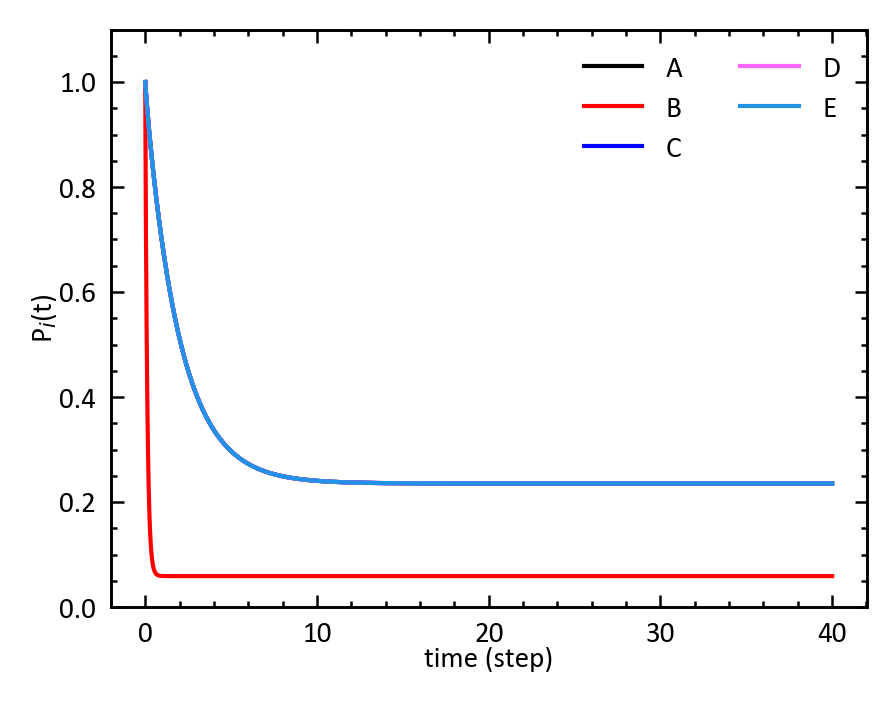

In [16]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
plt.plot(times, P[:, 3, 3], '-', label='D')
plt.plot(times, P[:, 4, 4], '-', label='E')

# plt.hlines(piA, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#F2E100', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## MSM

In [56]:
lagtime = 0.4
MSM_true, traj_discrete = MSMtraj(20000, Prob_t(5, eig_val, eig_vec, lagtime))

In [57]:
traj_discrete

array([0, 0, 0, ..., 0, 0, 0])

In [58]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [59]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[3846.,  262.,  129.,  134.,  165.],
       [ 266.,  117.,  258.,  243.,  282.],
       [ 131.,  278., 3992.,  135.,  140.],
       [ 140.,  242.,  148., 3846.,  151.],
       [ 153.,  267.,  149.,  169., 4356.]])

In [60]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [61]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=eig_vec[:,2] / np.sum(eig_vec[:,2])
)

In [62]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()

In [63]:
models = []
models2 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))

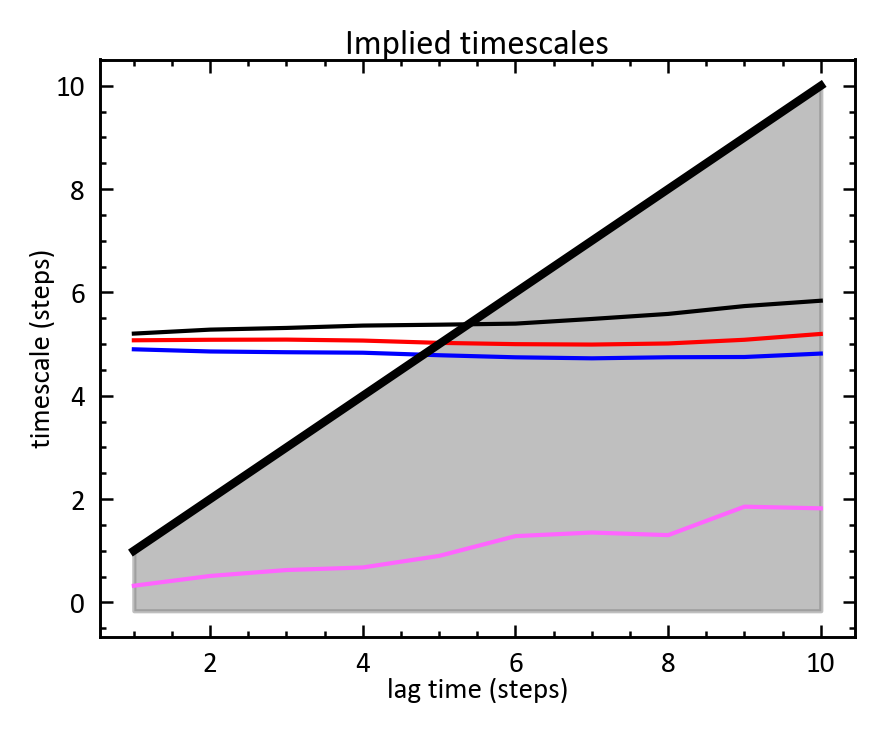

In [64]:
fig, ax = plt.subplots(1,1)
dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(models2))

ax.set_title("Implied timescales")
ax.set_xlabel("lag time (steps)")
ax.set_ylabel("timescale (steps)")

plt.show()

In [65]:
np.exp(eig_val*lagtime)

array([0.03337327, 0.81873075, 1.        , 0.81873075, 0.81873075])

In [66]:
eig_vec

array([[ 2.23606798e-01,  8.66025404e-01, -4.96138938e-01,
        -1.21267813e-01,  9.62250449e-02],
       [-8.94427191e-01, -4.92107314e-18, -1.24034735e-01,
        -1.61402016e-17,  4.79477711e-18],
       [ 2.23606798e-01, -2.88675135e-01, -4.96138938e-01,
         8.48874688e-01, -2.88675135e-01],
       [ 2.23606798e-01, -2.88675135e-01, -4.96138938e-01,
        -3.63803438e-01, -5.70441622e-01],
       [ 2.23606798e-01, -2.88675135e-01, -4.96138938e-01,
        -3.63803438e-01,  7.62891712e-01]])

In [67]:
print(MSM_true.eigenvalues())

[1.         0.81873075 0.81873075 0.81873075 0.03337327]


In [68]:
MSM_true.eigenvectors_left()

array([[ 2.35294118e-01,  5.88235294e-02,  2.35294118e-01,
         2.35294118e-01,  2.35294118e-01],
       [-1.16713906e-02, -1.52689690e-17, -3.88457851e-01,
         2.45926854e-01,  1.54202388e-01],
       [ 3.42098837e-02,  3.13168911e-17, -6.42049301e-02,
        -3.23788307e-01,  3.53783353e-01],
       [-4.20084025e-01, -9.92107580e-17,  1.40028008e-01,
         1.40028008e-01,  1.40028008e-01],
       [ 5.88235294e-02, -2.35294118e-01,  5.88235294e-02,
         5.88235294e-02,  5.88235294e-02]])

In [69]:
MSM_true.eigenvectors_right().T

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00],
       [-4.96034101e-02, -2.59572472e-16, -1.65094587e+00,
         1.04518913e+00,  6.55360151e-01],
       [ 1.45392006e-01,  5.32387148e-16, -2.72870953e-01,
        -1.37610030e+00,  1.50357925e+00],
       [-1.78535711e+00, -1.68658289e-15,  5.95119036e-01,
         5.95119036e-01,  5.95119036e-01],
       [ 2.50000000e-01, -4.00000000e+00,  2.50000000e-01,
         2.50000000e-01,  2.50000000e-01]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [70]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

4

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

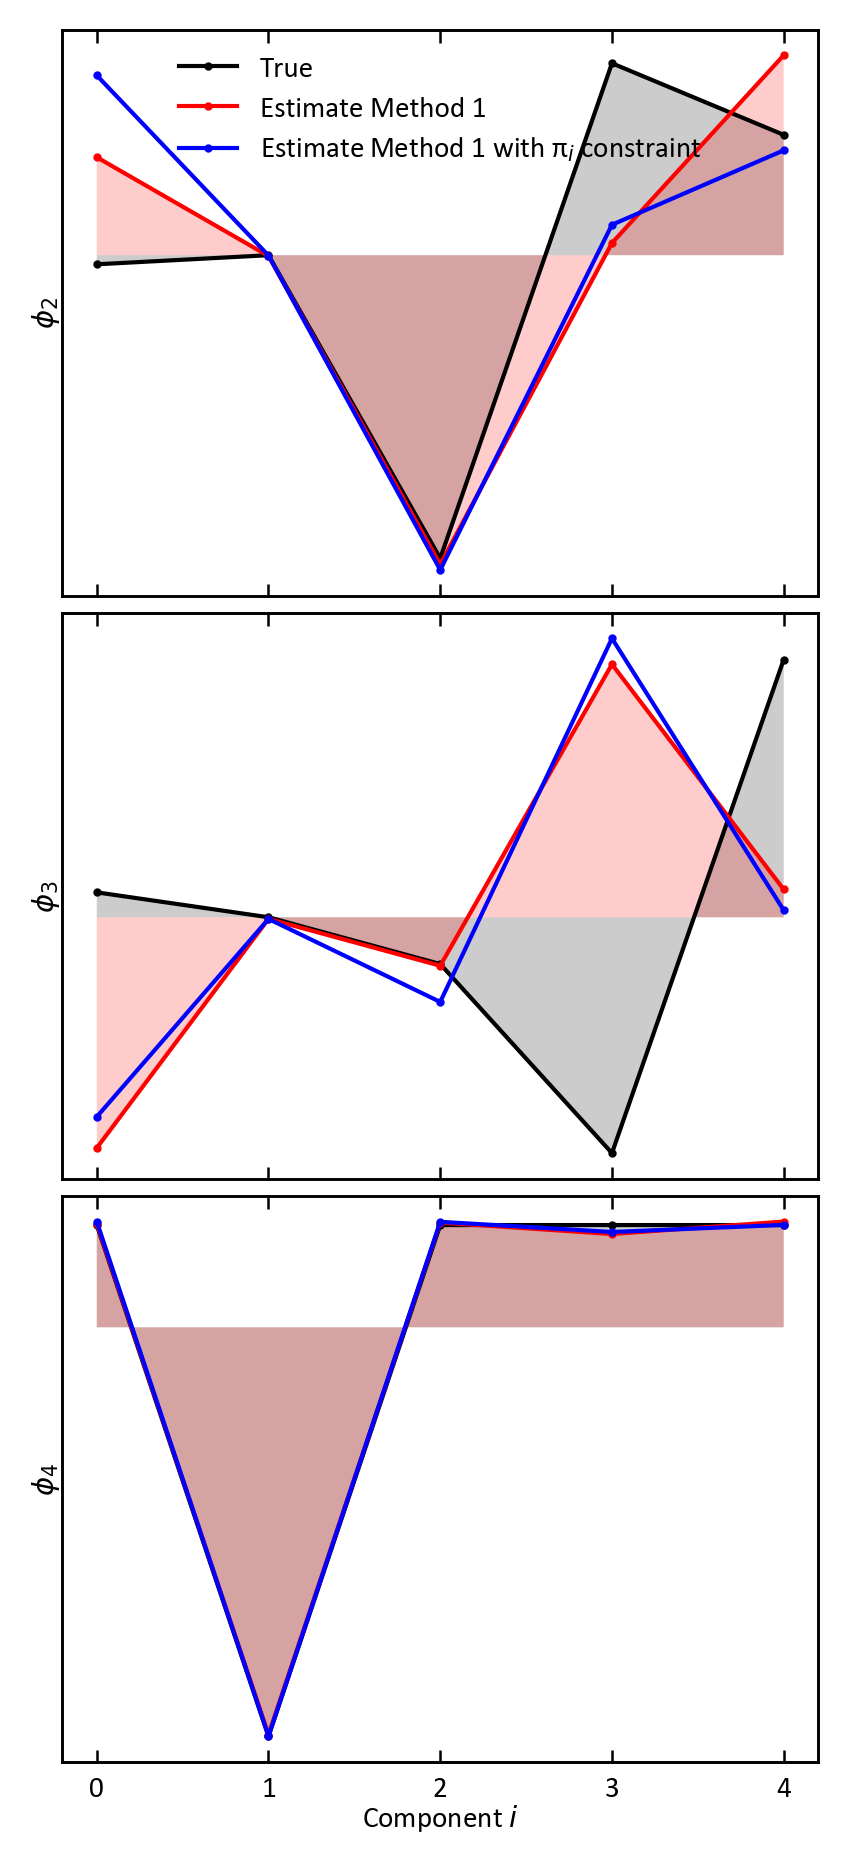

In [71]:
fig, axs = plt.subplots(3,1, figsize=(1*3.25, 3*2.5), sharex=True, sharey=False)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), MSM2.eigenvectors_left())
comps = np.array([0,1,2,3,4])

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
axs[0].fill_between(comps, esti1[1], alpha=0.2)
# axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
axs[1].fill_between(comps, esti1[2], alpha=0.2)
# axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])

axs[2].plot(true[4], 'o-', label="True")
axs[2].plot(esti1[4], 'o-', label="Estimate Method 1")
axs[2].plot(esti1_con[4], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[2].fill_between(comps, true[4], alpha=0.2)
axs[2].fill_between(comps, esti1[4], alpha=0.2)
# axs[2].fill_between(comps, esti1_con[3], alpha=0.2, color=colorList[2])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[2].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
axs[2].set_ylabel(r"$\it{\phi}_4$")
axs[0].legend()

plt.show()

In [72]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())

[5.         5.         5.         0.29411765]
[5.22074758 4.98861343 4.97924371 0.32142856]
[5.2027732  5.07324503 4.89899294 0.32233113]


In [73]:
rf = MSM_true.reactive_flux([0], [1])
rf2 = MSM.reactive_flux([0], [1])
rf3 = MSM2.reactive_flux([0], [1])

In [74]:
print(rf.backward_committor, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)

[1.         0.         0.35358447 0.35358447 0.35358447] [0.         1.         0.64641553 0.64641553 0.64641553]
[1.         0.         0.3396022  0.35611966 0.35914859] [0.         1.         0.6603978  0.64388034 0.64085141]
[1.         0.         0.34189033 0.35864676 0.3616373 ] [0.         1.         0.65810967 0.64135324 0.6383627 ]


In [75]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)

17.58693347876105
17.715496745493468
17.652900901087783


In [76]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)

0.0568603958846865
0.05644775387144499
0.05664791331482404


In [77]:
k_AB

0.5

In [78]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)

[0.23529412 0.05882353 0.23529412 0.23529412 0.23529412]
[0.22681134 0.05830292 0.23381169 0.22636132 0.25471274]
[0.23529412 0.05882353 0.23529412 0.23529412 0.23529412]


In [79]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)

[[0.         0.01337892 0.00473058 0.00473058 0.00473058]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00473058 0.         0.00167266 0.00167266]
 [0.         0.00473058 0.00167266 0.         0.00167266]
 [0.         0.00473058 0.00167266 0.00167266 0.        ]]
[[0.         0.01320066 0.0042928  0.0044108  0.00509502]
 [0.         0.         0.         0.         0.        ]
 [0.         0.0045509  0.         0.00154712 0.00157249]
 [0.         0.00431817 0.00166399 0.         0.00182585]
 [0.         0.00492956 0.00171372 0.00185008 0.        ]]
[[0.         0.01358411 0.00437797 0.00457811 0.00494638]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00463629 0.         0.00158942 0.00151269]
 [0.         0.00447999 0.00171088 0.         0.00178699]
 [0.         0.00478617 0.00164955 0.00181034 0.        ]]


In [80]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)

[[0.00000000e+00 1.33789167e-02 4.73057722e-03 4.73057722e-03
  4.73057722e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.73057722e-03 0.00000000e+00 0.00000000e+00
  2.16840434e-19]
 [0.00000000e+00 4.73057722e-03 3.46944695e-18 0.00000000e+00
  3.03576608e-18]
 [0.00000000e+00 4.73057722e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]]
[[0.00000000e+00 1.32006600e-02 4.29280035e-03 4.41080089e-03
  5.09502343e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.55089700e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.31816674e-03 1.16866864e-04 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.92956094e-03 1.41229777e-04 2.42327143e-05
  0.00000000e+00]]
[[0.00000000e+00 1.35841099e-02 4.37796610e-03 4.57810583e-03
  4.94637727e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 4.63629292e-03 0.0000

In [81]:
traj_discrete.shape

(20000,)

In [82]:
traj_discrete[:32]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [83]:
state_durations = stateDurations(5, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [47]:
state_durations[3]

[1,
 1,
 1,
 5,
 3,
 12,
 1,
 4,
 4,
 5,
 2,
 11,
 1,
 3,
 1,
 3,
 12,
 12,
 1,
 6,
 4,
 7,
 1,
 5,
 7,
 1,
 5,
 2,
 5,
 9,
 1,
 4,
 14,
 13,
 1,
 7,
 5,
 3,
 2,
 2,
 1,
 11,
 16,
 13,
 2,
 3,
 10,
 3,
 1,
 18,
 10,
 7,
 32,
 4,
 4,
 3,
 19,
 1,
 11,
 4,
 6,
 43,
 3,
 6,
 4,
 9,
 2,
 8,
 13,
 3,
 4,
 6,
 2,
 17,
 13,
 1,
 1,
 6,
 4,
 10,
 2,
 5,
 2,
 1,
 12,
 1,
 10,
 11,
 1,
 3,
 2,
 4,
 15,
 8,
 3,
 10,
 3,
 9,
 4,
 8,
 5,
 6,
 5,
 11,
 7,
 6,
 9,
 17,
 3,
 4,
 1,
 8,
 3,
 8,
 1,
 21,
 4,
 15,
 1,
 1,
 6,
 8,
 9,
 4,
 9,
 5,
 7,
 20,
 3,
 5,
 10,
 2,
 18,
 4,
 7,
 11,
 4,
 5,
 7,
 4,
 1,
 7,
 1,
 2,
 12,
 35,
 34,
 1,
 2,
 6,
 11,
 6,
 3,
 2,
 4,
 4,
 3,
 12,
 6,
 5,
 6,
 13,
 9,
 12,
 10,
 1,
 11,
 6,
 5,
 2,
 6,
 6,
 1,
 5,
 2,
 6,
 3,
 2,
 6,
 1,
 2,
 6,
 5,
 14,
 14,
 9,
 1,
 2,
 2,
 2,
 2,
 2,
 4,
 5,
 5,
 3,
 1,
 1,
 28,
 2,
 4,
 2,
 10,
 5,
 5,
 4,
 3,
 17,
 6,
 9,
 2,
 5,
 3,
 6,
 4,
 9,
 2,
 2,
 7,
 5,
 1,
 6,
 1,
 4,
 2,
 25,
 2,
 1,
 3,
 6,
 5,
 1,
 14,
 6,
 1,
 10,
 3,
 4

In [84]:
avg_state_durations

{0: 6.552173913043478,
 1: 1.111534795042898,
 2: 6.83625730994152,
 3: 6.647577092511013,
 4: 6.902439024390244}

In [85]:
ProbMat = ProbMatrix(5, traj_discrete)

In [86]:
ProbMat

array([[0.        , 0.37971014, 0.18695652, 0.1942029 , 0.23913043],
       [0.25357483, 0.        , 0.24594852, 0.23164919, 0.26882745],
       [0.19152047, 0.40643275, 0.        , 0.19736842, 0.20467836],
       [0.20558003, 0.35535977, 0.21732746, 0.        , 0.22173275],
       [0.20731707, 0.36178862, 0.20189702, 0.22899729, 0.        ]])

In [87]:
np.sum(ProbMat, axis=1)

array([1., 1., 1., 1., 1.])

In [88]:
MSM_true.transition_matrix

array([[0.84983297, 0.0568604 , 0.03110221, 0.03110221, 0.03110221],
       [0.22744158, 0.09023367, 0.22744158, 0.22744158, 0.22744158],
       [0.03110221, 0.0568604 , 0.84983297, 0.03110221, 0.03110221],
       [0.03110221, 0.0568604 , 0.03110221, 0.84983297, 0.03110221],
       [0.03110221, 0.0568604 , 0.03110221, 0.03110221, 0.84983297]])

In [89]:
MSM.transition_matrix

array([[0.8478836 , 0.05820106, 0.02865961, 0.03020282, 0.03505291],
       [0.22641509, 0.10034305, 0.22984563, 0.20797599, 0.23542024],
       [0.02780154, 0.05731394, 0.85372113, 0.03026091, 0.03090248],
       [0.03026287, 0.05356748, 0.0312569 , 0.84956925, 0.03534349],
       [0.03121319, 0.05388693, 0.02836671, 0.0314095 , 0.85512367]])

In [90]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [91]:
mfpt

array([2.62086957, 0.44461392, 2.73450292, 2.65903084, 2.76097561])

In [92]:
print(1/k_AB, 1/k_BA, 1/k_CB,)

2.0 0.5 2.0


In [93]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [94]:
inv_mfpt_X1

array([[0.38155275, 0.38155275, 0.38155275, 0.38155275, 0.38155275],
       [2.24914237, 2.24914237, 2.24914237, 2.24914237, 2.24914237],
       [0.36569718, 0.36569718, 0.36569718, 0.36569718, 0.36569718],
       [0.37607687, 0.37607687, 0.37607687, 0.37607687, 0.37607687],
       [0.36219081, 0.36219081, 0.36219081, 0.36219081, 0.36219081]])

In [95]:
print(k_AB, k_BA, k_BC, k_BD, k_CB)

0.5 2 2 2 0.5


In [96]:
ProbMat * inv_mfpt_X1

array([[0.        , 0.14487945, 0.07133378, 0.07409865, 0.09124088],
       [0.5703259 , 0.        , 0.55317324, 0.52101201, 0.60463122],
       [0.07003849, 0.14863131, 0.        , 0.07217707, 0.0748503 ],
       [0.07731389, 0.13364259, 0.08173183, 0.        , 0.08338856],
       [0.07508834, 0.13103651, 0.07312525, 0.08294071, 0.        ]])

$A \leftrightharpoons B \leftrightharpoons C$ \
$D \leftrightharpoons B \leftrightharpoons E$ \
k$_{A \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow A} = 2/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{D \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow D} = 2/step$ \
k$_{E \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow E} = 2/step$ 

# YY Kinetic model

$A \leftrightharpoons B \leftrightharpoons C$ \
$D \leftrightharpoons B$ \
$E \leftrightharpoons D \leftrightharpoons F$ \
k$_{A \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow A} = 2/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow D} = 0.5/step$ \
k$_{D \rightarrow B} = 0.5/step$ \
k$_{E \rightarrow D} = 0.5/step$ \
k$_{D \rightarrow E} = 2/step$ \
k$_{D \rightarrow F} = 2/step$ \
k$_{F \rightarrow D} = 0.5/step$

In [97]:
k_AB, k_BA, k_BC, k_CB, k_BD, k_DB, k_ED, k_DE, k_DF, k_FD = [0.5, 2, 2, 0.5, 0.5, 0.5, 0.5, 2, 2, 0.5]

In [98]:
#                  A                      B      C                      D      E  F
Q = np.array([[-k_AB,                  k_AB,     0,                     0,     0,     0],  # A
              [ k_BA, -(k_BA + k_BC + k_BD),  k_BC,                  k_BD,     0,     0],  # B
              [    0,                  k_CB, -k_CB,                     0,     0,     0],  # C
              [    0,                  k_DB,     0, -(k_DB + k_DE + k_DF),  k_DE,  k_DF],  # D
              [    0,                     0,     0,                  k_ED, -k_ED,     0],  # E
              [    0,                     0,     0,                  k_FD,     0, -k_FD]]) # F

In [99]:
uniqueStates = 6

## Algebric expresions

In [7]:
delta = (k_AB * k_CB * k_DB * k_ED * k_FD + k_BA * k_CB * k_DB * k_ED * k_FD + k_AB * k_BC * k_DB * k_ED * k_FD \
         + k_AB * k_CB * k_BD * k_ED * k_FD + k_AB * k_CB * k_BD * k_DE * k_FD + k_AB * k_CB * k_BD * k_ED * k_DF)
piA =  k_BA * k_CB * k_DB * k_ED * k_FD / delta
piB =  k_AB * k_CB * k_DB * k_ED * k_FD / delta
piA, piB

(0.2222222222222222, 0.05555555555555555)

## SVD

In [100]:
eig_val, eig_vec = SVD(Q)

In [9]:
eig_val

array([-5.40753645e+00, -4.50000000e+00, -5.00000000e-01,  1.10072107e-16,
       -9.24635468e-02, -5.00000000e-01])

In [10]:
eig_vec[:,3] / np.sum(eig_vec[:,3])

array([0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
       0.22222222])

## Simulation

In [31]:
times = np.linspace(0, 200, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [32]:
P = np.stack(P)

In [33]:
P.shape

(1000, 6, 6)

In [34]:
# is the unique and true solution?
P[-1]

array([[0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222],
       [0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222],
       [0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222],
       [0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222],
       [0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222],
       [0.22222222, 0.05555556, 0.22222222, 0.05555556, 0.22222222,
        0.22222222]])

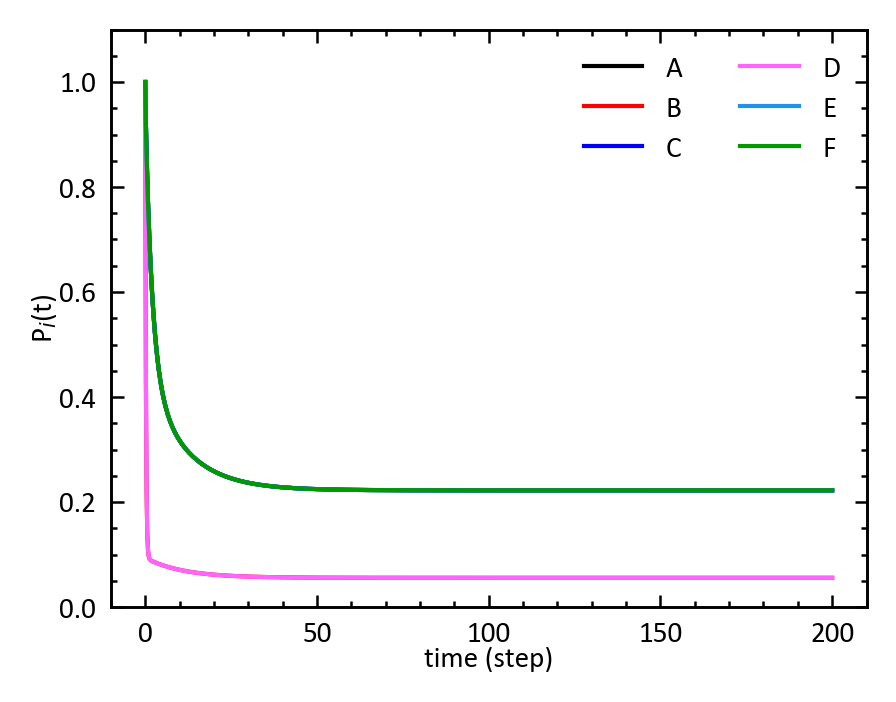

In [35]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
plt.plot(times, P[:, 3, 3], '-', label='D')
plt.plot(times, P[:, 4, 4], '-', label='E')
plt.plot(times, P[:, 5, 5], '-', label='F')

# plt.hlines(piA, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#F2E100', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## MSM

In [101]:
lagtime = 0.3
MSM_true, traj_discrete = MSMtraj(20000, Prob_t(uniqueStates, eig_val, eig_vec, lagtime))

In [102]:
traj_discrete

array([4, 4, 4, ..., 5, 5, 5])

In [103]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [104]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[3.844e+03, 3.440e+02, 1.220e+02, 1.600e+01, 7.000e+00, 5.000e+00],
       [3.330e+02, 3.100e+02, 3.470e+02, 4.200e+01, 2.300e+01, 2.400e+01],
       [1.210e+02, 3.420e+02, 3.777e+03, 3.000e+01, 7.000e+00, 4.000e+00],
       [2.200e+01, 4.800e+01, 2.300e+01, 3.360e+02, 3.860e+02, 3.250e+02],
       [9.000e+00, 2.100e+01, 9.000e+00, 3.670e+02, 4.183e+03, 1.480e+02],
       [9.000e+00, 1.400e+01, 3.000e+00, 3.490e+02, 1.300e+02, 3.919e+03]])

In [105]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [106]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=eig_vec[:,3] / np.sum(eig_vec[:,3])
)

In [107]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()

In [108]:
models = []
models2 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))

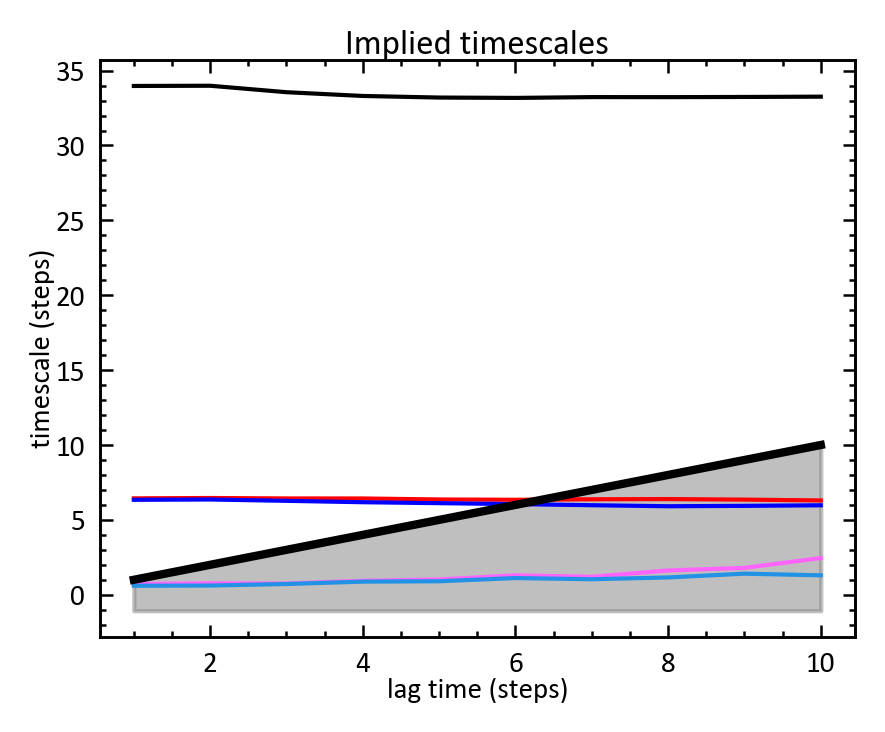

In [109]:
fig, ax = plt.subplots(1,1)
dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(models))

ax.set_title("Implied timescales")
ax.set_xlabel("lag time (steps)")
ax.set_ylabel("timescale (steps)")

plt.show()

In [110]:
np.exp(eig_val*lagtime)

array([0.19745177, 0.25924026, 0.86070798, 1.        , 0.97264213,
       0.86070798])

In [111]:
eig_vec

array([[ 2.49672854e-01,  2.88675135e-01,  7.07106781e-01,
         4.92365964e-01,  4.94889255e-01,  8.96912166e-03],
       [-6.12639316e-01, -5.77350269e-01,  1.09265624e-16,
         1.23091491e-01,  1.00842706e-01, -1.07705937e-19],
       [ 2.49672854e-01,  2.88675135e-01, -7.07106781e-01,
         4.92365964e-01,  4.94889255e-01, -8.96912166e-03],
       [ 6.12639316e-01, -5.77350269e-01, -7.39206103e-17,
         1.23091491e-01, -1.00842706e-01,  9.17244517e-18],
       [-2.49672854e-01,  2.88675135e-01, -1.03047419e-16,
         4.92365964e-01, -4.94889255e-01, -7.07049896e-01],
       [-2.49672854e-01,  2.88675135e-01, -1.03047419e-16,
         4.92365964e-01, -4.94889255e-01,  7.07049896e-01]])

In [112]:
print(MSM_true.eigenvalues())

[1.         0.97264213 0.86070798 0.86070798 0.25924026 0.19745177]


In [113]:
MSM_true.eigenvectors_left()

array([[ 2.22222222e-01,  5.55555556e-02,  2.22222222e-01,
         5.55555556e-02,  2.22222222e-01,  2.22222222e-01],
       [ 2.26485760e-01,  4.61506017e-02,  2.26485760e-01,
        -4.61506017e-02, -2.26485760e-01, -2.26485760e-01],
       [-1.81488321e-02, -3.16523202e-17,  1.81488321e-02,
         8.62615747e-18, -3.32838896e-01,  3.32838896e-01],
       [ 3.33333333e-01,  7.25956469e-17, -3.33333333e-01,
        -2.17909821e-17, -1.27551250e-16, -2.11639616e-16],
       [-7.85674201e-02,  1.57134840e-01, -7.85674201e-02,
         1.57134840e-01, -7.85674201e-02, -7.85674201e-02],
       [ 6.52668068e-02, -1.60149617e-01,  6.52668068e-02,
         1.60149617e-01, -6.52668068e-02, -6.52668068e-02]])

In [114]:
MSM_true.eigenvectors_right().T

array([[ 1.00000000e+00,  1.00000000e+00,  1.00000000e+00,
         1.00000000e+00,  1.00000000e+00,  1.00000000e+00],
       [ 1.01918592e+00,  8.30710830e-01,  1.01918592e+00,
        -8.30710830e-01, -1.01918592e+00, -1.01918592e+00],
       [-8.16697445e-02, -5.69741764e-16,  8.16697445e-02,
         1.55270835e-16, -1.49777503e+00,  1.49777503e+00],
       [ 1.50000000e+00,  1.30672164e-15, -1.50000000e+00,
        -3.92237678e-16, -5.73980623e-16, -9.52378272e-16],
       [-3.53553391e-01,  2.82842712e+00, -3.53553391e-01,
         2.82842712e+00, -3.53553391e-01, -3.53553391e-01],
       [ 2.93700631e-01, -2.88269310e+00,  2.93700631e-01,
         2.88269310e+00, -2.93700631e-01, -2.93700631e-01]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [115]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

5

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

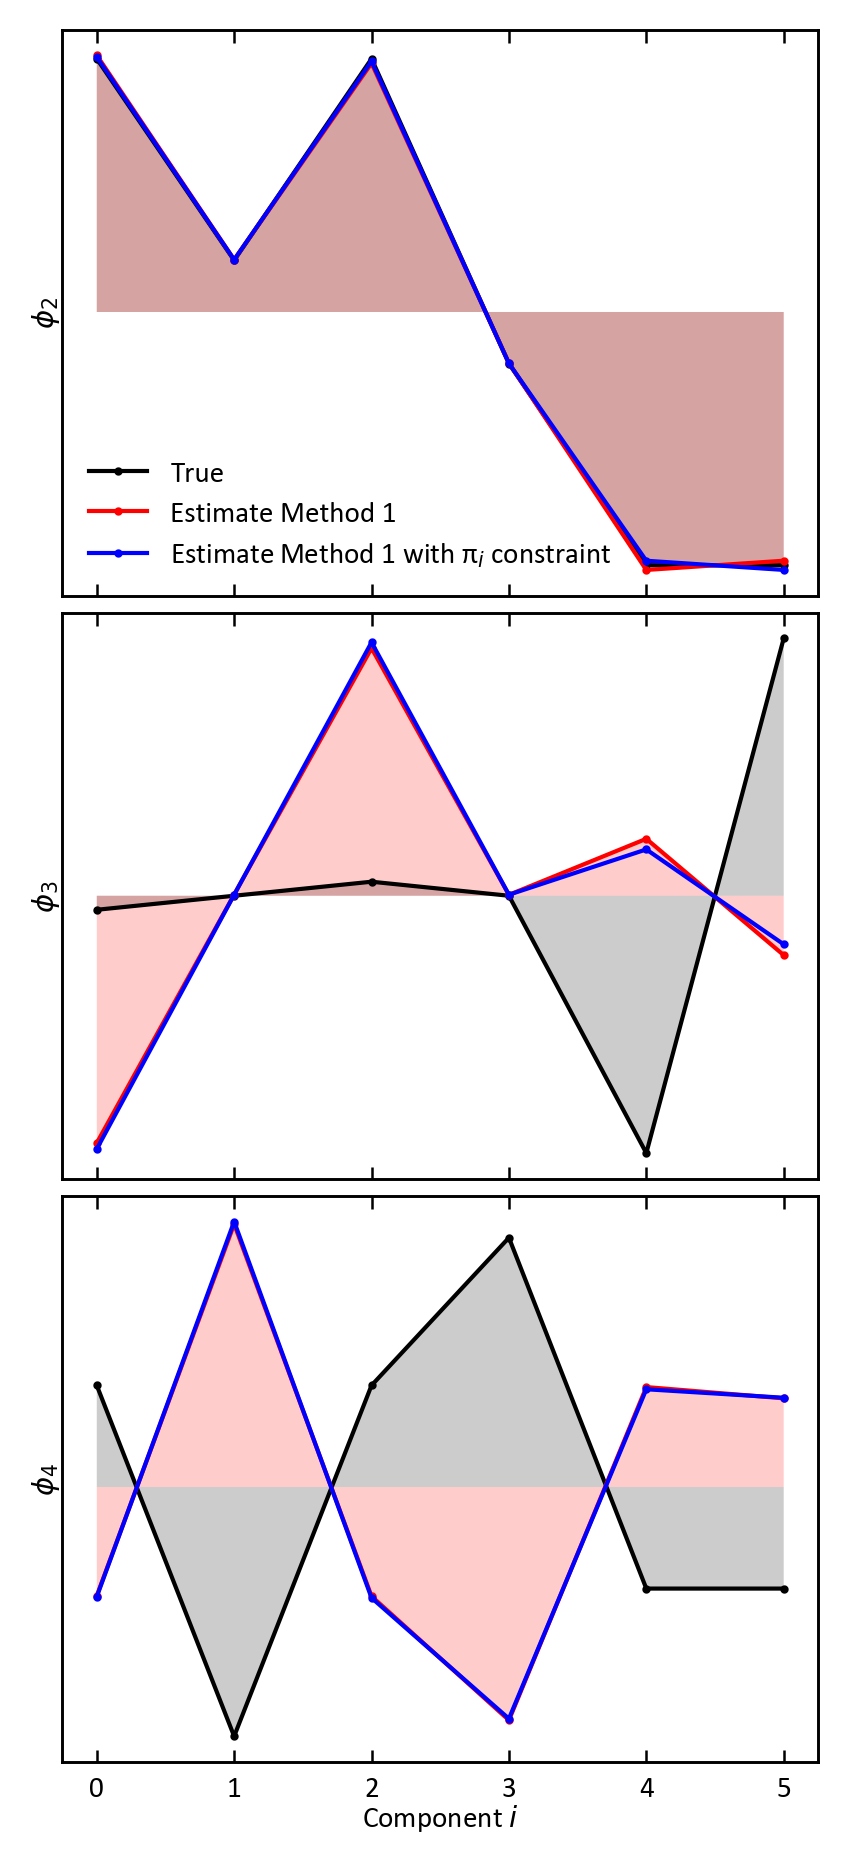

In [116]:
fig, axs = plt.subplots(3,1, figsize=(1*3.25, 3*2.5), sharex=True, sharey=False)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), MSM2.eigenvectors_left())
comps = np.arange(uniqueStates)

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
axs[0].fill_between(comps, esti1[1], alpha=0.2)
# axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
axs[1].fill_between(comps, esti1[2], alpha=0.2)
# axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])

i = 5
axs[2].plot(true[i], 'o-', label="True")
axs[2].plot(esti1[i], 'o-', label="Estimate Method 1")
axs[2].plot(esti1_con[i], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[2].fill_between(comps, true[i], alpha=0.2)
axs[2].fill_between(comps, esti1[i], alpha=0.2)
# axs[2].fill_between(comps, esti1_con[3], alpha=0.2, color=colorList[2])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[2].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
axs[2].set_ylabel(r"$\it{\phi}_4$")
axs[0].legend()

plt.show()

In [117]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())

[36.05024302  6.66666667  6.66666667  0.74074074  0.61642365]
[33.97473885  6.43732541  6.33997016  0.71806449  0.60159887]
[34.00455325  6.44608704  6.32745935  0.7184621   0.60208468]


In [118]:
rf = MSM_true.reactive_flux([0], [1])
rf2 = MSM.reactive_flux([0], [1])
rf3 = MSM2.reactive_flux([0], [1])

In [119]:
print(rf.backward_committor, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)

[1.         0.         0.26058772 0.26029604 0.2556761  0.2556761 ] [0.         1.         0.73941228 0.73970396 0.7443239  0.7443239 ]
[1.         0.         0.26205709 0.27865498 0.27753764 0.27774815] [0.         1.         0.73794291 0.72134502 0.72246236 0.72225185]
[1.         0.         0.261232   0.27787152 0.27672691 0.27694167] [0.         1.         0.738768   0.72212848 0.72327309 0.72305833]


In [120]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)

17.83608533670806
18.381200933433192
18.003026883730392


In [121]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)

0.05606611434752007
0.0544034094193008
0.05554621489254761


In [122]:
k_AB

0.5

In [123]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)

[0.22222222 0.05555556 0.22222222 0.05555556 0.22222222 0.22222222]
[0.21690306 0.05395073 0.21405117 0.05700305 0.23652869 0.22156332]
[0.22222222 0.05555556 0.22222222 0.05555556 0.22222222 0.22222222]


In [124]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)

[[0.00000000e+00 1.72478236e-02 4.49732514e-03 7.71171178e-04
  1.85643670e-04 1.85643670e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.49457102e-03 0.00000000e+00 2.00957738e-04
  4.83764604e-05 4.83764604e-05]
 [0.00000000e+00 6.12107375e-04 2.00653652e-04 0.00000000e+00
  3.34167208e-03 3.34167208e-03]
 [0.00000000e+00 2.66552634e-04 4.71514411e-05 3.26198814e-03
  0.00000000e+00 1.15749660e-03]
 [0.00000000e+00 2.66552634e-04 4.71514411e-05 3.26198814e-03
  1.15749660e-03 0.00000000e+00]]
[[0.00000000e+00 1.69252336e-02 4.48304702e-03 6.85300905e-04
  2.88790824e-04 2.52997365e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.51397612e-03 0.00000000e+00 2.50476860e-04
  7.56793552e-05 3.31497328e-05]
 [0.00000000e+00 6.26994693e-04 2.72469718e-04 0.00000000e+00
  3.78733507e-03 3.39408893e-03]
 [0.00000000e+00 3.05086241e-04 8.18673903e-05 3.

In [125]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)

[[0.00000000e+00 1.72478236e-02 4.49732514e-03 7.71171178e-04
  1.85643670e-04 1.85643670e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.49457102e-03 0.00000000e+00 3.04085994e-07
  1.22501930e-06 1.22501930e-06]
 [0.00000000e+00 6.12107375e-04 0.00000000e+00 0.00000000e+00
  7.96839446e-05 7.96839446e-05]
 [0.00000000e+00 2.66552634e-04 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 2.66552634e-04 0.00000000e+00 0.00000000e+00
  4.11996826e-18 0.00000000e+00]]
[[0.00000000e+00 1.69252336e-02 4.48304702e-03 6.85300905e-04
  2.88790824e-04 2.52997365e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 4.51397612e-03 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 6.26994693e-04 2.19928581e-05 0.00000000e+00
  2.10202371e-05 1.52931130e-05]
 [0.00000000e+00 3.05086241e-04 6.18803512e-06 0.

In [126]:
traj_discrete.shape

(20000,)

In [127]:
traj_discrete[:32]

array([4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

In [128]:
state_durations = stateDurations(uniqueStates, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [129]:
state_durations[0]

[5,
 6,
 3,
 5,
 7,
 11,
 2,
 3,
 9,
 1,
 11,
 9,
 4,
 5,
 10,
 1,
 3,
 6,
 7,
 4,
 18,
 5,
 5,
 10,
 13,
 3,
 2,
 36,
 17,
 13,
 13,
 17,
 7,
 3,
 3,
 9,
 9,
 11,
 10,
 1,
 5,
 4,
 24,
 6,
 4,
 66,
 4,
 10,
 6,
 13,
 19,
 15,
 3,
 2,
 3,
 1,
 2,
 3,
 15,
 4,
 1,
 9,
 34,
 5,
 1,
 1,
 16,
 9,
 4,
 2,
 8,
 3,
 4,
 2,
 8,
 16,
 9,
 19,
 6,
 1,
 2,
 3,
 15,
 7,
 3,
 15,
 3,
 5,
 6,
 12,
 3,
 17,
 7,
 15,
 16,
 9,
 7,
 4,
 4,
 8,
 5,
 5,
 13,
 14,
 23,
 20,
 4,
 2,
 11,
 8,
 1,
 5,
 6,
 1,
 5,
 16,
 4,
 1,
 2,
 19,
 3,
 2,
 5,
 10,
 14,
 11,
 1,
 21,
 4,
 35,
 7,
 19,
 10,
 15,
 3,
 31,
 2,
 8,
 3,
 17,
 2,
 3,
 3,
 21,
 11,
 4,
 16,
 14,
 8,
 3,
 5,
 23,
 1,
 1,
 38,
 16,
 2,
 4,
 13,
 17,
 11,
 2,
 8,
 2,
 15,
 3,
 10,
 8,
 28,
 2,
 1,
 15,
 12,
 5,
 13,
 5,
 8,
 12,
 1,
 17,
 1,
 23,
 3,
 10,
 5,
 5,
 21,
 16,
 24,
 2,
 19,
 4,
 1,
 3,
 11,
 5,
 39,
 2,
 2,
 18,
 2,
 5,
 6,
 10,
 3,
 5,
 1,
 2,
 3,
 3,
 4,
 11,
 7,
 3,
 13,
 3,
 14,
 8,
 5,
 1,
 10,
 5,
 4,
 6,
 1,
 1,
 14,
 8,
 2,
 20,

In [130]:
avg_state_durations

{0: 8.781376518218623,
 1: 1.4031209362808843,
 2: 8.494047619047619,
 3: 1.4179104477611941,
 4: 8.550541516245488,
 5: 8.74851485148515}

In [131]:
ProbMat = ProbMatrix(uniqueStates, traj_discrete)

In [132]:
ProbMat

array([[0.        , 0.69635628, 0.24696356, 0.03238866, 0.01417004,
        0.01012146],
       [0.43302991, 0.        , 0.45123537, 0.05461638, 0.02990897,
        0.03120936],
       [0.24007937, 0.67857143, 0.        , 0.05952381, 0.01388889,
        0.00793651],
       [0.02736318, 0.05970149, 0.02860697, 0.        , 0.4800995 ,
        0.40422886],
       [0.01624549, 0.03790614, 0.01624549, 0.66245487, 0.        ,
        0.26714801],
       [0.01782178, 0.02772277, 0.00594059, 0.69108911, 0.25742574,
        0.        ]])

In [133]:
np.sum(ProbMat, axis=1)

array([1., 1., 1., 1., 1., 1.])

In [134]:
MSM_true.transition_matrix

array([[0.88807831, 0.07761521, 0.02737034, 0.00469143, 0.00112236,
        0.00112236],
       [0.31046083, 0.29921843, 0.31046083, 0.04232847, 0.01876573,
        0.01876573],
       [0.02737034, 0.07761521, 0.88807831, 0.00469143, 0.00112236,
        0.00112236],
       [0.01876573, 0.04232847, 0.01876573, 0.29921843, 0.31046083,
        0.31046083],
       [0.00112236, 0.00469143, 0.00112236, 0.07761521, 0.88807831,
        0.02737034],
       [0.00112236, 0.00469143, 0.00112236, 0.07761521, 0.02737034,
        0.88807831]])

In [135]:
MSM.transition_matrix

array([[8.86122646e-01, 7.80313287e-02, 2.80081780e-02, 4.37998477e-03,
        1.84290308e-03, 1.61495961e-03],
       [3.13716499e-01, 2.87303061e-01, 3.19275825e-01, 4.17061156e-02,
        2.03752723e-02, 1.76232278e-02],
       [2.83813423e-02, 8.04721773e-02, 8.82270506e-01, 6.19029106e-03,
        1.86744876e-03, 8.18234645e-04],
       [1.66663387e-02, 3.94728959e-02, 2.32450562e-02, 2.94736840e-01,
        3.30030160e-01, 2.95848709e-01],
       [1.68999080e-03, 4.64747334e-03, 1.68998350e-03, 7.95367555e-02,
        8.83048335e-01, 2.93874619e-02],
       [1.58099124e-03, 4.29126066e-03, 7.90492199e-04, 7.61149336e-02,
        3.13724209e-02, 8.85849901e-01]])

In [136]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [137]:
mfpt

array([2.63441296, 0.42093628, 2.54821429, 0.42537313, 2.56516245,
       2.62455446])

In [138]:
print(1/k_AB, 1/k_BA, 1/k_CB,)

2.0 0.5 2.0


In [139]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [140]:
inv_mfpt_X1

array([[0.37959121, 0.37959121, 0.37959121, 0.37959121, 0.37959121,
        0.37959121],
       [2.37565647, 2.37565647, 2.37565647, 2.37565647, 2.37565647,
        2.37565647],
       [0.39243167, 0.39243167, 0.39243167, 0.39243167, 0.39243167,
        0.39243167],
       [2.35087719, 2.35087719, 2.35087719, 2.35087719, 2.35087719,
        2.35087719],
       [0.38983886, 0.38983886, 0.38983886, 0.38983886, 0.38983886,
        0.38983886],
       [0.38101705, 0.38101705, 0.38101705, 0.38101705, 0.38101705,
        0.38101705]])

In [141]:
print(k_AB, k_BA, k_BC, k_BD, k_CB)

0.5 2 2 0.5 0.5


In [142]:
ProbMat * inv_mfpt_X1

array([[0.        , 0.26433072, 0.0937452 , 0.01229445, 0.00537882,
        0.00384202],
       [1.02873031, 0.        , 1.07198023, 0.12974977, 0.07105344,
        0.07414272],
       [0.09421475, 0.26629292, 0.        , 0.02335903, 0.00545044,
        0.00311454],
       [0.06432749, 0.14035088, 0.06725146, 0.        , 1.12865497,
        0.9502924 ],
       [0.00633312, 0.01477729, 0.00633312, 0.25825065, 0.        ,
        0.10414468],
       [0.0067904 , 0.01056285, 0.00226347, 0.26331673, 0.0980836 ,
        0.        ]])

$A \leftrightharpoons B \leftrightharpoons C$ \
$D \leftrightharpoons B$ \
$E \leftrightharpoons D \leftrightharpoons F$ \
k$_{A \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow A} = 2/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{B \rightarrow D} = 0.5/step$ \
k$_{D \rightarrow B} = 0.5/step$ \
k$_{E \rightarrow D} = 0.5/step$ \
k$_{D \rightarrow E} = 2/step$ \
k$_{D \rightarrow F} = 2/step$ \
k$_{F \rightarrow D} = 0.5/step$

Looking at these estimates it does seem like one can compute estimates of the rate constants with enough sampling

# Three State Cycle model

$\cdots A \leftrightharpoons B \leftrightharpoons C \cdots$ \
k$_{A \rightarrow B} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{C \rightarrow A} = 1/step$ \
k$_{A \rightarrow C} = 0.5/step$ 

In [143]:
k_AB, k_BA, k_BC, k_CB, k_CA, k_AC = [2, 0.5, 2, 0.5, 1, 0.5]

In [144]:
#                           A               B               C
Q = np.array([[-(k_AB + k_AC),           k_AB,           k_AC],  # A
              [          k_BA, -(k_BA + k_BC),           k_BC],  # B
              [          k_CA,           k_CB, -(k_CA + k_CB)]]) # C

In [145]:
uniqueStates = 3

## Algebric expresions

In [14]:
delta = np.array([k_AB**3 * k_BA**2 * k_BC, k_AB**3 * k_BC**3, 2 * k_AB**3 * k_BA * k_BC**2, 
                  3 * k_AB**2 * k_AC * k_BC**3, 
                  3 * k_AB * k_AC**2 * k_BC**3 , k_AB**2 * k_AC * k_BA**3 , 2 * k_AB * k_AC**2 * k_BA**3, 
                  7 * k_AB * k_AC**2 * k_BA**2 * k_BC , k_AC**3 * k_BC**2 * k_CB , 2 * k_AC**3 * k_BA * k_BC * k_CB, 
                  k_AC**3 * k_BA**2 * k_CB , 6 * k_AB * k_AC**2 * k_BA * k_BC * k_CB , 3 * k_AB * k_AC**2 * k_BA**2 * k_CB,
                  3 * k_AB**2 * k_AC * k_BA**2 * k_CB , 3 * k_AB * k_AC**2 * k_BC**2 * k_CB, 
                  3 * k_AB**2 * k_AC * k_BC**2 * k_CB, 6 * k_AB**2 * k_AC * k_BA * k_BC * k_CB, k_AB**3 * k_BC**2 * k_CB, 
                  k_AB**3 * k_BA * k_BC * k_CB , k_AB * k_AC**2 * k_BC**2 * k_CA, 2 * k_AB * k_AC**2 * k_BA * k_BC * k_CA, 
                  k_AB * k_AC**2 * k_BA**2 * k_CA , 2 * k_AB**2 * k_AC * k_BC**2 * k_CA, k_AB**3 * k_BC**2 * k_CA, 
                  k_AB**3 * k_BA * k_BC * k_CB , 4 * k_AB**2 * k_AC * k_BA * k_BC * k_CA, 
                  2 * k_AB**2 * k_AC * k_BA**2 * k_CA , 2 * k_AB**3 * k_BA * k_BC * k_CA , k_AB**3 * k_BA**2 * k_CA, 
                  k_AB**3 * k_BA**2 * k_CB , k_AC**2 * k_BC **3 * k_CA , 3 * k_AC**2 * k_BA * k_BC**2 * k_CA, 
                  k_AC**2 * k_BA * k_BC**2 * k_CB , 3 * k_AC**2 * k_BA**2 * k_BC * k_CA , 2 * k_AC**2 * k_BA**2 * k_BC * k_CB, 
                  k_AC**2 * k_BA**3 * k_CB , k_AC**2 * k_BA**3 * k_CA , 2 * k_AB * k_AC * k_BC**3 * k_CA , k_AB**2 * k_BC**3 * k_CA, 
                  2 * k_AB * k_AC * k_BA * k_BC**2 * k_CB , k_AB**2 * k_BA * k_BC**2 * k_CB, 
                  4 * k_AB * k_AC * k_BA**2 * k_BC * k_CB , 2 * k_AB**2 * k_BA**2 * k_BC * k_CB, 
                  6 * k_AB * k_AC * k_BA * k_BC**2 * k_CA , 3 * k_AB**2 * k_BA * k_BC**2 * k_CA, 
                  6 * k_AB * k_AC * k_BA**2 * k_BC * k_CA , 3 * k_AB**2 * k_BA**2 * k_BC * k_CA , 
                  2 * k_AB * k_AC * k_BA**3 * k_CA, 
                  k_AB**2 * k_BA**3 * k_CA, 2 * k_AB * k_AC * k_BA**3 * k_CB , k_AB**2 * k_BA**3 * k_CB , k_AC**3 * k_BA**3, 
                  k_AC**3 * k_BC**3 , 3 * k_AC**3 * k_BA**2 * k_BC , 3 * k_AC**3 * k_BA * k_BC**2, 
                  5 * k_AB**2 * k_AC * k_BA**2 * k_BC , 7 * k_AB**2 * k_AC * k_BA * k_BC**2, 
                  8 * k_AB * k_AC**2 * k_BA * k_BC**2])

In [15]:
np.sum(delta)

439.453125

In [8]:
delta = (k_AB**3 * k_BA**2 * k_BC + k_AB**3 * k_BC**3 + 2 * k_AB**3 * k_BA * k_BC**2 + 3 * k_AB**2 * k_AC * k_BC**3 \
         + 3 * k_AB * k_AC**2 * k_BC**3 + k_AB**2 * k_AC * k_BA**3 + 2 * k_AB * k_AC**2 * k_BA**3 \
         + 7 * k_AB * k_AC**2 * k_BA**2 * k_BC \
         + k_AC**3 * k_BC**2 * k_CB + 2 * k_AC**3 * k_BA * k_BC * k_CB + k_AC**3 * k_BA**2 * k_CB \
         + 6 * k_AB * k_AC**2 * k_BA * k_BC * k_CB + 3 * k_AB * k_AC**2 * k_BA**2 * k_CB \
         + 3 * k_AB**2 * k_AC * k_BA**2 * k_CB + 3 * k_AB * k_AC**2 * k_BC**2 * k_CB \
         + 3 * k_AB**2 * k_AC * k_BC**2 * k_CB + 6 * k_AB**2 * k_AC * k_BA * k_BC * k_CB \
         + k_AB**3 * k_BC**2 * k_CB + k_AB**3 * k_BA * k_BC * k_CB + k_AB * k_AC**2 * k_BC**2 * k_CA \
         + 2 * k_AB * k_AC**2 * k_BA * k_BC * k_CA + k_AB * k_AC**2 * k_BA**2 * k_CA \
         + 2 * k_AB**2 * k_AC * k_BC**2 * k_CA + k_AB**3 * k_BC**2 * k_CA + k_AB**3 * k_BA * k_BC * k_CB \
         + 4 * k_AB**2 * k_AC * k_BA * k_BC * k_CA + 2 * k_AB**2 * k_AC * k_BA**2 * k_CA + 2 * k_AB**3 * k_BA * k_BC * k_CA \
         + k_AB**3 * k_BA**2 * k_CA + k_AB**3 * k_BA**2 * k_CB + k_AC**2 * k_BC **3 * k_CA \
         + 3 * k_AC**2 * k_BA * k_BC**2 * k_CA + k_AC**2 * k_BA * k_BC**2 * k_CB + 3 * k_AC**2 * k_BA**2 * k_BC * k_CA \
         + 2 * k_AC**2 * k_BA**2 * k_BC * k_CB + k_AC**2 * k_BA**3 * k_CB + k_AC**2 * k_BA**3 * k_CA \
         + 2 * k_AB * k_AC * k_BC**3 * k_CA + k_AB**2 * k_BC**3 * k_CA + 2 * k_AB * k_AC * k_BA * k_BC**2 * k_CB \
         + k_AB**2 * k_BA * k_BC**2 * k_CB + 4 * k_AB * k_AC * k_BA**2 * k_BC * k_CB + 2 * k_AB**2 * k_BA**2 * k_BC * k_CB \
         + 6 * k_AB * k_AC * k_BA * k_BC**2 * k_CA + 3 * k_AB**2 * k_BA * k_BC**2 * k_CA \
         + 6 * k_AB * k_AC * k_BA**2 * k_BC * k_CA + 3 * k_AB**2 * k_BA**2 * k_BC * k_CA + 2 * k_AB * k_AC * k_BA**3 * k_CA \
         + k_AB**2 * k_BA**3 * k_CA + 2 * k_AB * k_AC * k_BA**3 * k_CB \
         + k_AB**2 * k_BA**3 * k_CB + k_AC**3 * k_BA**3 + k_AC**3 * k_BC**3 + 3 * k_AC**3 * k_BA**2 * k_BC \
         + 3 * k_AC**3 * k_BA * k_BC**2 + 5 * k_AB**2 * k_AC * k_BA**2 * k_BC + 7 * k_AB**2 * k_AC * k_BA * k_BC**2 \
         + 8 * k_AB * k_AC**2 * k_BA * k_BC**2)

In [9]:
delta_ = (k_AB + k_AC) * (k_BA + k_BC)
delta__ = (k_AB + k_AC) * (k_BA + k_BC) * (k_AB + k_AC)
delta___ = (k_AB**3 * k_BA**2 * k_BC + 2 * k_AB**3 * k_BA * k_BC**2 + 5 * k_AB**2 * k_AC * k_BA**2 * k_BC \
           + 7 * k_AB**2 * k_AC * k_BA * k_BC**2 + 8 * k_AB * k_AC**2 * k_BA * k_BC**2 + k_AB**2 * k_AC * k_BA**3 \
           + 2 * k_AB * k_AC**2 * k_BA**3 + 7 * k_AB * k_AC**2 * k_BA**2 * k_BC \
           + k_AC**3 * k_BA**3 + 3 * k_AC**3 * k_BA**2 * k_BC + 3 * k_AC**3 * k_BA * k_BC**2 + k_AB**3 * k_BC**3 \
           + 3 * k_AB**2 * k_AC * k_BC**3 + 3 * k_AB * k_AC**2 * k_BC**3 + k_AC**3 * k_BC**3)

In [10]:
piC = delta___ / delta
piA = (delta_ / (delta_ - k_AB * k_BA)) * ((k_BA * k_CB * (k_AB + k_AC) + k_CA * delta_) / delta__) * piC
piB = (k_AB * delta_ * (k_BA * k_CB * (k_AB + k_AC) + k_CA * delta_) + k_CB * delta__ * (delta_ - k_AB * k_BA)) / delta___ * piC
piA, piB, piC

(0.24444444444444446, 0.2888888888888889, 0.4666666666666667)

In [11]:
piA + piB + piC

1.0

## SVD

In [146]:
eig_val, eig_vec = SVD(Q)

In [13]:
eig_val

array([-2.74892278e-16+0.j       , -3.25000000e+00+0.8291562j,
       -3.25000000e+00-0.8291562j])

In [14]:
eig_vec[:,0] / np.sum(eig_vec[:,0])

array([0.24444444-0.j, 0.28888889-0.j, 0.46666667-0.j])

In [15]:
np.sum(eig_vec[:,0] / np.sum(eig_vec[:,0]))

(0.9999999999999999+0j)

## Simulation

In [14]:
times = np.linspace(0, 40, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [15]:
P = np.stack(P)

In [16]:
P.shape

(1000, 3, 3)

In [17]:
# is the unique and true solution?
P[-1]

array([[0.24444444, 0.28888889, 0.46666667],
       [0.24444444, 0.28888889, 0.46666667],
       [0.24444444, 0.28888889, 0.46666667]])

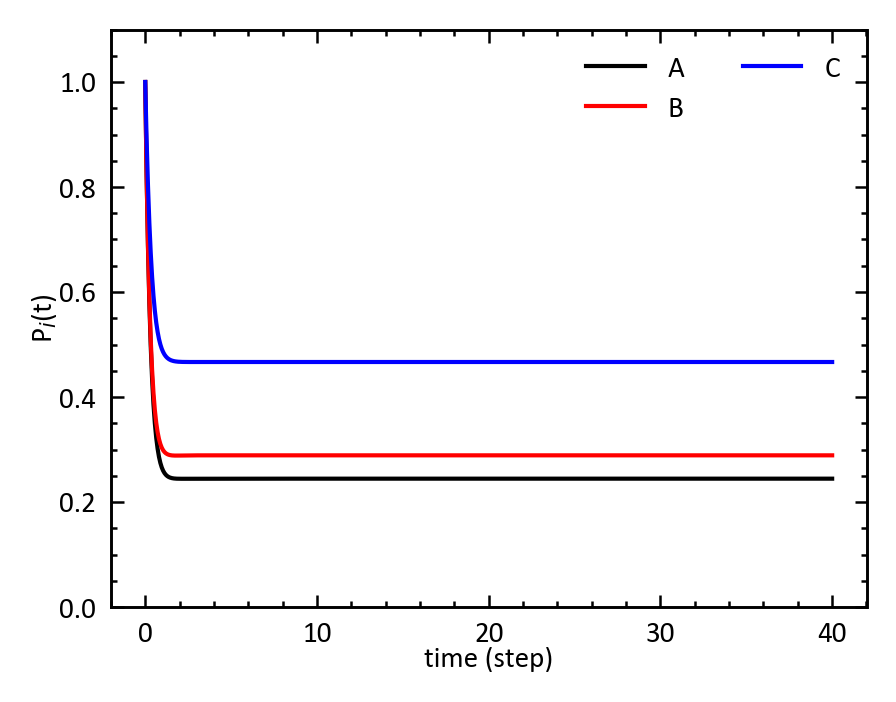

In [18]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
# plt.plot(times, P[:, 3, 3], '-', label='D')
# plt.plot(times, P[:, 4, 4], '-', label='E')
# plt.plot(times, P[:, 5, 5], '-', label='F')

# plt.hlines(piA, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#F2E100', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## MSM

In [147]:
Prob_t(uniqueStates, eig_val, eig_vec, lagtime)

array([[0.51568519-3.46944695e-17j, 0.30211449-5.55111512e-17j,
        0.18220032-1.11022302e-16j],
       [0.12210359+0.00000000e+00j, 0.52770454+4.16333634e-17j,
        0.35019187+0.00000000e+00j],
       [0.17810077-6.93889390e-18j, 0.13412293+5.55111512e-17j,
        0.68777629+1.73472348e-17j]])

In [148]:
np.real(Prob_t(uniqueStates, eig_val, eig_vec, lagtime))

array([[0.51568519, 0.30211449, 0.18220032],
       [0.12210359, 0.52770454, 0.35019187],
       [0.17810077, 0.13412293, 0.68777629]])

In [149]:
lagtime = 0.2
MSM_true, traj_discrete = MSMtraj(30000, np.real(Prob_t(uniqueStates, eig_val, eig_vec, lagtime)))

In [150]:
traj_discrete

array([2, 0, 0, ..., 2, 2, 1])

In [151]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [152]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[ 4671.,  1795.,   872.],
       [  726.,  5454.,  2381.],
       [ 1941.,  1313., 10846.]])

In [153]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [154]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=eig_vec[:,0] / np.sum(eig_vec[:,0])
)

In [155]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()

C:\Users\ramon\anaconda3\envs\deeptime-env\Lib\site-packages\deeptime\markov\tools\estimation\dense\mle.py:51: ComplexWarning: Casting complex values to real discards the imaginary part
  c_mu = mu.astype(dtype, order='C', copy=False)


In [156]:
models = []
models2 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))

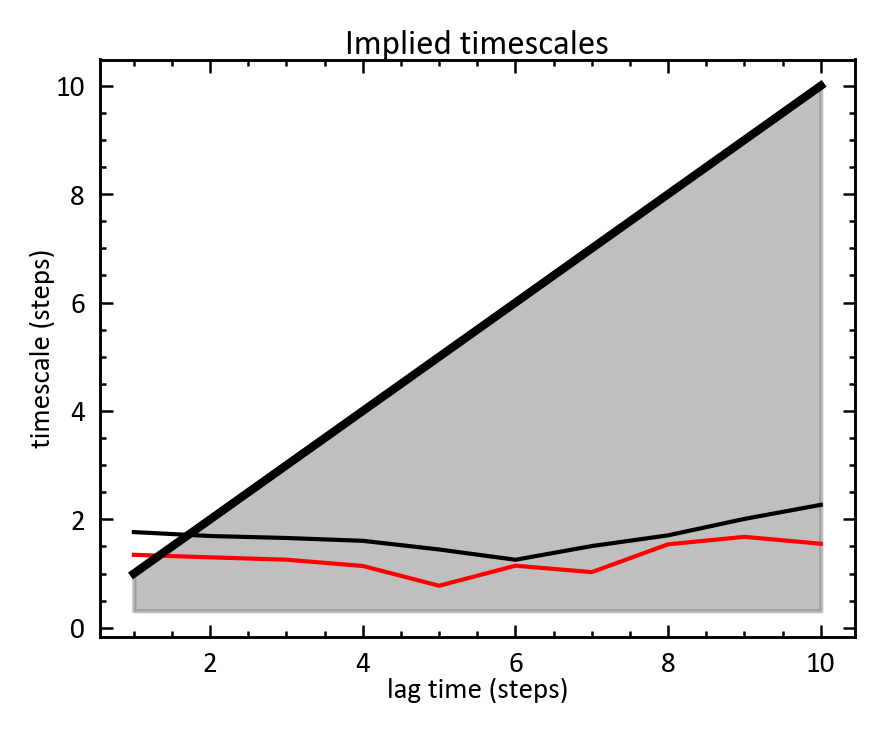

In [157]:
fig, ax = plt.subplots(1,1)
dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(models2))

ax.set_title("Implied timescales")
ax.set_xlabel("lag time (steps)")
ax.set_ylabel("timescale (steps)")

plt.show()

In [158]:
np.exp(eig_val*lagtime)

array([1.        +0.j        , 0.51488408+0.08617526j,
       0.51488408-0.08617526j])

In [159]:
eig_vec

array([[-0.4068497 +0.j        , -0.10910895+0.36187343j,
        -0.10910895-0.36187343j],
       [-0.48082237+0.j        ,  0.65465367+0.j        ,
         0.65465367-0.j        ],
       [-0.77671306+0.j        , -0.54554473-0.36187343j,
        -0.54554473+0.36187343j]])

In [160]:
print(MSM_true.eigenvalues())

[1.        +0.j         0.51488408-0.08617526j 0.51488408+0.08617526j]


In [161]:
MSM_true.eigenvectors_left()

array([[ 0.24444444+4.09519831e-18j,  0.28888889-3.30853176e-17j,
         0.46666667+2.89901193e-17j],
       [ 0.46808043-3.32074257e-02j, -0.17897193+7.92827289e-01j,
        -0.2891085 -7.59619863e-01j],
       [ 0.46808043+3.32074257e-02j, -0.17897193-7.92827289e-01j,
        -0.2891085 +7.59619863e-01j]])

In [162]:
MSM_true.eigenvectors_right().T

array([[ 1.        -1.67530840e-17j,  1.        -1.67530840e-17j,
         1.        -1.67530840e-17j],
       [ 0.80707877-0.00000000e+00j, -0.23302979-3.95861457e-01j,
        -0.27849901+2.45057092e-01j],
       [ 0.80707877+0.00000000e+00j, -0.23302979+3.95861457e-01j,
        -0.27849901-2.45057092e-01j]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [163]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

2

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

C:\Users\ramon\anaconda3\envs\deeptime-env\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\ramon\anaconda3\envs\deeptime-env\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\ramon\anaconda3\envs\deeptime-env\Lib\site-packages\matplotlib\axes\_axes.py:5484: ComplexWarning: Casting complex values to real discards the imaginary part
  pts[1:N+1, 1] = dep1slice


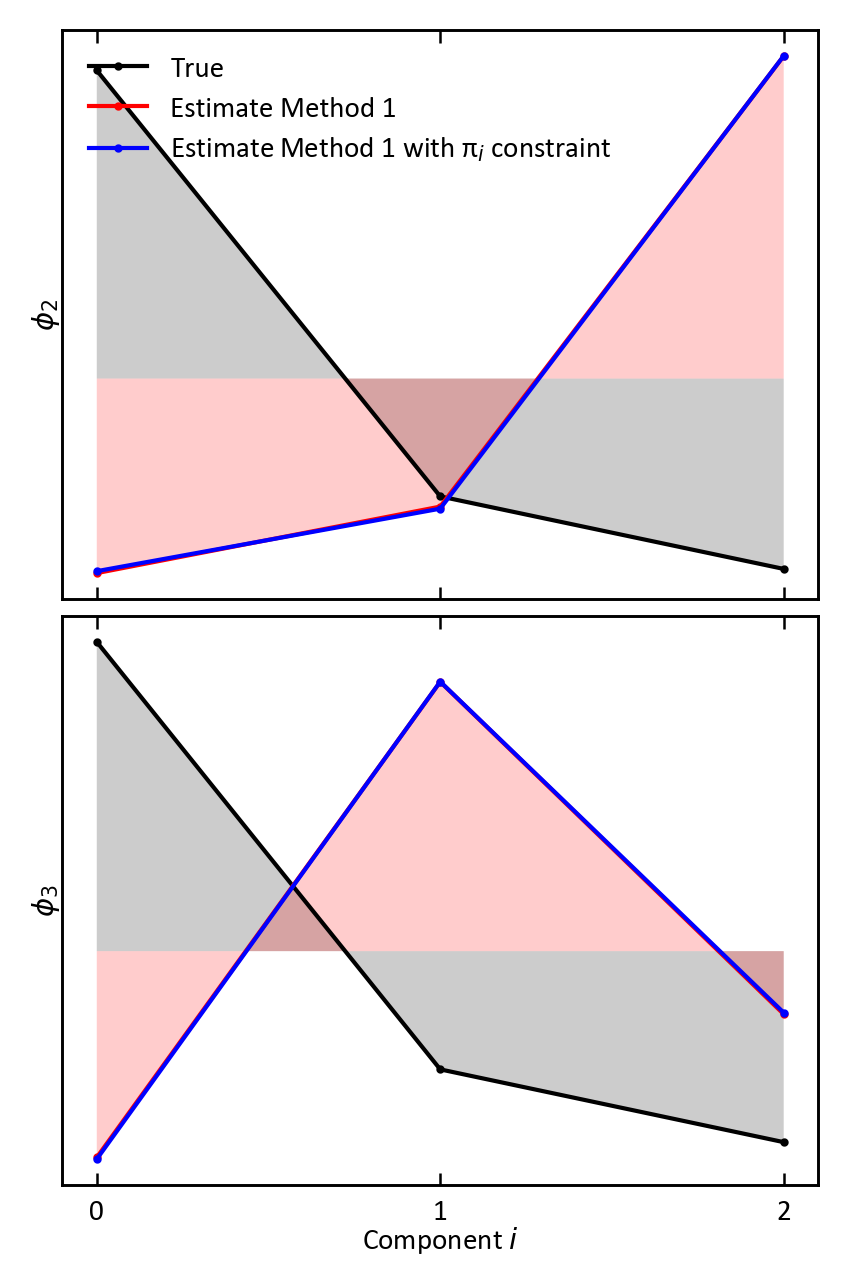

In [164]:
fig, axs = plt.subplots(2,1, figsize=(1*3.25, 2*2.5), sharex=True, sharey=False)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), MSM2.eigenvectors_left())
comps = np.arange(uniqueStates)

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
axs[0].fill_between(comps, esti1[1], alpha=0.2)
# axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
axs[1].fill_between(comps, esti1[2], alpha=0.2)
# axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])

# i = 5
# axs[2].plot(true[i], 'o-', label="True")
# axs[2].plot(esti1[i], 'o-', label="Estimate Method 1")
# axs[2].plot(esti1_con[i], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

# axs[2].fill_between(comps, true[i], alpha=0.2)
# axs[2].fill_between(comps, esti1[i], alpha=0.2)
# axs[2].fill_between(comps, esti1_con[3], alpha=0.2, color=colorList[2])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
# axs[2].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
# axs[2].set_yticks([])
axs[1].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
# axs[2].set_ylabel(r"$\it{\phi}_4$")
axs[0].legend()

plt.show()

In [165]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())

[1.53846154 1.53846154]
[1.76804007 1.34262269]
[1.76565962 1.34619539]


C:\Users\ramon\anaconda3\envs\deeptime-env\Lib\site-packages\deeptime\markov\tools\analysis\_decomposition.py:496: ImaginaryEigenValueWarning: Using eigenvalues with non-zero imaginary part
  warnings.warn('Using eigenvalues with non-zero imaginary part', ImaginaryEigenValueWarning)


In [166]:
rf = MSM_true.reactive_flux([0], [1])
rf2 = MSM.reactive_flux([0], [1])
rf3 = MSM2.reactive_flux([0], [1])

In [167]:
print(rf.backward_committor, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)

[1.         0.         0.26969013] [0.         1.         0.40315243]
[1.         0.         0.43227791] [0.         1.         0.56772209]
[1.         0.         0.43015466] [0.         1.         0.56984534]


In [168]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)

5.064781736753592
6.523356796831173
(6.46096082490913+0j)


In [169]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)

0.19744187449249823
0.15329530963042928
(0.1547757411165025+0j)


In [170]:
k_AB

2

In [171]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)

[0.24444444 0.28888889 0.46666667]
[0.24461512 0.28544423 0.46994065]
[0.24444444-0.j 0.28888889-0.j 0.46666667-0.j]


In [172]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)

[[0.         0.06121554 0.01189715]
 [0.         0.         0.        ]
 [0.         0.01189715 0.        ]]
[[0.         0.04202367 0.02661585]
 [0.         0.         0.        ]
 [0.         0.02661585 0.        ]]
[[0.        +0.j 0.04232796+0.j 0.02657561+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.02657561+0.j 0.        +0.j]]


In [173]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)

[[0.         0.06121554 0.01189715]
 [0.         0.         0.        ]
 [0.         0.01189715 0.        ]]
[[0.         0.04202367 0.02661585]
 [0.         0.         0.        ]
 [0.         0.02661585 0.        ]]
[[0.        +0.j 0.04232796+0.j 0.02657561+0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.02657561+0.j 0.        +0.j]]


In [174]:
traj_discrete.shape

(30000,)

In [175]:
traj_discrete[:32]

array([2, 0, 0, 0, 1, 2, 0, 0, 0, 0, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 2, 2,
       2, 2, 2, 2, 1, 1, 0, 0, 0, 2])

In [176]:
state_durations = stateDurations(uniqueStates, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [177]:
state_durations[0]

[3,
 4,
 5,
 3,
 1,
 10,
 1,
 1,
 3,
 1,
 4,
 2,
 4,
 2,
 8,
 1,
 3,
 6,
 2,
 1,
 1,
 3,
 4,
 1,
 5,
 1,
 5,
 4,
 3,
 6,
 5,
 1,
 1,
 1,
 2,
 6,
 1,
 1,
 1,
 5,
 2,
 3,
 2,
 3,
 3,
 3,
 1,
 6,
 4,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 4,
 2,
 3,
 4,
 4,
 2,
 1,
 1,
 2,
 5,
 2,
 4,
 1,
 5,
 3,
 6,
 1,
 2,
 3,
 3,
 1,
 1,
 4,
 2,
 1,
 3,
 1,
 3,
 3,
 3,
 1,
 2,
 2,
 11,
 4,
 1,
 2,
 1,
 4,
 1,
 1,
 1,
 2,
 3,
 6,
 2,
 3,
 2,
 1,
 1,
 8,
 1,
 2,
 4,
 4,
 1,
 1,
 1,
 2,
 1,
 2,
 3,
 6,
 3,
 2,
 3,
 4,
 1,
 1,
 2,
 4,
 3,
 2,
 2,
 1,
 3,
 5,
 2,
 14,
 1,
 1,
 4,
 7,
 4,
 3,
 2,
 2,
 2,
 7,
 3,
 6,
 1,
 6,
 1,
 2,
 1,
 7,
 1,
 1,
 1,
 6,
 2,
 1,
 1,
 2,
 4,
 1,
 5,
 2,
 14,
 2,
 1,
 1,
 5,
 1,
 1,
 2,
 1,
 1,
 3,
 1,
 2,
 4,
 2,
 3,
 2,
 1,
 2,
 4,
 7,
 1,
 1,
 5,
 8,
 1,
 3,
 1,
 1,
 1,
 1,
 6,
 2,
 3,
 2,
 2,
 2,
 2,
 6,
 1,
 5,
 4,
 3,
 1,
 1,
 4,
 1,
 5,
 1,
 2,
 8,
 2,
 4,
 3,
 2,
 2,
 1,
 1,
 1,
 1,
 4,
 6,
 1,
 2,
 3,
 2,
 2,
 3,
 2,
 3,
 4,
 4,
 2,
 2,
 2,
 4,
 12,
 1,
 2,
 3,
 4,
 4,
 1,

In [178]:
avg_state_durations

{0: 2.75140607424072, 1: 2.755391052462182, 2: 4.333128457283344}

In [179]:
ProbMat = ProbMatrix(uniqueStates, traj_discrete)

In [180]:
ProbMat

array([[0.        , 0.67304087, 0.32695913],
       [0.23366592, 0.        , 0.76633408],
       [0.59649662, 0.40350338, 0.        ]])

In [181]:
np.sum(ProbMat, axis=1)

array([1., 1., 1.])

In [182]:
MSM_true.transition_matrix

array([[0.62884881, 0.25042722, 0.12072397],
       [0.08798191, 0.63539722, 0.27662088],
       [0.13994754, 0.09453032, 0.76552214]])

In [183]:
MSM.transition_matrix

array([[0.63654946, 0.17179508, 0.19165545],
       [0.14722201, 0.6370751 , 0.21570288],
       [0.09976116, 0.13101898, 0.76921986]])

In [184]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [185]:
mfpt

array([0.55028121, 0.55107821, 0.86662569])

In [186]:
print(1/k_AB, 1/k_BC, 1/k_CA,)

0.5 0.5 1.0


In [187]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [188]:
inv_mfpt_X1

array([[1.81725266, 1.81725266, 1.81725266],
       [1.81462446, 1.81462446, 1.81462446],
       [1.15390071, 1.15390071, 1.15390071]])

In [189]:
print(k_AB, k_AC, k_BA, k_BC, k_CB, k_CA)

2 0.5 0.5 2 0.5 1


In [190]:
ProbMat * inv_mfpt_X1

array([[0.        , 1.22308531, 0.59416735],
       [0.42401589, 0.        , 1.39060857],
       [0.68829787, 0.46560284, 0.        ]])

$\cdots A \leftrightharpoons B \leftrightharpoons C \cdots$ \
k$_{A \rightarrow B} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{C \rightarrow A} = 1/step$ \
k$_{A \rightarrow C} = 0.5/step$ 

It does look like with enough sampling you can reproduce the rate constants with this formalism

# Cycle

$\dots A \leftrightharpoons B \leftrightharpoons C \leftrightharpoons D \leftrightharpoons E \leftrightharpoons A \dots$ \
k$_{A \rightarrow B} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{C \rightarrow D} = 1/step$ \
k$_{D \rightarrow C} = 0.5/step$ \
k$_{D \rightarrow E} = 2/step$ \
k$_{E \rightarrow D} = 0.5/step$ \
k$_{E \rightarrow A} = 2/step$ \
k$_{A \rightarrow E} = 0.5/step$ 

In [191]:
k_AB, k_BA, k_BC, k_CB, k_CD, k_DC, k_DE, k_ED, k_EA, k_AE = 2, 0.5, 2, 0.5, 1, 0.5, 2, 0.5, 2, 0.5

In [192]:
# rate matrix
#                       A           B           C           D        E    
Q = np.array([[-k_AB-k_AE,       k_AB,          0,          0,       k_AE],   # A
              [ k_BA,      -k_BA-k_BC,       k_BC,          0,          0],   # B
              [    0,            k_CB, -k_CB-k_CD,       k_CD,          0],   # C
              [    0,               0,       k_DC, -k_DC-k_DE,       k_DE],   # D
              [ k_EA,               0,          0,       k_ED, -k_EA-k_ED]])  # E

In [193]:
uniqueStates = 5

## Algebraic

In [44]:
import itertools
forward_paths = np.unique(np.array(list(itertools.permutations([k_AB, k_BC, k_CD, k_DE, k_EA], 5))), axis=0)
backward_paths = np.array(list(itertools.permutations([k_BA, k_CB, k_DC, k_ED, k_AE], 5)))

In [45]:
forward_paths, backward_paths

(array([[1, 2, 2, 2, 2],
        [2, 1, 2, 2, 2],
        [2, 2, 1, 2, 2],
        [2, 2, 2, 1, 2],
        [2, 2, 2, 2, 1]]),
 array([[0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5],
        [0.5, 0.5, 0.5, 0.5, 0.5]

In [48]:
np.prod(backward_paths[:5], axis=1)

array([0.03125, 0.03125, 0.03125, 0.03125, 0.03125])

In [51]:
np.sum(np.prod(backward_paths[:5], axis=1))

0.15625

In [54]:
np.sum(np.prod(forward_paths, axis=1))

80

In [56]:
(16 + 0.5**5) / (80 + 0.5**5 * 5)

0.2

In [57]:
delta = np.sum(np.prod(forward_paths, axis=1)) + np.sum(np.prod(backward_paths[:5], axis=1))
print((np.sum(np.prod(forward_paths, axis=1)[0]) + np.sum(np.prod(backward_paths[:5], axis=1)[0])) / delta)

0.2


In [13]:
P[-1][0]

array([0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364])

In [12]:
t_BA = (k_CB + k_BC) / (k_BA * k_CB)
t_BC = (k_BA + k_AB) / (k_BC * k_AB)
t_AC = (1 / k_AB) + t_BC
t_CA = (1 / k_CB) + t_BA
t_ABC = 1 / (k_BA + k_BC)
print(t_BA, t_BC, t_AC, t_CA, t_ABC)

6.0 0.75 1.75 7.0 0.4


In [13]:
print('Rate to A -> C ', 1/t_AC)
print('Rate to C -> A ', 1/t_CA)

Rate to A -> C  0.5714285714285714
Rate to C -> A  0.14285714285714285


In [14]:
phi_ba = k_BA / (k_BA + k_BC)
phi_bc = k_BC / (k_BA + k_BC)
print(1 / k_AB, 1 / k_CB, phi_ba / k_BA, phi_bc / k_BC)

1.0 1.0 0.4 0.4


In [15]:
print(k_BA, phi_ba * (k_BA + k_BC))

0.5 0.5


In [16]:
relaxation_time = ((1 / k_AB) * (1 / k_CB) * (1 / (k_BA + k_BC))) / (phi_ba * (1 / k_AB) \
                                                                     + phi_bc * (1 / k_CB) \
                                                                     + (1 / (k_BA + k_BC)))
print(relaxation_time, delta**-1, piB / (k_AB * k_CB))

0.28571428571428575 0.2857142857142857 0.2857142857142858


In [17]:
J_AB = k_AB * piA
J_BA = k_BA * piB
J_BC = k_BC * piB
J_CB = k_CB * piC
print(J_AB, J_BA, J_BC, J_CB, phi_bc / ((phi_ba / k_AB) + (1/(k_BA +k_BC)) + (phi_bc / k_CB)))

0.14285714285714285 0.1428571428571429 0.5714285714285716 0.5714285714285714 0.5714285714285714


## Simulation

In [4]:
# this kind of the self-consistent way
# notice how sensitive the resuslt is to the inital guess
# also notice how this is basically an optimization problem that can be solved with least square regression
piA, piB, piC, piD, piE = 0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364
for i in range(1000):
    piA = (k_BA * piB + k_EA * piE) / (k_AB + k_AE)
    piB = (k_AB * piA + k_CB * piC) / (k_BA + k_BC)
    piC = (k_BC * piB + k_DC * piD) / (k_CB + k_CD)
    piD = (k_CD * piC + k_ED * piE) / (k_DC + k_DE)
    piE = (k_AE * piA + k_DE * piD) / (k_EA + k_ED)
    error = 1 - (piA + piB + piC + piD + piE )
print(piA, piB, piC, piD, piE)
print(error)

0.1677479119685535 0.1974050013773585 0.3160333590125786 0.1584800715283019 0.16033363961635222
1.649685521520894e-08


In [5]:
def f(x):
    y = np.dot(Q, x) - np.zeros(5)
    return np.dot(y, y)

In [6]:
cons = ({'type': 'eq', 'fun': lambda x: x.sum() - 1})
res = scipy.optimize.minimize(f, [0, 0, 0, 0, 0], method='SLSQP', constraints=cons, options={'disp': False})
xbest = res['x']

In [7]:
print(xbest)

[0.19999998 0.19999998 0.20000004 0.20000002 0.19999998]


In [4]:
times = np.linspace(0, 40, num=1000)
P = []
for t in times:
    P.append(scipy.linalg.expm(Q * t))

In [5]:
P = np.stack(P)

In [6]:
P.shape

(1000, 5, 5)

In [7]:
# is the unique and true solution?
P[-1]

array([[0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364]])

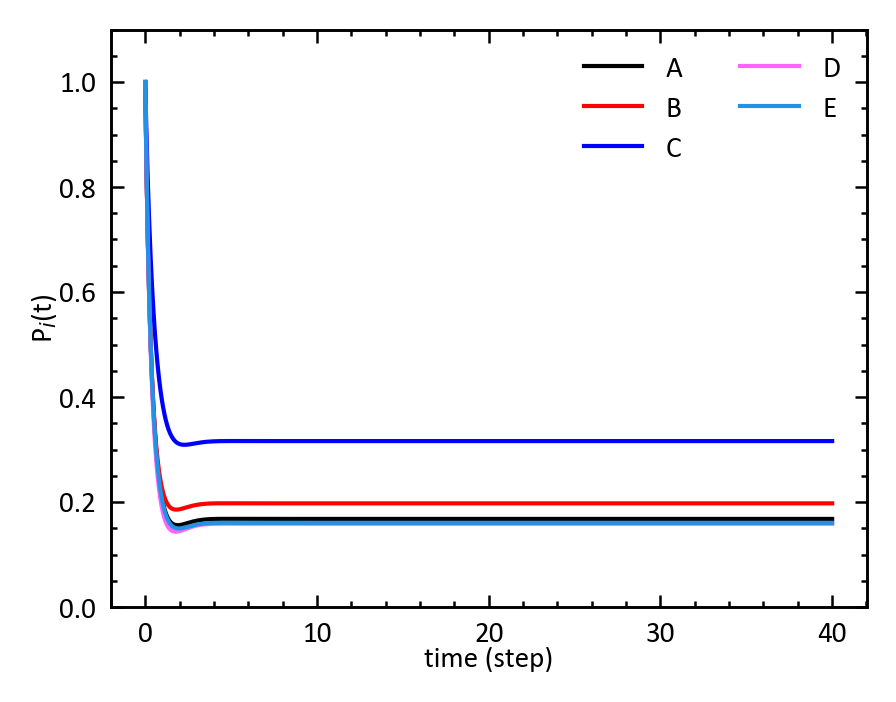

In [8]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
plt.plot(times, P[:, 3, 3], '-', label='D')
plt.plot(times, P[:, 4, 4], '-', label='E')

# plt.hlines(piA, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#F2E100', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

# plt.vlines([t_BA, t_AC], 0, 1, colors='#5A1AF5', linestyles=(0, (5,5)), #label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## SVD

In [194]:
eig_val, eig_vec = SVD(Q)

In [9]:
eig_val

array([-4.16444375e+00+0.67588477j, -4.16444375e+00-0.67588477j,
        3.76637489e-16+0.j        , -1.58555625e+00+1.12905276j,
       -1.58555625e+00-1.12905276j])

In [66]:
eig_val[2] * eig_vec[:,2]

array([1.35376651e-16+0.j, 1.59310645e-16+0.j, 2.55046619e-16+0.j,
       1.27897278e-16+0.j, 1.29393153e-16+0.j])

In [67]:
eig_vec[:, 2] @ Q

array([ 1.11022302e-16+0.j, -1.11022302e-16+0.j,  2.77555756e-17+0.j,
        1.08246745e-15+0.j, -8.88178420e-16+0.j])

In [12]:
P[-1][0]

array([0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364])

In [10]:
np.real(eig_vec[:,2] / np.sum(eig_vec[:,2]))

array([0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364])

In [11]:
np.sum(np.real(eig_vec[:,2] / np.sum(eig_vec[:,2])))

1.0

In [10]:
def Prob_t(val, vec, time):
    # D = np.array([[np.exp(val[0] * time), 0, 0],
    #               [0, np.exp(val[1] * time), 0],
    #               [0, 0, np.exp(val[2] * time)]])
    D = np.eye(5) * np.exp(val * time)
    return np.linalg.inv(vec.T) @ D @ vec.T

In [13]:
# from Spectral decomposition
P_spectral_decomp = []
for t in times:
    P_spectral_decomp.append(Prob_t(eig_val, eig_vec, t))

In [14]:
P_spectral_decomp = np.stack(P_spectral_decomp)

In [15]:
P.shape

(1000, 5, 5)

In [16]:
P_spectral_decomp.shape

(1000, 5, 5)

In [17]:
P[-1]

array([[0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364]])

In [19]:
P_spectral_decomp[-1]

array([[0.16774791+3.49027583e-17j, 0.197405  +4.10734117e-17j,
        0.31603336+6.57560253e-17j, 0.15848007+3.29744291e-17j,
        0.16033364+3.33600950e-17j],
       [0.16774791+3.16335181e-17j, 0.197405  +3.72261842e-17j,
        0.31603336+5.95968489e-17j, 0.15848007+2.98858099e-17j,
        0.16033364+3.02353515e-17j],
       [0.16774791-5.60519386e-45j, 0.197405  +0.00000000e+00j,
        0.31603336+1.12103877e-44j, 0.15848007+2.80259693e-45j,
        0.16033364-5.60519386e-45j],
       [0.16774791-3.13101039e-17j, 0.197405  -3.68455919e-17j,
        0.31603336-5.89875438e-17j, 0.15848007-2.95802639e-17j,
        0.16033364-2.99262319e-17j],
       [0.16774791-2.31379410e-17j, 0.197405  -2.72286266e-17j,
        0.31603336-4.35913694e-17j, 0.15848007-2.18596017e-17j,
        0.16033364-2.21152695e-17j]])

In [18]:
P[10]

array([[0.42942206, 0.31948373, 0.14215948, 0.02578805, 0.08314668],
       [0.08336552, 0.43372012, 0.38576426, 0.07130734, 0.02584276],
       [0.02691728, 0.09993565, 0.60888922, 0.19289581, 0.07136204],
       [0.12409188, 0.04148346, 0.10343707, 0.41602076, 0.31496683],
       [0.31860838, 0.12496723, 0.04498488, 0.08223629, 0.42920322]])

C:\Users\ramon\anaconda3\envs\dmol\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\ramon\anaconda3\envs\dmol\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


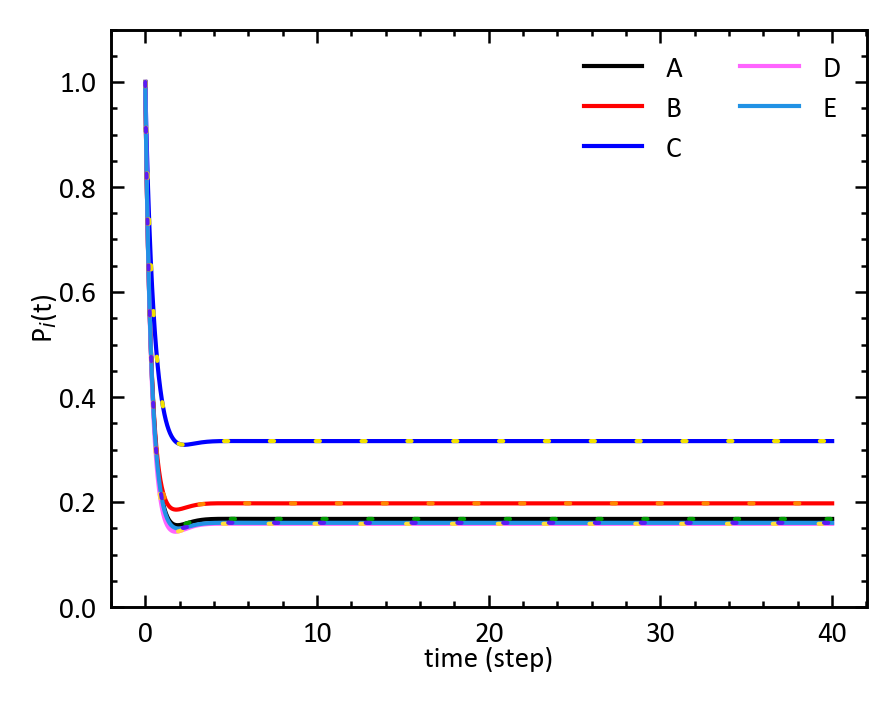

In [20]:
fig = plt.figure()

plt.plot(times, P[:, 0, 0], '-', label='A')
plt.plot(times, P[:, 1, 1], '-', label='B')
plt.plot(times, P[:, 2, 2], '-', label='C')
plt.plot(times, P[:, 3, 3], '-', label='D')
plt.plot(times, P[:, 4, 4], '-', label='E')

plt.plot(times, P_spectral_decomp[:, 0, 0], ls=(0, (1, 10)))#, label='A')
plt.plot(times, P_spectral_decomp[:, 1, 1], ls=(0, (1, 10)))#, label='B')
plt.plot(times, P_spectral_decomp[:, 2, 2], ls=(0, (1, 10)))#, label='C')
plt.plot(times, P_spectral_decomp[:, 3, 3], ls=(0, (1, 10)))#, label='C')
plt.plot(times, P_spectral_decomp[:, 4, 4], ls=(0, (1, 10)))#, label='C')

# plt.hlines(piA, 0, 40, colors='#009900', linestyles=(0, (5,5)), label=r'$\pi_A$', 
#            capstyle='round', joinstyle='miter')
# plt.hlines(piB, 0, 40, colors='#FF8700', linestyles=(0, (5,5)), label=r'$\pi_B$',
#            capstyle='round', joinstyle='round')
# plt.hlines(piC, 0, 40, colors='#2192E5', linestyles=(0, (5,5)), label=r'$\pi_C$', 
#            capstyle='round', joinstyle='bevel')

plt.xlabel('time (step)')
plt.ylabel(r'P$_{\it{i}}$(t)')
plt.ylim([0, 1.1])
plt.legend(ncols=2)

plt.show()

## Traj

In [11]:
def cum_prob(i, j, rate_mat):
    P_j = 0
    for k in range(j+1):
        if k != i:
            P_j += rate_mat[i, k] / (-rate_mat[i, i])
    return P_j

In [12]:
cum_prob(1, 2, Q)

1.0

In [13]:
curr_state = np.random.choice(5)
steps = 1000
traj = []
for i in range(steps):
    R = np.random.uniform()
    time = np.log(R) / Q[curr_state, curr_state]
    traj.append([curr_state, time])
    for j in range(Q.shape[0]):
        if j != curr_state:
            P_j = cum_prob(curr_state, j, Q)
            if R <= P_j:
                curr_state = j
                break

In [14]:
traj = np.array(traj)

In [15]:
traj[:,0]

array([0., 1., 2., 3., 4., 3., 4., 0., 1., 2., 3., 4., 0., 1., 0., 1., 2.,
       1., 0., 1., 2., 3., 4., 0., 4., 0., 1., 0., 4., 0., 4., 0., 1., 2.,
       1., 2., 3., 4., 0., 1., 0., 1., 2., 3., 2., 3., 4., 0., 1., 2., 3.,
       4., 3., 4., 3., 4., 0., 1., 2., 3., 2., 1., 2., 3., 4., 0., 4., 3.,
       2., 1., 2., 3., 4., 0., 4., 0., 1., 2., 3., 4., 0., 1., 2., 3., 4.,
       0., 4., 0., 1., 2., 3., 2., 3., 4., 0., 4., 3., 4., 3., 2., 3., 2.,
       3., 4., 0., 1., 0., 4., 0., 1., 2., 1., 2., 3., 4., 0., 1., 2., 3.,
       2., 1., 0., 1., 0., 1., 2., 1., 2., 3., 4., 3., 4., 0., 1., 2., 3.,
       4., 0., 1., 2., 3., 4., 0., 1., 2., 3., 2., 1., 2., 3., 2., 3., 2.,
       3., 4., 0., 1., 2., 3., 4., 0., 1., 2., 1., 0., 1., 2., 3., 4., 0.,
       1., 2., 3., 4., 0., 1., 2., 1., 2., 1., 2., 1., 2., 3., 4., 0., 1.,
       2., 3., 4., 3., 4., 0., 1., 2., 3., 4., 0., 1., 0., 1., 0., 4., 0.,
       1., 0., 1., 2., 1., 2., 3., 4., 3., 4., 3., 4., 0., 4., 0., 4., 0.,
       1., 2., 1., 2., 3.

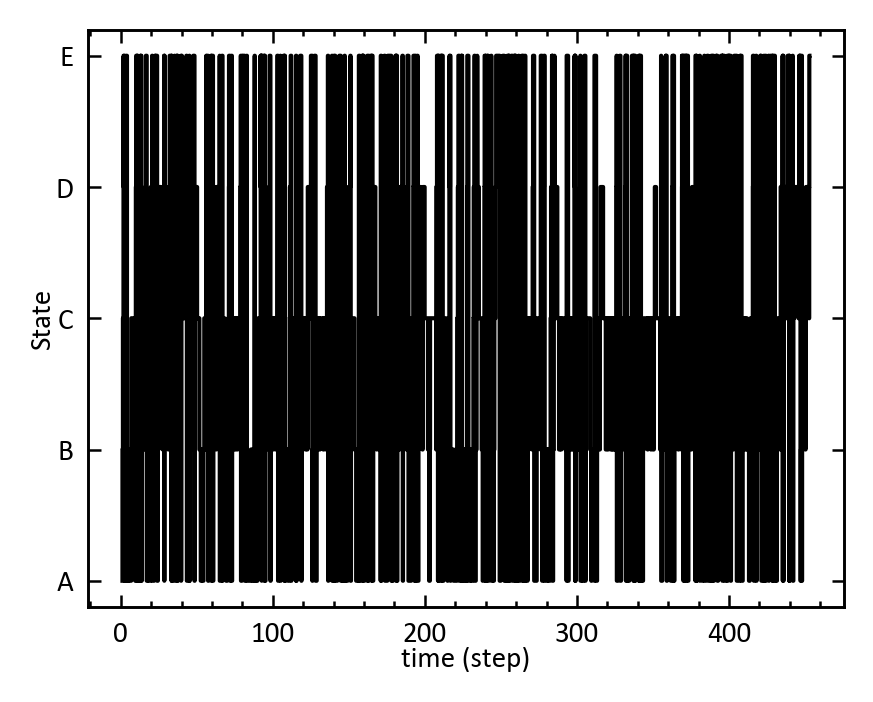

In [16]:
fig = plt.figure()

# A = (traj[:,0] == 0) + (traj[:,0] == 1)
# C = (traj[:,0] == 2) + (traj[:,0] == 1)
# plt.plot(np.cumsum(traj[:,1])[A], traj[:,0][A], 
#          drawstyle='steps')
plt.plot(np.cumsum(traj[:,1]), traj[:,0], 
         drawstyle='steps')
# plt.plot(np.cumsum(traj[:,1])[C], traj[:,0][C], 
#          drawstyle='steps')

plt.tick_params(axis='y', which='minor', left=False, 
                right=False)
plt.yticks([0,1,2,3,4], ['A', 'B', 'C', 'D', 'E'])
plt.xlabel('time (step)')
plt.ylabel('State')
# plt.xlim([0, 10])
# plt.legend(ncols=2)

plt.show()

$\dots A \leftrightharpoons B \leftrightharpoons C \leftrightharpoons D \leftrightharpoons E \leftrightharpoons A \dots$ \
k$_{A \rightarrow B} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{C \rightarrow D} = 1/step$ \
k$_{D \rightarrow C} = 0.5/step$ \
k$_{D \rightarrow E} = 2/step$ \
k$_{E \rightarrow D} = 0.5/step$ \
k$_{E \rightarrow A} = 2/step$ \
k$_{A \rightarrow E} = 0.5/step$ 

In [19]:
N = np.zeros((5,5))
for i, j in zip(traj[:,0][:-1], traj[:,0][1:]):
    N[int(i), int(j)] += 1
print(N)

[[  0. 154.   0.   0.  42.]
 [ 46.   0. 188.   0.   0.]
 [  0.  80.   0. 138.   0.]
 [  0.   0.  30.   0. 140.]
 [149.   0.   0.  32.   0.]]


In [20]:
T_A = traj[:,1][traj[:,0] == 0].sum()
T_B = traj[:,1][traj[:,0] == 1].sum()
T_C = traj[:,1][traj[:,0] == 2].sum()
T_D = traj[:,1][traj[:,0] == 3].sum()
T_E = traj[:,1][traj[:,0] == 4].sum()
T   = traj[:,1].sum()
print(1/k_AB, T_A / N[0,1])

0.5 0.4864532673160005


In [22]:
print(1/k_BA, T_B / N[1,0], 1/k_CD, T_C / N[2,3])

2.0 1.940044620447114 1.0 1.0955567469273264


In [28]:
print(N[0,1] / (N[0,1] + N[0,4]))

0.7857142857142857


In [29]:
print(N[1,2] / (N[1,0] + N[1,2]))

0.8034188034188035


In [30]:
P[-1]

array([[0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364],
       [0.16774791, 0.197405  , 0.31603336, 0.15848007, 0.16033364]])

In [32]:
# equilibrium prob
print(T_A / T, T_B / T, T_C / T)

0.16540519388762215 0.19704111097606689 0.3338114746589729


In [34]:
# flux
print(N[0,1] / T, N[1,2] / T)

0.34002278327832625 0.41509274841769694


In [36]:
print(k_AB, N[0,1] / T_A, 
      k_BC, N[1,2] / T_B)

2 2.05569592638875 2 2.106630166473814


## MSM 

In [195]:
lagtime = 0.1

In [196]:
Prob_t(uniqueStates, eig_val, eig_vec, lagtime)

array([[0.78660941-3.46944695e-18j, 0.15654707+1.80411242e-16j,
        0.01617195+0.00000000e+00j, 0.00150999-1.11022302e-16j,
        0.03916159+8.32667268e-17j],
       [0.03916324+2.77555756e-17j, 0.78674116+0.00000000e+00j,
        0.16449129+5.55111512e-17j, 0.0080939 -2.77555756e-17j,
        0.00151041+8.32667268e-17j],
       [0.00154334+2.77555756e-17j, 0.0411493 -2.77555756e-17j,
        0.86696729+3.81639165e-17j, 0.08224575-1.38777878e-17j,
        0.00809431-5.55111512e-17j],
       [0.01563831-1.11022302e-16j, 0.00205046+0.00000000e+00j,
        0.04117583+0.00000000e+00j, 0.78472175+6.93889390e-17j,
        0.15641366-1.94289029e-16j],
       [0.15654044-7.97972799e-17j, 0.01564494+0.00000000e+00j,
        0.00207698-1.11022302e-16j, 0.03912989+4.16333634e-17j,
        0.78660775+2.77555756e-17j]])

In [197]:
np.real(Prob_t(uniqueStates, eig_val, eig_vec, lagtime))

array([[0.78660941, 0.15654707, 0.01617195, 0.00150999, 0.03916159],
       [0.03916324, 0.78674116, 0.16449129, 0.0080939 , 0.00151041],
       [0.00154334, 0.0411493 , 0.86696729, 0.08224575, 0.00809431],
       [0.01563831, 0.00205046, 0.04117583, 0.78472175, 0.15641366],
       [0.15654044, 0.01564494, 0.00207698, 0.03912989, 0.78660775]])

In [198]:
MSM_true, traj_discrete = MSMtraj(40000, np.real(Prob_t(uniqueStates, eig_val, eig_vec, lagtime)))

In [199]:
traj_discrete

array([2, 2, 2, ..., 4, 4, 4])

In [200]:
count_estimator = dt.markov.TransitionCountEstimator(
    lagtime=1,
    count_mode="sliding"
)

In [201]:
count_estimator.fit(traj_discrete).fetch_model().count_matrix

array([[5.1990e+03, 1.0490e+03, 1.0600e+02, 1.2000e+01, 2.4000e+02],
       [2.9800e+02, 6.6210e+03, 1.2910e+03, 5.6000e+01, 1.8000e+01],
       [1.4000e+01, 5.1500e+02, 1.0917e+04, 1.0410e+03, 9.1000e+01],
       [1.1200e+02, 9.0000e+00, 2.5000e+02, 4.9240e+03, 9.7100e+02],
       [9.8300e+02, 9.0000e+01, 1.3000e+01, 2.3300e+02, 4.9460e+03]])

In [202]:
MSM_estimator = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=None
)

In [203]:
MSM_estimator2 = dt.markov.msm.MaximumLikelihoodMSM(
    reversible=True,
    stationary_distribution_constraint=np.real(eig_vec[:,2] / np.sum(eig_vec[:,2]))
)

In [204]:
MSM = MSM_estimator.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()
MSM2 = MSM_estimator2.fit(count_estimator.fit(traj_discrete).fetch_model()).fetch_model()

In [205]:
models = []
models2 = []
for lag in range(10):
    count_estimator = dt.markov.TransitionCountEstimator(lagtime=lag+1, count_mode='sliding')
    models.append(MSM_estimator.fit_fetch(count_estimator.fit_fetch(traj_discrete)))
    models2.append(MSM_estimator2.fit_fetch(count_estimator.fit_fetch(traj_discrete)))

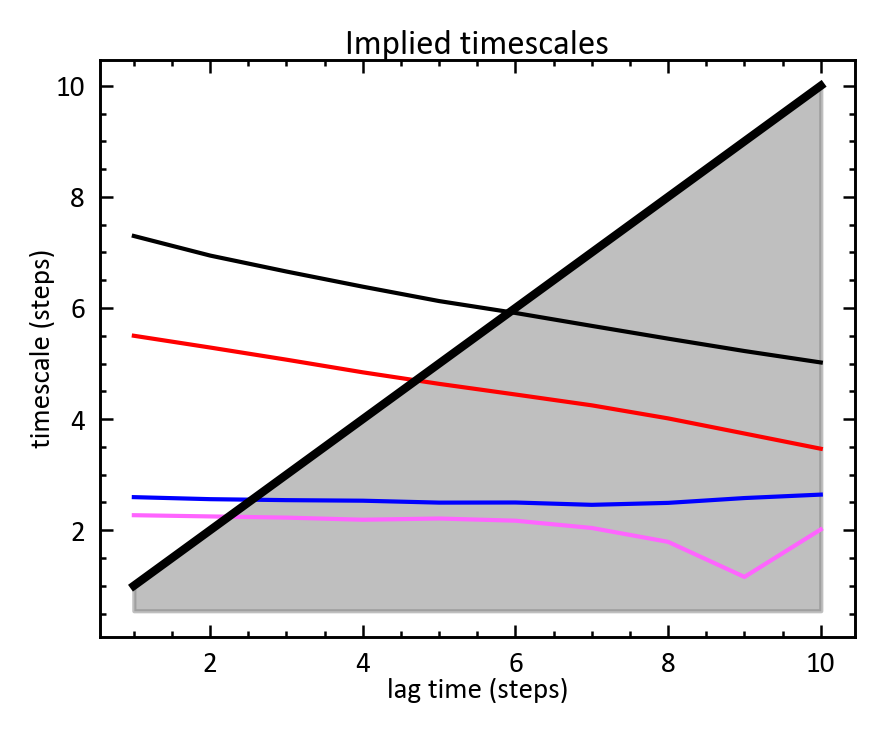

In [206]:
fig, ax = plt.subplots(1,1)
dt.plots.plot_implied_timescales(dt.util.validation.implied_timescales(models2))

ax.set_title("Implied timescales")
ax.set_xlabel("lag time (steps)")
ax.set_ylabel("timescale (steps)")

plt.show()

The first and second timescales get faster with increasing lagtime

In [207]:
np.exp(eig_val*lagtime)

array([0.65788166+0.04453305j, 0.65788166-0.04453305j,
       1.        +0.j        , 0.84794202+0.09614602j,
       0.84794202-0.09614602j])

In [208]:
eig_vec

array([[-0.39353595+0.24393316j, -0.39353595-0.24393316j,
         0.35943488+0.j        , -0.41544348+0.1583888j ,
        -0.41544348-0.1583888j ],
       [ 0.60470677+0.j        ,  0.60470677-0.j        ,
         0.42298138+0.j        , -0.05932158+0.41965926j,
        -0.05932158-0.41965926j],
       [-0.438857  -0.15830842j, -0.438857  +0.15830842j,
         0.67716737+0.j        ,  0.60564654+0.j        ,
         0.60564654-0.j        ],
       [ 0.133789  +0.25037426j,  0.133789  -0.25037426j,
         0.3395766 +0.j        ,  0.13365263-0.31102326j,
         0.13365263+0.31102326j],
       [ 0.09389718-0.33599899j,  0.09389718+0.33599899j,
         0.34354826+0.j        , -0.26453411-0.2670248j ,
        -0.26453411+0.2670248j ]])

In [209]:
print(MSM_true.eigenvalues())

[1.        +0.j         0.84794202-0.09614602j 0.84794202+0.09614602j
 0.65788166-0.04453305j 0.65788166+0.04453305j]


In [210]:
MSM_true.eigenvectors_left()

array([[ 0.16774791-6.48401475e-17j,  0.197405  +4.87961845e-17j,
         0.31603336-2.23515765e-17j,  0.15848007+6.66991004e-18j,
         0.16033364+3.17256295e-17j],
       [ 0.26046303-4.14006095e-01j,  0.46550756+2.65139390e-02j,
        -0.13061988+6.53350202e-01j, -0.36434585+7.71013310e-02j,
        -0.23100486-3.42959377e-01j],
       [ 0.26046303+4.14006095e-01j,  0.46550756-2.65139390e-02j,
        -0.13061988-6.53350202e-01j, -0.36434585-7.71013310e-02j,
        -0.23100486+3.42959377e-01j],
       [ 0.10121486-5.43412716e-01j,  0.26155816+6.72880435e-01j,
        -0.36597783-4.19858750e-01j,  0.33646976+4.05759812e-02j,
        -0.33326495+2.49815050e-01j],
       [ 0.10121486+5.43412716e-01j,  0.26155816-6.72880435e-01j,
        -0.36597783+4.19858750e-01j,  0.33646976-4.05759812e-02j,
        -0.33326495-2.49815050e-01j]])

In [211]:
MSM_true.eigenvectors_right().T

array([[ 1.        +7.07253696e-17j,  1.        +7.07253696e-17j,
         1.        +7.07253696e-17j,  1.        +7.07253696e-17j,
         1.        +7.07253696e-17j],
       [ 0.24451054+3.40506669e-01j,  0.37291395-8.34661263e-02j,
         0.06225795-3.33808966e-01j, -0.56867146-0.00000000e+00j,
        -0.27557352+4.04482285e-01j],
       [ 0.24451054-3.40506669e-01j,  0.37291395+8.34661263e-02j,
         0.06225795+3.33808966e-01j, -0.56867146+0.00000000e+00j,
        -0.27557352-4.04482285e-01j],
       [ 0.15083093+3.61055075e-01j,  0.11411623-2.90753273e-01j,
        -0.23093561+1.13142753e-01j,  0.6347283 -0.00000000e+00j,
        -0.47050087-2.42787283e-01j],
       [ 0.15083093-3.61055075e-01j,  0.11411623+2.90753273e-01j,
        -0.23093561-1.13142753e-01j,  0.6347283 +0.00000000e+00j,
        -0.47050087+2.42787283e-01j]])

The right eigenvectors are the ones that are normalized to the equilibrium probabilities

In [212]:
# number of slow modes
MSM_true.eigenvectors_left().shape[0]-1

4

Eigenvalues are the same from the rate matrix and the MSM, but the eigenvectors are not. I think this is because the eigenvectors are taken differently in deeptime or because the eigenvectors need to be recomputed when disctizing the rate matrix to an MSM

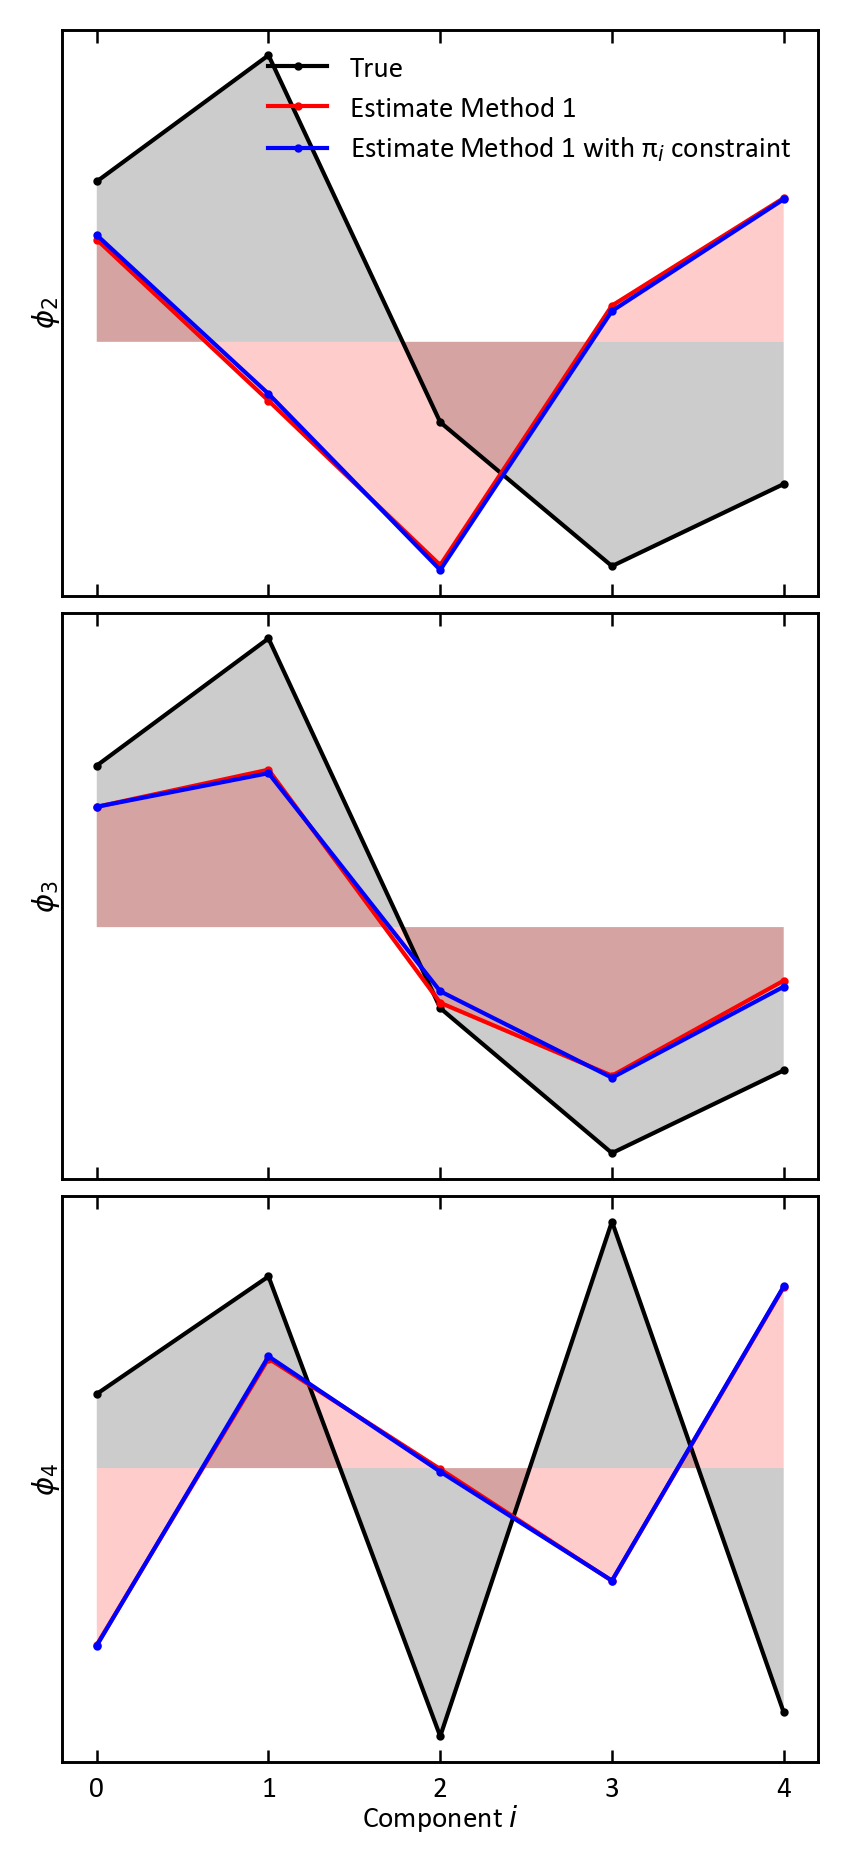

In [213]:
fig, axs = plt.subplots(3,1, figsize=(1*3.25, 3*2.5), sharex=True, sharey=False)
# fig.tight_layout()
plt.subplots_adjust(hspace=0.03)

true, esti1, esti1_con = (MSM_true.eigenvectors_left(), MSM.eigenvectors_left(), MSM2.eigenvectors_left())
comps = np.arange(uniqueStates)

axs[0].plot(true[1], 'o-', label="True")
axs[0].plot(esti1[1], 'o-', label="Estimate Method 1")
axs[0].plot(esti1_con[1], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[0].fill_between(comps, true[1], alpha=0.2)
axs[0].fill_between(comps, esti1[1], alpha=0.2)
# axs[0].fill_between(comps, esti1_con[1], alpha=0.2, color=colorList[2])

axs[1].plot(true[2], 'o-', label="True")
axs[1].plot(esti1[2], 'o-', label="Estimate Method 1")
axs[1].plot(esti1_con[2], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[1].fill_between(comps, true[2], alpha=0.2)
axs[1].fill_between(comps, esti1[2], alpha=0.2)
# axs[1].fill_between(comps, esti1_con[2], alpha=0.2, color=colorList[2])

i = 4
axs[2].plot(true[i], 'o-', label="True")
axs[2].plot(esti1[i], 'o-', label="Estimate Method 1")
axs[2].plot(esti1_con[i], 'o-', label=r"Estimate Method 1 with $\pi_{\it{i}}$ constraint")

axs[2].fill_between(comps, true[i], alpha=0.2)
axs[2].fill_between(comps, esti1[i], alpha=0.2)
# axs[2].fill_between(comps, esti1_con[i], alpha=0.2, color=colorList[2])

# plt.plot(MSM.eigenvectors_right()[1], 'o-')
# plt.plot(MSM2.eigenvectors_right()[1], 'o-')
axs[0].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[1].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[2].tick_params(axis='x', which='minor', bottom=False, top=False)
axs[0].set_xticks(comps)
axs[0].set_yticks([])
axs[1].set_yticks([])
axs[2].set_yticks([])
axs[2].set_xlabel(r"Component $\it{i}$")
axs[0].set_ylabel(r"$\it{\phi}_2$")
axs[1].set_ylabel(r"$\it{\phi}_3$")
axs[2].set_ylabel(r"$\it{\phi}_4$")
axs[0].legend()

plt.show()

In [214]:
print(MSM_true.timescales())
print(MSM.timescales())
print(MSM2.timescales())

[6.30693486 6.30693486 2.40128108 2.40128108]
[7.20813427 5.53857711 2.60465614 2.26483574]
[7.29568389 5.49997931 2.59495768 2.26987983]


In [215]:
rf = MSM_true.reactive_flux([0], [1])
rf2 = MSM.reactive_flux([0], [1])
rf3 = MSM2.reactive_flux([0], [1])

In [216]:
print(rf.backward_committor, rf.forward_committor)
print(rf2.backward_committor, rf2.forward_committor)
print(rf3.backward_committor, rf3.forward_committor)

[1.         0.         0.08648825 0.12669207 0.29026217] [0.         1.         0.42013146 0.16858218 0.10831765]
[1.         0.         0.24056418 0.47042181 0.68755844] [0.         1.         0.75943582 0.52957819 0.31244156]
[1.         0.         0.24813786 0.47762384 0.69266439] [0.         1.         0.75186214 0.52237616 0.30733561]


In [217]:
print(rf.mfpt)
print(rf2.mfpt)
print(rf3.mfpt)

9.295086052669735
17.910359884100547
18.582008184945444


In [218]:
print(rf.rate)
print(rf2.rate)
print(rf3.rate)

0.1075837269642899
0.05583360727931122
0.053815496691588395


In [219]:
k_AB

2

In [220]:
print(MSM_true.stationary_distribution)
print(MSM.stationary_distribution)
print(MSM2.stationary_distribution)

[0.16774791 0.197405   0.31603336 0.15848007 0.16033364]
[0.16520532 0.20707123 0.31427101 0.15667662 0.15677581]
[0.16774791 0.197405   0.31603336 0.15848007 0.16033364]


In [221]:
print(rf.gross_flux)
print(rf2.gross_flux)
print(rf3.gross_flux)

[[0.00000000e+00 2.62604444e-02 1.13973693e-03 4.27015330e-05
  7.11568348e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.12474088e-03 0.00000000e+00 3.78979028e-04
  2.39645438e-05]
 [0.00000000e+00 4.11694231e-05 3.47337470e-04 0.00000000e+00
  3.40171567e-04]
 [0.00000000e+00 7.28096501e-04 4.06100577e-05 3.06997899e-04
  0.00000000e+00]]
[[0.00000000e+00 1.68391496e-02 1.13902009e-03 8.21053422e-04
  4.77954935e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 5.42881329e-03 0.00000000e+00 2.05546716e-03
  9.77300957e-05]
 [0.00000000e+00 3.82223643e-04 5.76405370e-03 0.00000000e+00
  2.21329137e-03]
 [0.00000000e+00 9.28586004e-04 6.78936670e-04 5.48304811e-03
  0.00000000e+00]]
[[0.         0.01653034 0.00114272 0.00082214 0.00480256]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00546744 0.         0.00211113 0.00010072]
 [0.         0.00037954 

In [222]:
print(rf.net_flux)
print(rf2.net_flux)
print(rf3.net_flux)

[[0.00000000e+00 2.62604444e-02 1.13973693e-03 4.27015330e-05
  7.11568348e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00]
 [0.00000000e+00 1.12474088e-03 0.00000000e+00 3.16415574e-05
  0.00000000e+00]
 [0.00000000e+00 4.11694231e-05 0.00000000e+00 0.00000000e+00
  3.31736673e-05]
 [0.00000000e+00 7.28096501e-04 1.66455139e-05 0.00000000e+00
  0.00000000e+00]]
[[0.         0.01683915 0.00113902 0.00082105 0.00477955]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00542881 0.         0.         0.        ]
 [0.         0.00038222 0.00370859 0.         0.        ]
 [0.         0.00092859 0.00058121 0.00326976 0.        ]]
[[0.         0.01653034 0.00114272 0.00082214 0.00480256]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00546744 0.         0.         0.        ]
 [0.         0.00037954 0.00373761 0.         0.        ]
 [0.         0.00092043 0.00058711 0.00329501 0.        ]]


In [223]:
traj_discrete.shape

(40000,)

In [224]:
traj_discrete[:32]

array([2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 4, 4])

In [225]:
state_durations = stateDurations(uniqueStates, traj_discrete)
avg_state_durations = {key: np.mean(state_durations[key]) for key in state_durations.keys()}

In [226]:
state_durations[0]

[3,
 6,
 2,
 6,
 2,
 1,
 6,
 6,
 6,
 16,
 3,
 1,
 11,
 4,
 1,
 8,
 10,
 2,
 4,
 1,
 5,
 4,
 9,
 1,
 5,
 1,
 1,
 5,
 6,
 3,
 3,
 8,
 1,
 3,
 5,
 3,
 2,
 14,
 1,
 7,
 4,
 4,
 1,
 2,
 4,
 1,
 5,
 2,
 7,
 3,
 3,
 17,
 1,
 11,
 9,
 5,
 2,
 6,
 5,
 12,
 2,
 7,
 4,
 1,
 4,
 17,
 3,
 5,
 7,
 7,
 3,
 4,
 9,
 7,
 8,
 2,
 7,
 15,
 6,
 10,
 1,
 7,
 4,
 2,
 2,
 9,
 3,
 2,
 13,
 3,
 4,
 1,
 6,
 11,
 4,
 1,
 4,
 3,
 5,
 8,
 2,
 2,
 8,
 2,
 3,
 1,
 1,
 2,
 2,
 1,
 14,
 2,
 1,
 14,
 1,
 2,
 1,
 10,
 2,
 11,
 2,
 4,
 5,
 1,
 1,
 24,
 8,
 6,
 1,
 11,
 4,
 1,
 1,
 4,
 1,
 5,
 5,
 1,
 6,
 3,
 8,
 6,
 16,
 2,
 5,
 8,
 2,
 8,
 7,
 5,
 4,
 1,
 4,
 1,
 7,
 2,
 2,
 1,
 5,
 2,
 2,
 2,
 4,
 4,
 4,
 12,
 4,
 7,
 7,
 5,
 2,
 5,
 1,
 3,
 3,
 1,
 8,
 1,
 10,
 1,
 4,
 3,
 10,
 1,
 1,
 3,
 4,
 1,
 3,
 6,
 2,
 3,
 2,
 3,
 7,
 1,
 3,
 10,
 3,
 3,
 1,
 4,
 5,
 3,
 1,
 3,
 5,
 5,
 2,
 23,
 2,
 11,
 1,
 4,
 3,
 2,
 4,
 4,
 11,
 2,
 2,
 2,
 19,
 5,
 13,
 3,
 2,
 2,
 1,
 8,
 3,
 2,
 4,
 4,
 1,
 6,
 4,
 2,
 2,
 7,
 1,
 3,
 6,


In [227]:
avg_state_durations

{0: 4.6950959488272925,
 1: 4.981358989777511,
 2: 7.572546658639374,
 3: 4.669150521609538,
 4: 4.748294162244124}

In [228]:
ProbMat = ProbMatrix(uniqueStates, traj_discrete)

In [229]:
ProbMat

array([[0.        , 0.74555792, 0.0753376 , 0.00852878, 0.17057569],
       [0.17919423, 0.        , 0.77630788, 0.03367408, 0.01082381],
       [0.00842866, 0.31005418, 0.        , 0.62673089, 0.05478627],
       [0.08345753, 0.00670641, 0.18628912, 0.        , 0.72354694],
       [0.74526156, 0.06823351, 0.00985595, 0.17664898, 0.        ]])

In [230]:
np.sum(ProbMat, axis=1)

array([1., 1., 1., 1., 1.])

In [231]:
MSM_true.transition_matrix

array([[0.78660941, 0.15654707, 0.01617195, 0.00150999, 0.03916159],
       [0.03916324, 0.78674116, 0.16449129, 0.0080939 , 0.00151041],
       [0.00154334, 0.0411493 , 0.86696729, 0.08224575, 0.00809431],
       [0.01563831, 0.00205046, 0.04117583, 0.78472175, 0.15641366],
       [0.15654044, 0.01564494, 0.00207698, 0.03912989, 0.78660775]])

In [232]:
MSM.transition_matrix

array([[0.7870118 , 0.10192861, 0.00907855, 0.00938463, 0.0925964 ],
       [0.08132057, 0.79925157, 0.10898185, 0.00392383, 0.00652218],
       [0.00477239, 0.07180747, 0.86794404, 0.05133874, 0.00413737],
       [0.00989549, 0.00518592, 0.1029782 , 0.78582828, 0.09611212],
       [0.09757512, 0.00861457, 0.00829372, 0.09605131, 0.78946528]])

In [233]:
mfpt = np.array(list(avg_state_durations.values())) * lagtime

In [234]:
mfpt

array([0.46950959, 0.4981359 , 0.75725467, 0.46691505, 0.47482942])

In [235]:
print(1/k_AB, 1/k_BC, 1/k_CD,)

0.5 0.5 1.0


In [236]:
inv_mfpt_X2, inv_mfpt_X1 = np.meshgrid(1 / mfpt, 1 / mfpt)

In [237]:
inv_mfpt_X1

array([[2.12988193, 2.12988193, 2.12988193, 2.12988193, 2.12988193],
       [2.00748431, 2.00748431, 2.00748431, 2.00748431, 2.00748431],
       [1.32055971, 1.32055971, 1.32055971, 1.32055971, 1.32055971],
       [2.1417172 , 2.1417172 , 2.1417172 , 2.1417172 , 2.1417172 ],
       [2.10601948, 2.10601948, 2.10601948, 2.10601948, 2.10601948]])

In [238]:
print(k_AB, k_AE, k_BA, k_BC, k_CB, k_CD, k_EA, k_ED)

2 0.5 0.5 2 0.5 1 2 0.5


In [239]:
ProbMat * inv_mfpt_X1

array([[0.        , 1.58795035, 0.16046019, 0.0181653 , 0.36330609],
       [0.3597296 , 0.        , 1.55842588, 0.06760019, 0.02172863],
       [0.01113055, 0.40944506, 0.        , 0.82763555, 0.07234855],
       [0.17874242, 0.01436323, 0.39897861, 0.        , 1.54963294],
       [1.56953537, 0.1437011 , 0.02075683, 0.37202619, 0.        ]])

$\dots A \leftrightharpoons B \leftrightharpoons C \leftrightharpoons D \leftrightharpoons E \leftrightharpoons A \dots$ \
k$_{A \rightarrow B} = 2/step$ \
k$_{B \rightarrow A} = 0.5/step$ \
k$_{B \rightarrow C} = 2/step$ \
k$_{C \rightarrow B} = 0.5/step$ \
k$_{C \rightarrow D} = 1/step$ \
k$_{D \rightarrow C} = 0.5/step$ \
k$_{D \rightarrow E} = 2/step$ \
k$_{E \rightarrow D} = 0.5/step$ \
k$_{E \rightarrow A} = 2/step$ \
k$_{A \rightarrow E} = 0.5/step$ 